# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

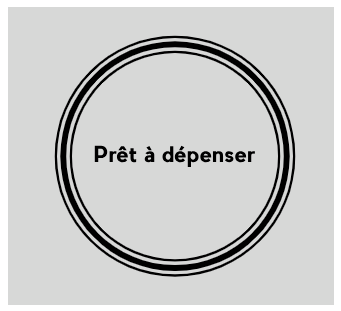

 # <span class='bg-primary'>P7_01_02 - EDA - PARTIE 2</span>

Ce notebook traite de l'analyse exploratoire des jeux de données :

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

mis à notre disposition à partir d'un kernel kaggle.

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire ayant l'EDA le plus de commentaires et effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par **Rishabh Rao** (Student at -Jaipur, Rajasthan, India).
- [Kernel Kaggle Rishabh Rao](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce travail est complété par l'auteur par une présentation sur le site medium.com :
[Explications](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)

Les fonctions python utilisées pour l'EDA sont extraites du [github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk) et stockées dans la librairie *EDA_KERNEL_FONCTIONS.py*.

In [2]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import outils_data
import eda_kernel_fonctions
# import phik
# Plotly
import plotly
# import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('EDA KERNEL KAGGLE     : ' + eda_kernel_fonctions.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Outils dataframe      : 0.0.4
EDA KERNEL KAGGLE     : 0.0.0
Lancé le           : 2021-07-21T16:55:59.587796


In [3]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
    #     # pandas DataFrame column and row display limits
    #     'max_columns': None,
    #     'max_rows': None,
    #     'display.max_colwidth': 800
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Jeux de données</span>

### <span style='background:PowderBlue'>2.1. Description des jeux de données</span>

| Fichier | Description |
| --- | --- |
|  <p style='text-align: justify;'>**bureau.csv** |  <ul style='text-align: justify;'><li>Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau (pour les clients qui ont un prêt dans notre échantillon). </li> <li> Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.</li> |
| <p style='text-align: justify;'>**bureau_balance.csv** | <ul style='text-align: justify;'><li>Soldes mensuels des crédits précédents dans Credit Bureau. </li> <li> Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) des lignes.</li></ul> |
| <p style='text-align: justify;'>**POS_CASH_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit. </li> <li> Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent au Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.</li></ul> |
| <p style='text-align: justify;'>**credit_card_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit. </li> <li>  Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.</li></ul>|
| <p style='text-align: justify;'>**previous_application.csv** | <ul style='text-align: justify;'><li>Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon. </li> <li> Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.</li></ul> |
| <p style='text-align: justify;'>**installments_payments.csv** | <ul style='text-align: justify;'><li>Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon. </li> <li>  Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.</li></ul> |

### <span style='background:PowderBlue'>2.2. Chargement des données</span>

In [4]:
# Répertoire de stockages des fichiers mis à notre disposition
path = '../data/'

**Chargement des fichiers**

In [5]:
application_train, application_test, bureau, bureau_balance, cc_balance, \
    installments_payments, POS_CASH_balance, previous_application, \
    HomeCredit_columns_description = \
    eda_kernel_fonctions.load_all_tables(path)

Chargement des jeux de donnees...
--------------------------------------------------------------------
Fichier application_train.csv chargé -> dataframe : application_train
Fichier application_test.csv chargé -> dataframe : application_test
Fichier bureau.csv chargé -> dataframe : bureau
Fichier bureau_balance.csv chargé -> dataframe : bureau_balance
Fichier credit_card_balance.csv chargé -> dataframe : cc_balance
Fichier installments_payments.csv chargé -> dataframe : installments_payments
Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance
Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description
Fichier previous_application.csv chargé -> dataframe : previous_application
--------------------------------------------------------------------
Chargement des 9 jeux de donnees terminée en 0:00:29.156112 secondes


**Vue d'ensemble**

In [6]:
# Vue d'ensemble des 6 jeux de données à analyser
dataframes = [bureau, bureau_balance, cc_balance, installments_payments,
              POS_CASH_balance, previous_application]
noms = ['bureau', 'bureau_balance', 'cc_balance', 'installments_payments',
        'POS_CASH_balance', 'previous_application']
outils_data.resume_datasets(dataframes, noms)

Les données se décomposent en 6 fichier(s).


### <span style='background:PowderBlue'>2.3. Fichier bureau.csv</span>

#### <span style='background:Moccasin'>2.3.1. Description/statistiques</span>

<span style='background:PaleGreen'>**Description**</span>

- Ce fichier **bureau.csv** comprend tous les **antécédents de crédit antérieurs du demandeur auprès d'institutions financières autres que le Home Credit Group**, qui ont été signalés par le bureau de crédit.

<span style='background:PaleGreen'>**Compréhension des variables**</span>

In [7]:
df_var_bureau = \
    HomeCredit_columns_description[HomeCredit_columns_description['Table']
                                   == 'bureau.csv']
df_var_bureau.style.hide_index()

<span style='background:PaleGreen'>**Statistiques**</span>

In [10]:
bureau.name = 'bureau'
application_train.name = 'application_train'
application_test.name = 'application_test'
eda_kernel_fonctions. \
    afficher_stats_basic_all(bureau, application_train,
                             application_test, 'SK_ID_BUREAU')

-------------------------------------------------------------------------------
Le jeu de données contient 1716428 lignes et 17 variables.
-------------------------------------------------------------------------------
Nombre de valeurs uniques SK_ID_BUREAU dans bureau.csv : 1716428
Nombre de valeurs uniques SK_ID_CURR dans bureau.csv : 305811
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et bureau.csv : 263491
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et bureau.csv : 42320
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans bureau.csv : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
0      215354       5714462        Closed      currency 1         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                  0.0                   NaN                     0.0  Consumer credit                -131   
1      215354       5714463        Active      currency 1         -208                   0               1075.0                NaN                     NaN                   0        225000.0             171342.0                   NaN                     0.0      Credit card                 -20   
2      215354       5714464        Active      currency 1         -203                   0                528.0                NaN                     NaN                   0        464323.5                  NaN                   NaN                     0.0  Consumer credit                 -16   
3      215354       5714465        Active      currency 1         -203                   0                  NaN                NaN                     NaN                   0         90000.0                  NaN                   NaN                     0.0      Credit card                 -16   
4      215354       5714466        Active      currency 1         -629                   0               1197.0                NaN                 77674.5                   0       2700000.0                  NaN                   NaN                     0.0  Consumer credit                 -21   

   AMT_ANNUITY  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

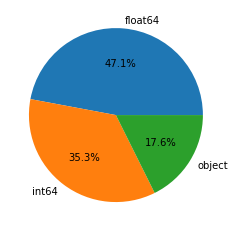

In [9]:
# Types des variables
outils_data.get_types_variables(bureau, True, True, True)

In [10]:
# Résumé des variables
desc_bureau = outils_data.description_variables(bureau)
desc_bureau

SK_ID_CURR SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY DAYS_CREDIT CREDIT_DAY_OVERDUE DAYS_CREDIT_ENDDATE DAYS_ENDDATE_FACT AMT_CREDIT_MAX_OVERDUE CNT_CREDIT_PROLONG AMT_CREDIT_SUM AMT_CREDIT_SUM_DEBT AMT_CREDIT_SUM_LIMIT AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE DAYS_CREDIT_UPDATE  \
type          int64        int64        object          object       int64              int64             float64           float64                float64              int64        float64             float64              float64                float64           object              int64   
nb_nan          0.0          0.0           0.0             0.0         0.0                0.0            105553.0          633653.0              1124488.0                0.0           13.0            257669.0             591780.0                    0.0              0.0                0.0   
%_nan           0.0          0.0           0.0             0.0         0.0                0.0              0.3617            2.1716                 3.8537                0.0            0.0              0.8831               2.0281                    0.0              0.0                0.0   
count     1716428.0    1716428.0       1716428         1716428   1716428.0          1716428.0           1610875.0         1082775.0               591940.0          1716428.0      1716415.0           1458759.0            1124648.0              1716428.0          1716428          1716428.0   
unique          NaN          NaN             4               4         NaN                NaN                 NaN               NaN                    NaN                NaN            NaN                 NaN                  NaN                    NaN               15                NaN   
top             NaN          NaN        Closed      currency 1         NaN                NaN                 NaN               NaN                    NaN                NaN            NaN                 NaN                  NaN                    NaN  Consumer credit                NaN   
freq            NaN          NaN       1079273         1715020         NaN                NaN                 NaN               NaN                    NaN                NaN            NaN                 NaN                  NaN                    NaN          1251615                NaN   
mean    278214.9336  5924434.489           NaN             NaN  -1142.1077             0.8182            510.5174        -1017.4371              3825.4177             0.0064    354994.5919           137085.12             6229.515                37.9128              NaN          -593.7483   
std     102938.5581  532265.7286           NaN             NaN    795.1649            36.5444           4994.2198          714.0106            206031.6062             0.0962    1149811.344          677401.131           45032.0315                5937.65              NaN           720.7473   
min        100001.0    5000000.0           NaN             NaN     -2922.0                0.0            -42060.0          -42023.0                    0.0                0.0            0.0         -4705600.32          -586406.115                    0.0              NaN           -41947.0   
25%       188866.75   5463953.75           NaN             NaN     -1666.0                0.0             -1138.0           -1489.0                    0.0                0.0        51300.0                 0.0                  0.0                    0.0              NaN             -908.0   
50%        278055.0    5926303.5           NaN             NaN      -987.0                0.0              -330.0            -897.0                    0.0                0.0       125518.5                 0.0                  0.0                    0.0              NaN             -395.0   
75%        367426.0   6385681.25           NaN             NaN      -474.0                0.0               474.0            -425.0                    0.0                0.0       315000.0             40153.5     

**Bilan** :
***
- Le fichier bureau.csv contient près de 1,7 millions de points de données, avec 17 variables. 
- Parmi ces 17 variables, deux sont SK_ID_CURR et SK_ID_BUREAU.
    - SK_ID_BUREAU est l'identifiant du prêt précédent du demandeur auprès d'autres institutions financières. Il peut y avoir plusieurs prêts antérieurs correspondant à un seul SK_ID_CURR, ce qui dépend des habitudes d'emprunt du demandeur.
    - SK_ID_CURR est l'identifiant du prêt actuel du demandeur auprès de Home Credit.
- Le reste des variables contient d'autres statistiques telles que DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.
- Il y a 305000 SK_ID_CURR uniques dans le fichier bureau, parmi lesquels :
    - Il y a 263000 SK_ID_CURR dans le fichier  bureau qui sont présents dans application_train sur un total de 307000 de SK_ID_CURR uniques d'application_train. Cela signifie que certains des demandeurs dans la demande de prêt actuelle avec Home Credit Group n'ont pas d'antécédents de crédit avec le département du bureau de crédit.
- De même, il y a 42300 SK_ID_CURR dans le fichier bureau qui sont présents dans application_test, sur un total de 48000 de SK_ID_CURR uniques de application_test.

<span style='background:PaleGreen'>**Valeurs manquantes**</span>

Valeurs manquantes : 3939947 NaN pour 29179276 données (13.5 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


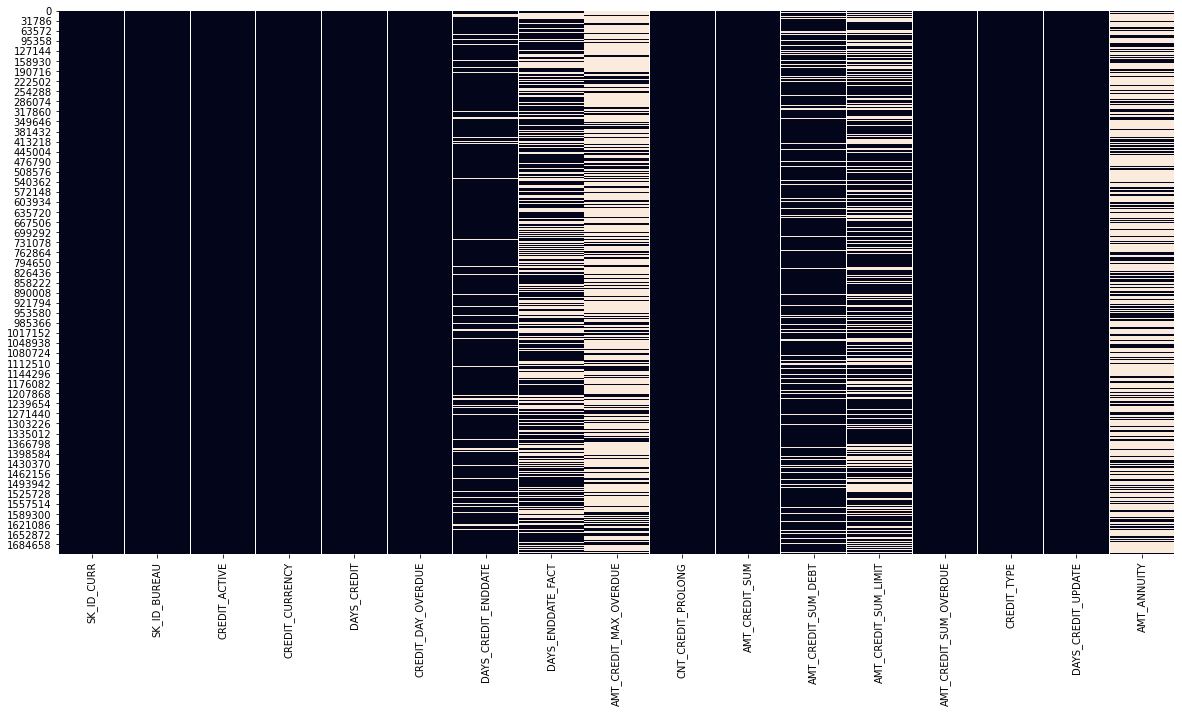

In [11]:
# Valeurs manquantes du dataframe
outils_data.get_missing_values(bureau, True, True)

Nombre de variables avec valeurs manquantes : 7


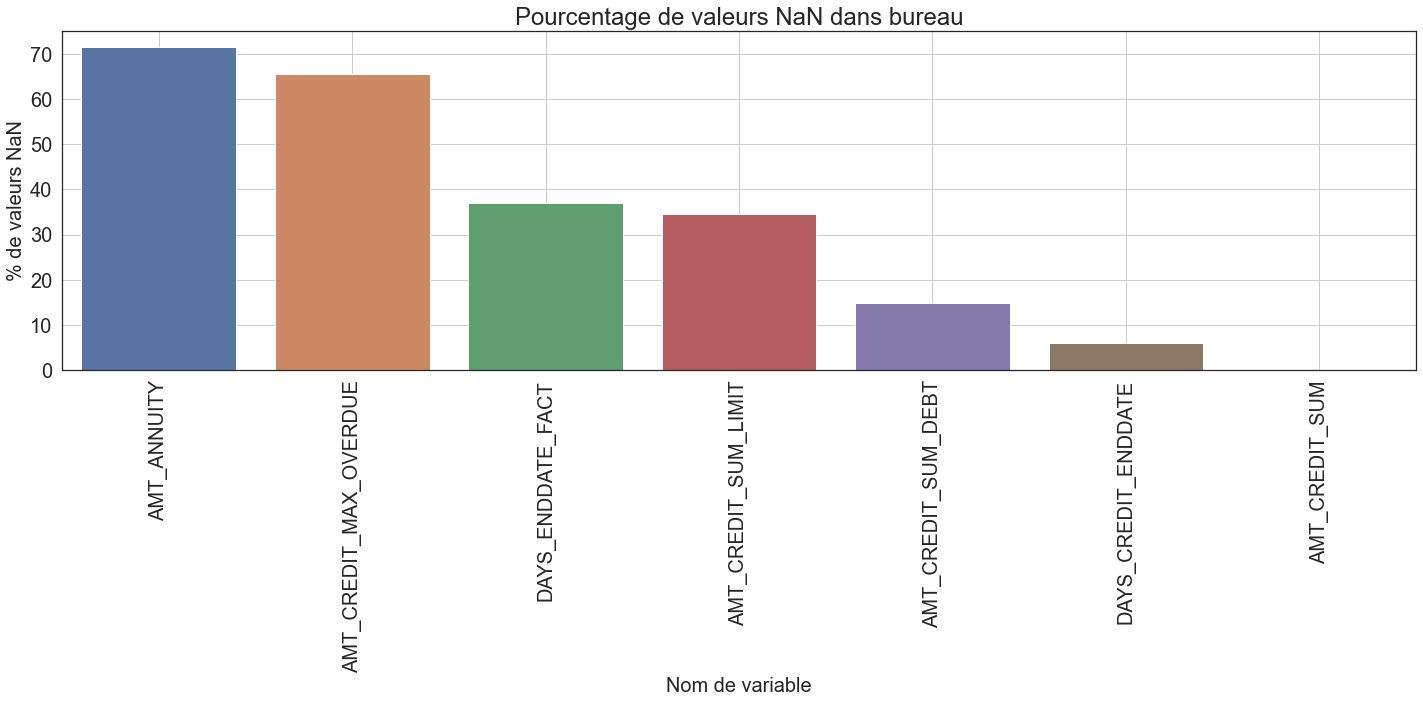

In [26]:
# Réprésentation visuelle des valeurs manquantes
df_nan_bureau = eda_kernel_fonctions.nan_df_create(bureau)
eda_kernel_fonctions.plot_nan_percent(df_nan_bureau, 'bureau',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))

**Bilan** :
***
- Sur les 17 variables, 7 contiennent des valeurs NaN.
- Les valeurs NaN les plus élevées sont observées avec la variable AMT_ANNUITY qui a plus de 70% de valeurs manquantes.

**Préparation du dataframe de travail**

In [6]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
print('Création dataframe de travail : merge TARGET avec dataframe bureau')
bureau_merged = application_train.iloc[:, :2].merge(bureau,
                                                    on='SK_ID_CURR',
                                                    how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe bureau
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>2.3.2. Analyse exploratoire univariée</span>

***
<span style='background:Plum'>**Distribution des variables catégorielles**</span>
***

Nous allons maintenant représenter graphiquement certaines des variables catégorielles du dataframe bureau, et voir leur impact sur la variable cible.

In [14]:
# Liste des variables qualitatives
cols_cat_bureau = \
    bureau.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_bureau

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

<span style='background:PaleGreen'>**Variable CREDIT_ACTIVE**</span>

Cette variable décrit l'état du prêt précédent rapporté par le bureau de crédit.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CREDIT_ACTIVE' sont :
['Closed' 'Active' nan 'Sold' 'Bad debt']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CREDIT_ACTIVE = 5


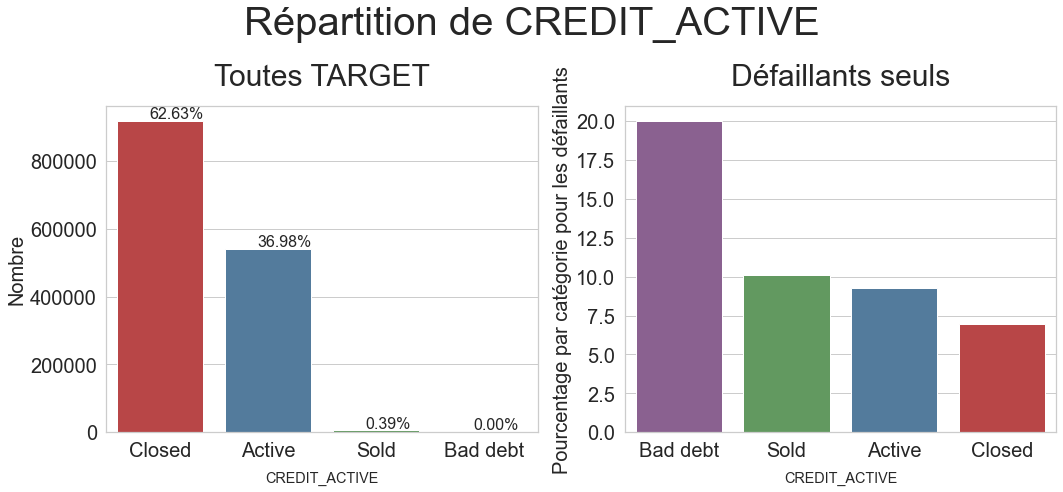

In [31]:
# Let us first see the unique categories of 'CREDIT_ACTIVE'
eda_kernel_fonctions.print_unique_categories(bureau_merged,
                                             'CREDIT_ACTIVE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(bureau_merged, column_name='CREDIT_ACTIVE',
                                   horizontal_adjust=0.3,
                                   figsize=(15, 7), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#905998', '#59a257',
                                             '#477ca8', '#cb3335'])

**Bilan** :
***
À partir du graphique ci-dessus, nous pouvons tirer les conclusions suivantes :

- Dans le premier sous-graphe, nous voyons que la majorité des prêts antérieurs d'autres institutions financières sont des prêts fermés (62,63%), suivis par 36,98% de prêts actifs. Les prêts vendus et les prêts pour créances douteuses sont très peu nombreux.
- Si nous examinons le pourcentage de défaillants par catégorie, nous constatons qu'environ 20 % des personnes ayant des créances douteuses ont fait défaut, ce qui représente le taux de défaillance le plus élevé. Cette catégorie est suivie par les prêts vendus et les prêts actifs. Le taux de défaillance le plus faible concerne les prêts fermés, qui témoignent d'un bon historique du demandeur. La courbe observée ici est donc tout à fait logique et attendue.

***Note*** :
***
Les 'Bad credit loans' sont destinés aux personnes dont le dossier de crédit est loin d'être irréprochable ou qui ont peu ou pas d'antécédents de crédit. Ces prêts ont généralement des taux d'intérêt plus élevés et des restrictions plus importantes que les autres prêts, car cela permet aux prêteurs de réduire le risque que vous ne les remboursiez pas. Cependant, ils peuvent être utiles s'ils sont gérés de manière responsable.

<span style='background:PaleGreen'>**Variable CREDIT_CURRENCY**</span>

Cette variable décrit devise recodée du crédit du bureau de crédit.

In [44]:
# Let us first see the unique categories of 'CREDIT_CURRENCY'
eda_kernel_fonctions.print_unique_categories(bureau_merged,
                                             'CREDIT_CURRENCY')

# Plotting the Pie Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_pie(bureau_merged,
                                   column_name='CREDIT_CURRENCY')

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CREDIT_CURRENCY' sont :
['currency 1' nan 'currency 2' 'currency 3' 'currency 4']
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CREDIT_CURRENCY' sont :
['currency 1' nan 'currency 2' 'currency 3' 'currency 4']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
currency 1    1464094
currency 2       1072
currency 3        150
currency 4          9
Name: CREDIT_CURRENCY, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CREDIT_CURRENCY = 5


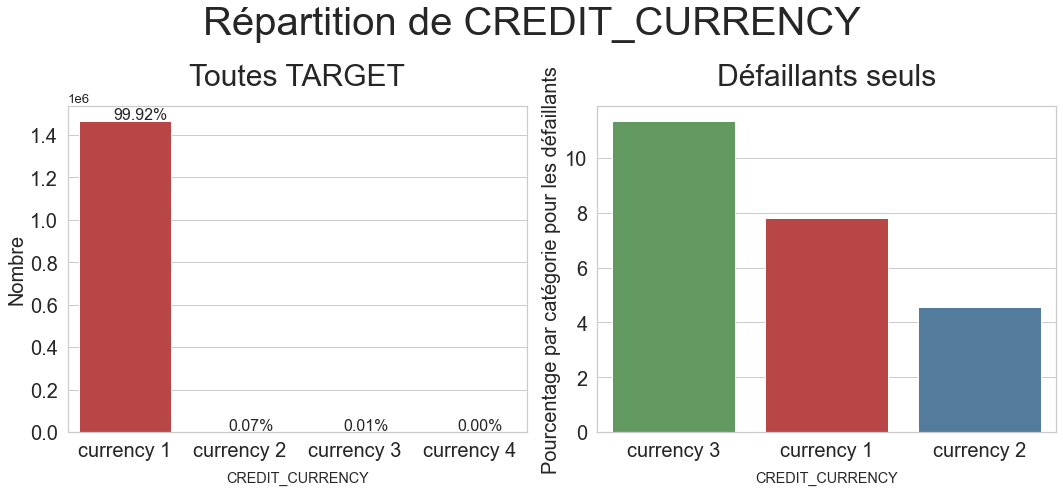

In [32]:
# Let us first see the unique categories of 'CREDIT_CURRENCY'
eda_kernel_fonctions.print_unique_categories(bureau_merged,
                                             'CREDIT_CURRENCY',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(bureau_merged,
                                   column_name='CREDIT_CURRENCY',
                                   horizontal_adjust=0.3,
                                   figsize=(15, 7), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#59a257', '#cb3335',
                                             '#477ca8'])

**Bilan** :
***
À partir du graphique ci-dessus, nous pouvons tirer les conclusions suivantes :

- Dans le premier sous-graphe, nous voyons que la majorité des devises utilisées sont 'currency_1'.
- Si nous examinons le pourcentage de défaillants par catégorie, nous constatons qu'environ 11,5 % des personnes ayant des prêts avec la devise 'currency_3' ont été défaillants, ce qui représente le taux de défaillance le plus élevé. Cette catégorie est suivie par les devises currency_1 (8%) et currency_2 (4%). 

Les personnes utilisant les devises currency_2 et currency_3 ont plus de possibilités d'être défaillants.

<span style='background:PaleGreen'>**Variable CREDIT_TYPE**</span>

Cette variable décrit le type de crédit au bureau de crédit (exemple :voiture, argent liquide...).

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CREDIT_TYPE' sont :
['Credit card' 'Consumer credit' nan 'Loan for business development'
 'Microloan' 'Mortgage' 'Car loan'
 'Loan for working capital replenishment' 'Another type of loan'
 'Unknown type of loan' 'Loan for the purchase of equipment'
 'Cash loan (non-earmarked)' 'Real estate loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)' 'Mobile operator loan']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CREDIT_TYPE = 16


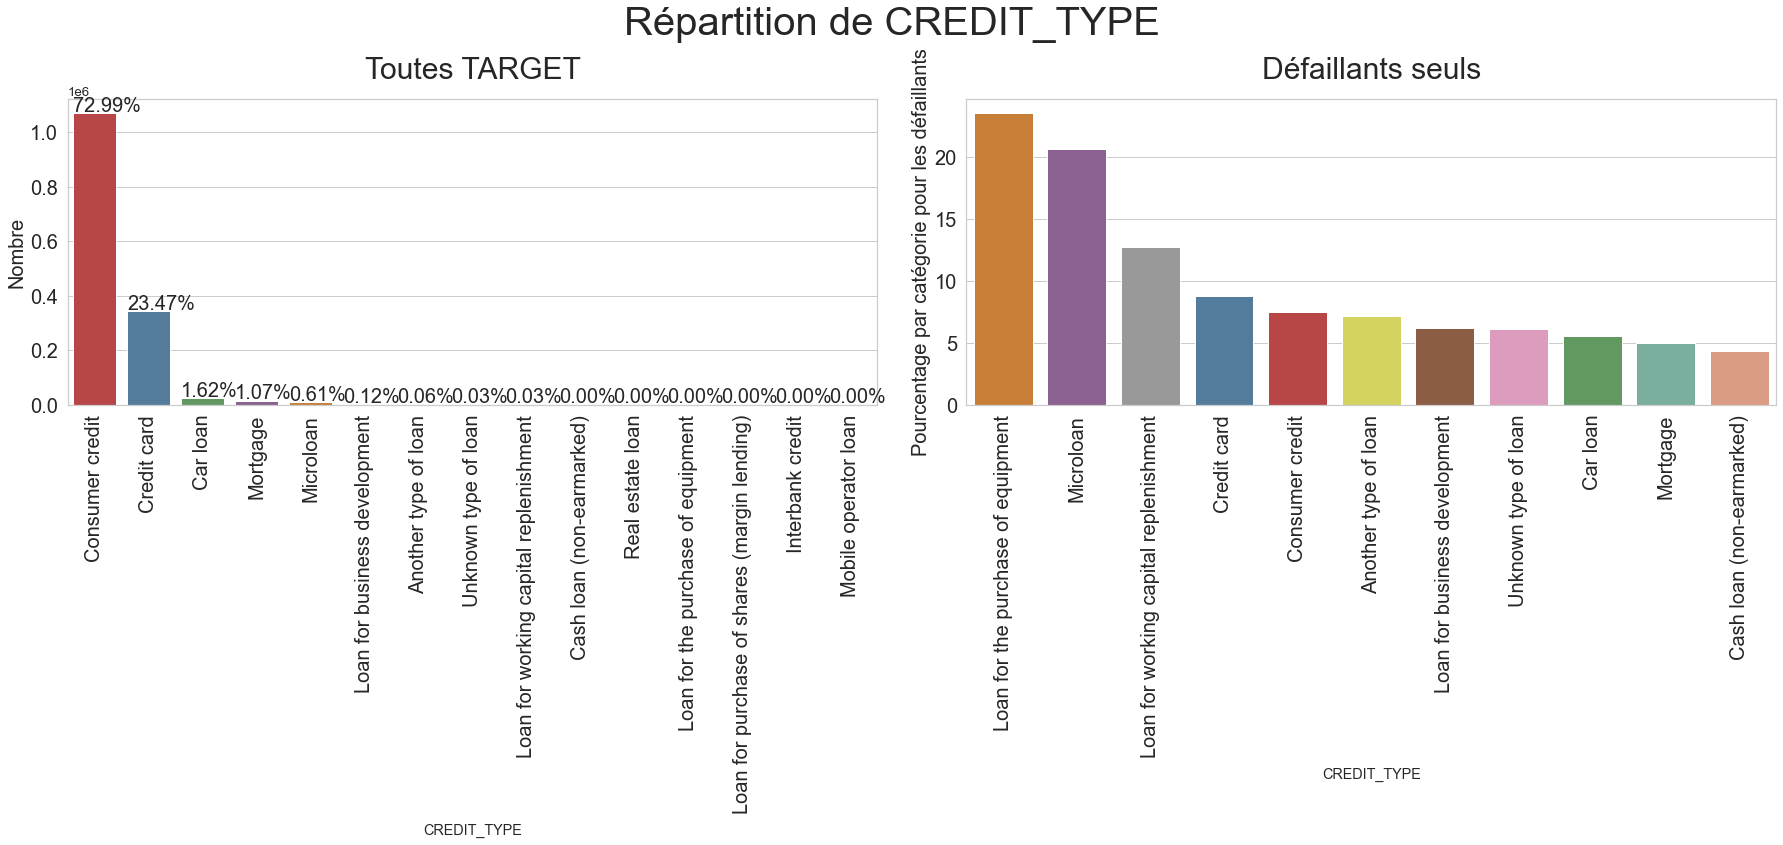

In [38]:
# Let us first see the unique categories of 'CREDIT_TYPE'
eda_kernel_fonctions.print_unique_categories(bureau_merged,
                                             'CREDIT_TYPE')

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(bureau_merged,
                                   column_name='CREDIT_TYPE',
                                   figsize=(25, 12), rotation=90,
                                   fontsize_percent=20,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999', '#72b6a1',
                                             '#e99675', '#95a3c3',
                                             '#db96c0', '#a2c865',
                                             '#e5c949'],
                                   palette2=['#df7f20', '#905998',
                                             '#999999', '#477ca8',
                                             '#cb3335', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#59a257', '#72b6a1',
                                             '#e99675'])

**Bilan** :
***
À partir du graphique ci-dessus, nous pouvons tirer les conclusions suivantes :

- Dans le premier sous-graphe, nous voyons que la majorité des types de prêts des prêts à la consommation ou des cartes de crédit.
- Les défaillants ont recours à d'autres types de crédits : 30% pour l'achat de matériel, 20% pour des micro-crédits et 12,5% pour la reconstitution du fonds de roulement. 

Peut-on en déduire que les défaillants sont plus des auto-entreprenants qui remplacent du matériel et ont besoin de trésorerie pour payer les fournisseurs?

***
<span style='background:Plum'>**Distribution des variables quantitatives**</span>
***

In [15]:
# Liste des variables quantitatives
cols_num_bureau = \
    bureau.select_dtypes(include=[np.number]).columns.to_list()
cols_num_bureau

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

<span style='background:PaleGreen'>**Variable DAYS_CREDIT**</span>

- Cette variable décrit le nombre de jours avant la demande actuelle, lorsque le demaneur a fait une demande de crédit au bureau de crédit.
- Pour faciliter l'interprétation, nous allons convertir ces jours en années.

-------------------------------------------------------------------------------
Pecentiles de la variable YEARS_CREDIT
Pecentile 0 = -0.0
Pecentile 25 = 1.2876712328767124
Pecentile 50 = 2.6986301369863015
Pecentile 75 = 4.578082191780822
Pecentile 90 = 6.706849315068493
Pecentile 92 = 6.945205479452055
Pecentile 94 = 7.183561643835617
Pecentile 96 = 7.4301369863013695
Pecentile 98 = 7.712328767123289
Pecentile 100 = 8.005479452054795
-------------------------------------------------------------------------------


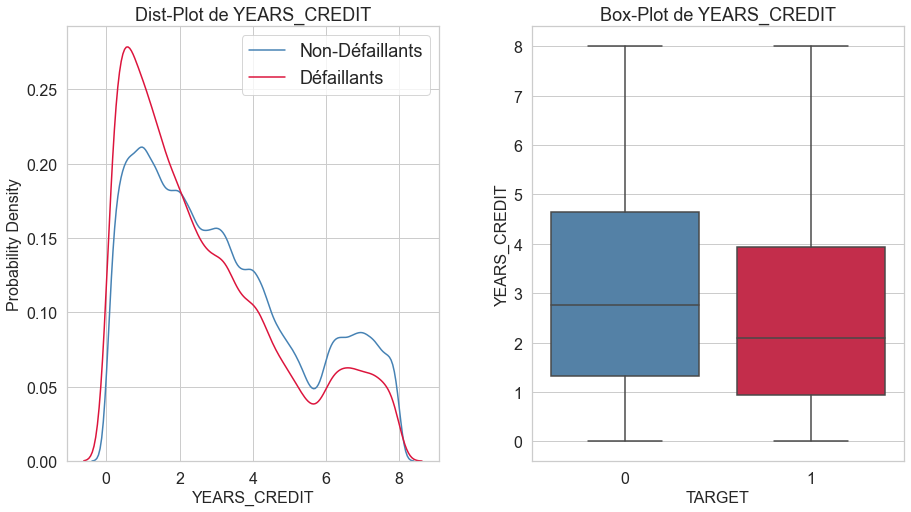

In [53]:
# Transformer en années à partir du nombre de jours
bureau_merged['YEARS_CREDIT'] = \
    bureau_merged['DAYS_CREDIT'] * -1 / 365
# Affiche les quantiles
eda_kernel_fonctions.print_percentiles(bureau_merged, 'YEARS_CREDIT')
# Affiche boxplot, distplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'YEARS_CREDIT',
                                               plots=['distplot', 'box'],
                                               figsize=(15, 8))
# Suppression de la variable nouvellement ajoutée
_ = bureau_merged.pop('YEARS_CREDIT')

**Bilan** :
***
A partir des graphiques ci-dessus, nous voyons que :

- D'après le PDF, nous constatons que les défaillants ont tendance à avoir des pics plus élevés que les non-défaillants lorsque le nombre d'années est inférieur. Cela implique que les demandeurs qui ont fait une demande de prêt au Bureau de crédit récemment ont montré une plus grande tendance à la défaillance que ceux qui ont fait une demande il y a longtemps. Le PDF des défaillants est également un peu plus à gauche que celui des non-défaillants.
- Sur le boxplot, nous voyons que les défaillants ont généralement moins d'années de crédit que les non-défaillants.

<span style='background:PaleGreen'>**Variable DAYS_CREDIT_ENDDATE**</span>

Cette variable indique la durée restante du crédit du Bureau de crédit au moment de la demande de prêt en crédit immobilier.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_CREDIT_ENDDATE
Pecentile 0 = -42060.0
Pecentile 2 = -2487.0
Pecentile 4 = -2334.0
Pecentile 6 = -2202.0
Pecentile 8 = -2073.9199999999983
Pecentile 10 = -1939.0
Pecentile 25 = -1144.0
Pecentile 50 = -334.0
Pecentile 75 = 473.0
Pecentile 100 = 31199.0
-------------------------------------------------------------------------------


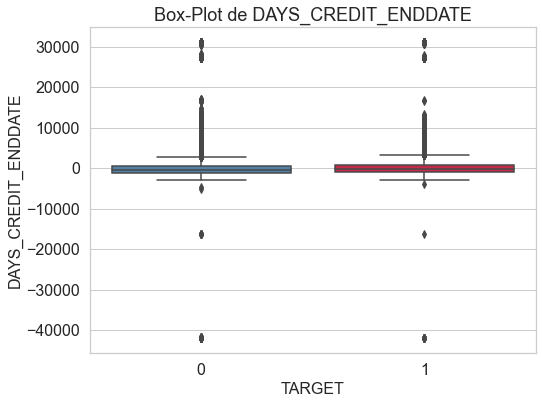

In [56]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'DAYS_CREDIT_ENDDATE',
                                               plots=['box'], figsize=(8, 6))

**Bilan** :
***
- À partir des valeurs de quantile ci-dessus, et en regardant le boxplot, nous constatons qu'il semble y avoir une valeur erronée pour DAYS_CREDIT_ENDDATE, où la valeur du 0e quantile remonte jusqu'à 42060 jours ou 115 ans. Cela n'a pas beaucoup de sens car cela implique que le précédent prêt du demandeur remonte à 115 ans. 
- Il pourrait également s'agir d'un prêt hérité, mais nous ne pouvons pas nous prononcer à ce sujet.

Nous essaierons d'éliminer ces valeurs lors de l'étape de prétraitement des données.

<span style='background:PaleGreen'>**Variable DAYS_ENDDATE_FACT**</span>

- Cette variable indique le nombre de jours depuis lesquels le crédit du Bureau de Credit a été clôturé au moment de la demande de prêt du crédit immobilier. 
- Ces valeurs ne concernent que les crédits fermés.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_ENDDATE_FACT
Pecentile 0 = -42023.0
Pecentile 2 = -2561.0
Pecentile 4 = -2450.0
Pecentile 6 = -2351.0
Pecentile 8 = -2265.0
Pecentile 10 = -2173.0
Pecentile 25 = -1503.0
Pecentile 50 = -900.0
Pecentile 75 = -427.0
Pecentile 100 = 0.0
-------------------------------------------------------------------------------


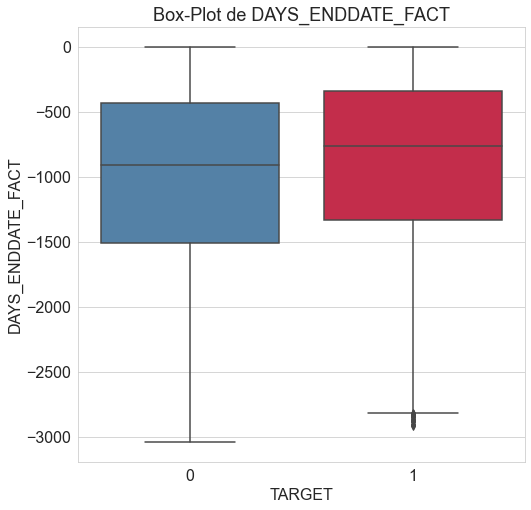

In [10]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'DAYS_ENDDATE_FACT',
                                               plots=['box'],
                                               figsize=(8, 8),
                                               scale_limits=[-40000, 0])

**Bilan** :
***
- Tout comme la colonne précédente, nous constatons que le 0e quantile de cette variable semble également erroné, soit 42023 jours ou ~115 ans. Nous devrions supprimer ces valeurs, car elles n'ont pas beaucoup de sens.
- Sur le boxplot, nous voyons que les défaillants ont tendance à avoir un nombre de jours inférieur depuis que leur crédit au Bureau du Crédit a pris fin. 
- Les non-défaillants ont généralement leur crédit précédent terminé plus longtemps avant que les défaillants.

<span style='background:PaleGreen'>**Variable DAYS_CREDIT_UPDATE**</span>

Cette variable indique le nombre de jours depuis lesquels l'information du Bureau de crédit est parvenue au moment de la demande de prêt dans le cadre du crédit immobilier.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_CREDIT_UPDATE
Pecentile 0 = -41947.0
Pecentile 2 = -2415.0
Pecentile 4 = -2213.0
Pecentile 6 = -2002.0
Pecentile 8 = -1766.0
Pecentile 10 = -1582.0
Pecentile 25 = -904.0
Pecentile 50 = -406.0
Pecentile 75 = -33.0
Pecentile 100 = 372.0
-------------------------------------------------------------------------------


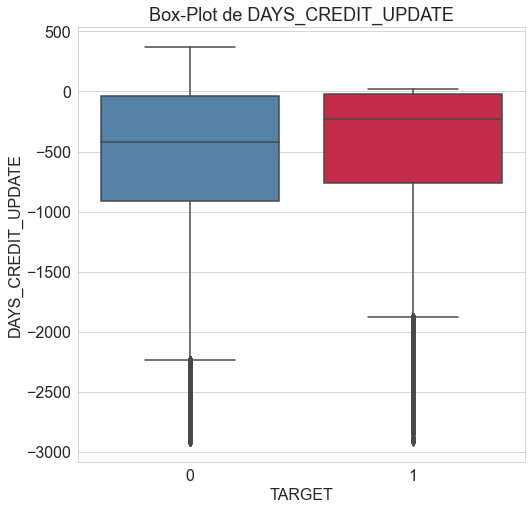

In [11]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'DAYS_CREDIT_UPDATE',
                                               plots=['box'],
                                               figsize=(8, 8),
                                               scale_limits=[-40000, 400])

**Bilan** :
***
- La tendance des valeurs erronées est à nouveau très similaire à celle de la variable des autres jours, où la valeur du 0e quantile semble être erronée. 
- De plus, étant donné que seule la valeur du 0e quantile est si étrange, et que le reste semble être correct, cette valeur est donc définitivement erronée. Nous allons également supprimer cette valeur.
- Sur le boxplot, on constate que les défaillants ont tendance à avoir moins de jours depuis la fin de leur crédit auprès du bureau de crédit.
- Leurs valeurs médianes, au 75e centile, sont toutes inférieures à celles des non défaillants.

<span style='background:PaleGreen'>**Variable CREDIT_DAY_OVERDUE**</span>

Nombre de jours de retard sur le crédit du Bureau de crédit au moment de la demande de prêt liée à notre échantillon.

-------------------------------------------------------------------------------
Pecentiles de la variable CREDIT_DAY_OVERDUE
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 0.0
Pecentile 100 = 2792.0
-------------------------------------------------------------------------------


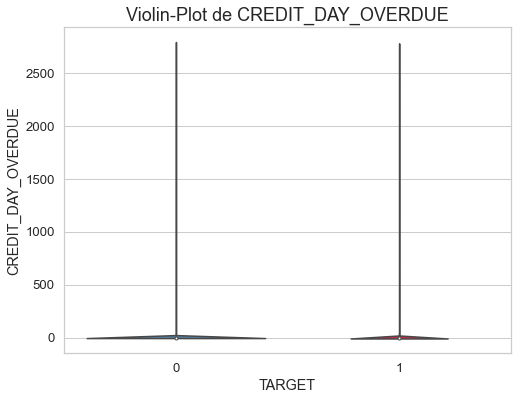

In [39]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'CREDIT_DAY_OVERDUE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'CREDIT_DAY_OVERDUE',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_MAX_OVERDUE**</span>

Montant maximal des impayés sur le crédit du Bureau de crédit jusqu'à présent (à la date de demande du prêt dans notre échantillon).

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_CREDIT_MAX_OVERDUE
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 0.0
Pecentile 100 = 115987185.0
-------------------------------------------------------------------------------


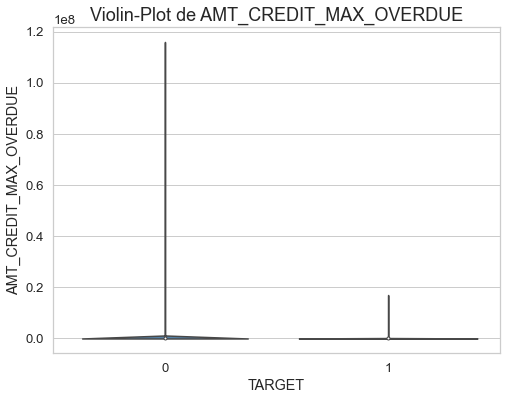

In [42]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'AMT_CREDIT_MAX_OVERDUE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'AMT_CREDIT_MAX_OVERDUE',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable CNT_CREDIT_PROLONG**</span>

Combien de fois le crédit du Bureau de crédit a-t-il été prolongé ?

-------------------------------------------------------------------------------
Pecentiles de la variable CNT_CREDIT_PROLONG
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 0.0
Pecentile 100 = 9.0
-------------------------------------------------------------------------------


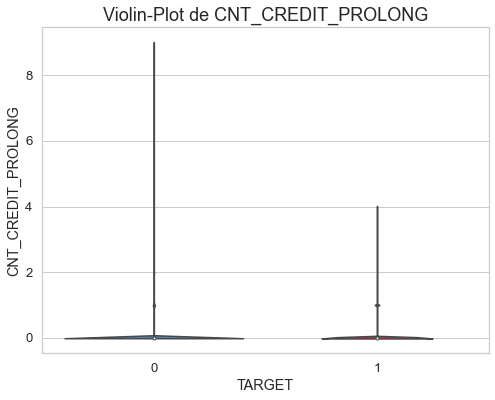

In [41]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'CNT_CREDIT_PROLONG',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'CNT_CREDIT_PROLONG',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_SUM**</span>

Montant actuel du crédit du Bureau de crédit.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_CREDIT_SUM
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 4500.0
Pecentile 6 = 14391.0
Pecentile 8 = 19514.88
Pecentile 10 = 22500.0
Pecentile 25 = 51165.0
Pecentile 50 = 124698.1275
Pecentile 75 = 308250.0
Pecentile 100 = 396000000.0
-------------------------------------------------------------------------------


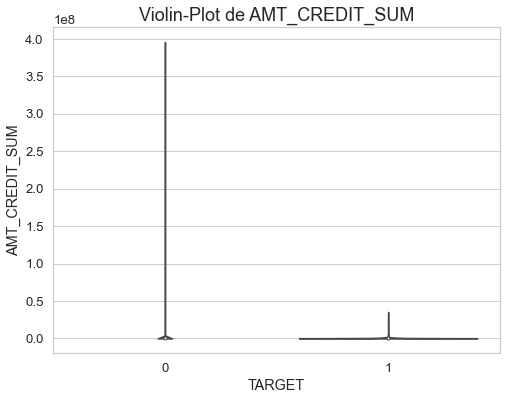

In [43]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'AMT_CREDIT_SUM',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'AMT_CREDIT_SUM',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_SUM_DEBT**</span>

Dette actuelle sur le crédit du Bureau de crédit.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_CREDIT_SUM_DEBT
Pecentile 0 = -4705600.32
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 39654.0
Pecentile 100 = 170100000.0
-------------------------------------------------------------------------------


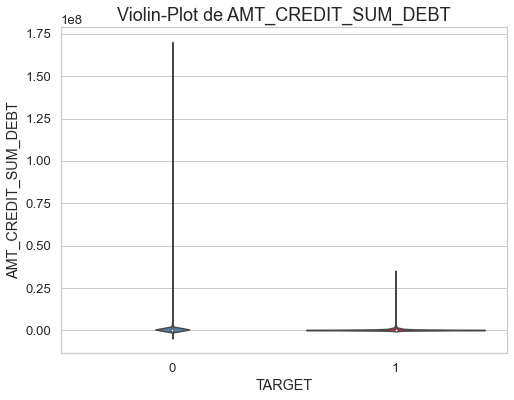

In [44]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'AMT_CREDIT_SUM_DEBT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'AMT_CREDIT_SUM_DEBT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_SUM_LIMIT**</span>

Limite de crédit actuelle de la carte de crédit déclarée dans le Bureau de crédit.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_CREDIT_SUM_LIMIT
Pecentile 0 = -586406.115
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 0.0
Pecentile 100 = 4705600.32
-------------------------------------------------------------------------------


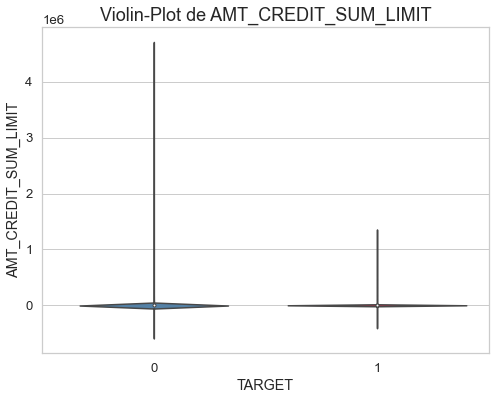

In [45]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'AMT_CREDIT_SUM_LIMIT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'AMT_CREDIT_SUM_LIMIT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_SUM_OVERDUE**</span>

Montant actuel en retard sur le crédit du Bureau de crédit.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_CREDIT_SUM_OVERDUE
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 0.0
Pecentile 100 = 3756681.0
-------------------------------------------------------------------------------


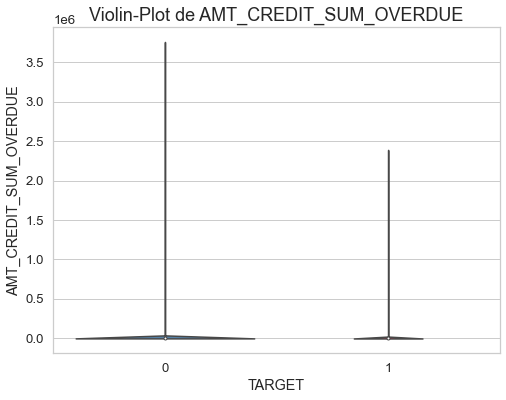

In [46]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'AMT_CREDIT_SUM_OVERDUE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'AMT_CREDIT_SUM_OVERDUE',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_ANNUITY**</span>

Annuité du crédit du Bureau de crédit.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_ANNUITY
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 67.5
Pecentile 75 = 13990.5
Pecentile 100 = 59586682.5
-------------------------------------------------------------------------------


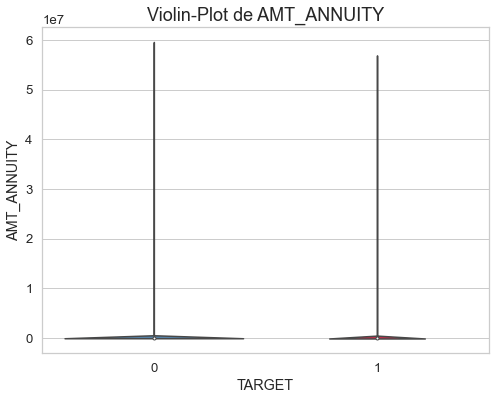

In [47]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_merged, 'AMT_ANNUITY',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(bureau_merged,
                                               'AMT_ANNUITY',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan**:
***
- Les différents quantiles ont pratiquement la même valeur pour les défaillants que pour les non-défaillants.

Cette variable ne sera guère utile pour départager les demandeurs défaillants ou non-défaillants.

#### <span style='background:Moccasin'>2.3.3. Analyse exploratoire multivariée</span>

<span style='background:PaleGreen'>**Corrélation entre les variables catégorielles**</span>

**Phi-K Matrix**

-------------------------------------------------------------------------------


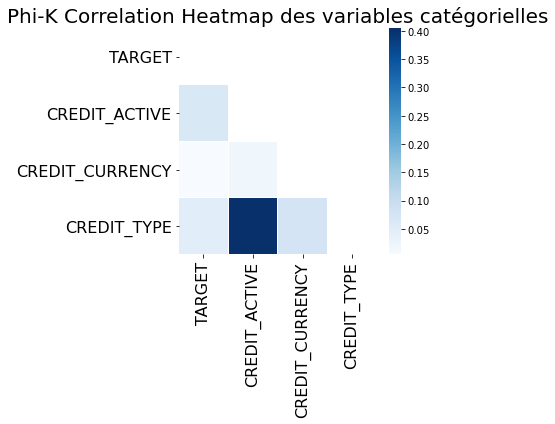

-------------------------------------------------------------------------------
Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :


-------------------------------------------------------------------------------


In [32]:
cols_for_phik = ['TARGET', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
                 'CREDIT_TYPE']
eda_kernel_fonctions.plot_phik_matrix(bureau_merged, cols_for_phik,
                                      figsize=(6, 6), fontsize=16)

**Bilan** :
***
La carte thermique ci-dessus montre les valeurs de corrélation Phi-K entre les valeurs catégorielles.

- D'après le coefficient de corrélation Phi-K, nous voyons que la variable CREDIT_TYPE présente une certaine association avec la variable CREDIT_ACTIVE.
- Nous voyons que les variables catégorielles n'ont pas vraiment une association élevée avec la variable TARGET, en particulier la caractéristique CREDIT_CURRENCY.

<span style='background:PaleGreen'>**Corrélation entre les variables numériques**</span>

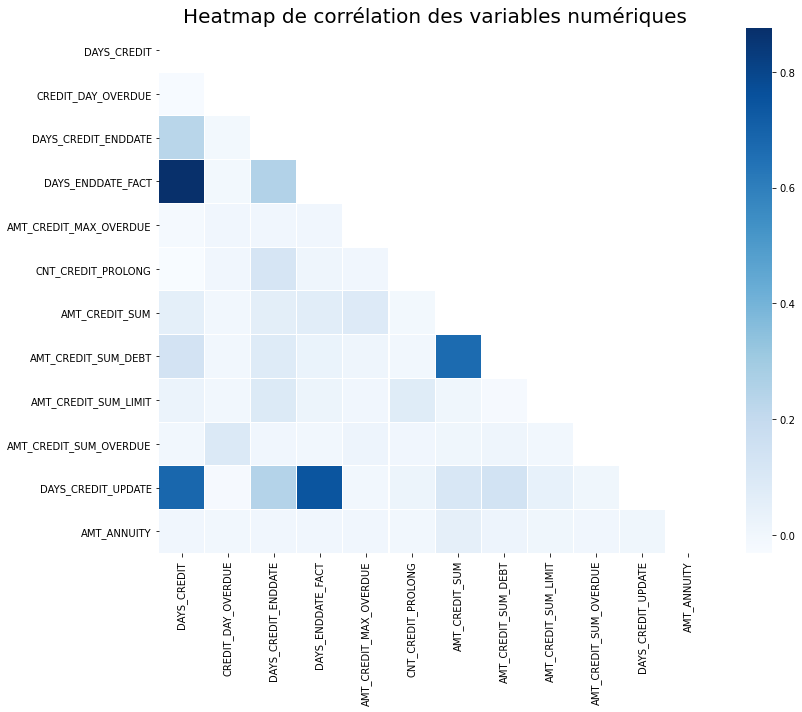

In [35]:
corr_mat = \
    eda_kernel_fonctions.correlation_matrix(bureau_merged,
                                            ['SK_ID_CURR', 'SK_ID_BUREAU'],
                                            cmap='Blues',
                                            figsize=(12, 10))
corr_mat.plot_correlation_matrix()

In [36]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT']
interval columns not set, guessing: ['TARGET', 'CREDIT_DAY_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_ENDDATE']
interval columns not set, guessing: ['TARGET', 'DAYS_ENDDATE_FACT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_MAX_OVERDUE']
interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_DEBT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_LIMIT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_UPDATE']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
-------------------------------------------------------------------------------
Les variables ayant les valeurs les plus élevées de Phik-corrélation avec la variable cible sont le

Column Name  Phik-Correlation
0              DAYS_CREDIT            0.0887
2      DAYS_CREDIT_ENDDATE            0.0190
9   AMT_CREDIT_SUM_OVERDUE            0.0057
8     AMT_CREDIT_SUM_LIMIT            0.0052
4   AMT_CREDIT_MAX_OVERDUE            0.0043
5       CNT_CREDIT_PROLONG            0.0039
1       CREDIT_DAY_OVERDUE            0.0025
10      DAYS_CREDIT_UPDATE            0.0022
7      AMT_CREDIT_SUM_DEBT            0.0017
6           AMT_CREDIT_SUM            0.0007

-------------------------------------------------------------------------------


**Bilan** :
***
- La carte thermique ci-dessus montre la corrélation entre chaque variables du dataframe bureau et le reste des variables.
- On peut observer que la plupart de la carte thermique a des couleurs claires, ce qui montre peu ou pas de corrélation.
- Cependant, nous pouvons voir quelques nuances foncées qui représentent une forte corrélation.
- La forte corrélation est particulièrement observée pour les variables :
    - DAYS_CREDIT et DAYS_CREDIT_UPDATE.
    - DAYS_ENDDATE_FACT et DAYS_CREDIT_UPDATE
    - AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT
    - DAYS_ENDDATE_FACT et DAYS_CREDIT
- Nous pouvons également constater que les variables ne présentent pas de corrélation particulièrement bonne/élevée avec la variable cible en tant que telle, à l'exception de la variable DAYS_CREDIT. 

Cela implique qu'il n'y a pas de relation linéaire directe entre la cible et les caractéristiques.

### <span style='background:PowderBlue'>2.4. Fichier bureau_balance.csv</span>

#### <span style='background:Moccasin'>2.4.1. Description/statistiques</span>

<span style='background:PaleGreen'>**Description**</span>

- Ce fichier **bureau_balance.csv** est constitué du solde mensuel de chaque crédit pour chacun des crédits précédents que le demandeur a eu avec des institutions financières autres que Home Credit.

<span style='background:PaleGreen'>**Compréhension des variables**</span>

In [37]:
df_var_bureau_bal = \
    HomeCredit_columns_description[HomeCredit_columns_description['Table']
                                   == 'bureau_balance.csv']
df_var_bureau_bal.style.hide_index()

In [ ]:
print("-"*79)
print(f'Number of unique SK_ID_BUREAU in bureau_balance.csv are: {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*79)
print(f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")
print('-'*79)
print(f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*79)

<span style='background:PaleGreen'>**Statistiques**</span>

In [38]:
eda_kernel_fonctions.afficher_stats_basic(bureau_balance, 'bureau_balance')

-------------------------------------------------------------------------------
Le jeu de données contient 27299925 lignes et 3 variables.
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans bureau_balance : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C

In [6]:
print("-"*79)
val = len(bureau_balance.SK_ID_BUREAU.unique())
print(f'Nombre de valeurs uniques SK_ID_BUREAU : {val}')
print('-'*79)
val1 = len(bureau_balance.STATUS.unique())
val2 = bureau_balance.STATUS.unique()
print(f'Nombre de valeurs uniques STATUS : {val1}')
print(f"Liste des valeurs uniques de STATUS :\n{val2}")
print('-'*79)
val3 = np.abs(bureau_balance.MONTHS_BALANCE.min())
print(f"Nombre maximal de mois pour le solde des mois : {val3}")
print('-'*79)

-------------------------------------------------------------------------------
Nombre de valeurs uniques SK_ID_BUREAU : 817395
-------------------------------------------------------------------------------
Nombre de valeurs uniques STATUS : 8
Liste des valeurs uniques de STATUS :
['C' '0' 'X' '1' '2' '3' '5' '4']
-------------------------------------------------------------------------------
Nombre maximal de mois pour le solde des mois : 96
-------------------------------------------------------------------------------


-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

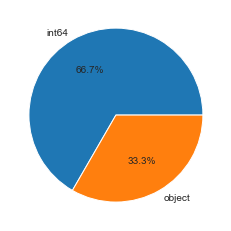

In [39]:
# Types des variables
outils_data.get_types_variables(bureau_balance, True, True, True)

In [40]:
# Résumé des variables
desc_bureau_bal = outils_data.description_variables(bureau_balance)
desc_bureau_bal

SK_ID_BUREAU MONTHS_BALANCE    STATUS
type          int64          int64    object
nb_nan          0.0            0.0       0.0
%_nan           0.0            0.0       0.0
count    27299925.0     27299925.0  27299925
unique          NaN            NaN         8
top             NaN            NaN         C
freq            NaN            NaN  13646993
mean    6036297.333       -30.7417       NaN
std     492348.8569        23.8645       NaN
min       5001709.0          -96.0       NaN
25%       5730933.0          -46.0       NaN
50%       6070821.0          -25.0       NaN
75%       6431951.0          -11.0       NaN
max       6842888.0            0.0       NaN

**Bilan** :
***
- Le fichier bureau_balance.csv contient environ 27,29 millions de lignes et 3 variables.
- Ce fichier contient le statut mensuel de chacun des prêts précédents pour un demandeur particulier, rapporté par le département du Bureau de crédit.
- Il y a 8 valeurs uniques pour le STATUS qui sont codées. Chacune d'entre elles a une signification particulière :
    - C signifie fermé,
    - X signifie statut inconnu,
    - 0 signifie pas de DPD,
    - 1 signifie DPD maximal pendant le mois entre 1-30,
    - 2 signifie DPD 31-60,...
    - 5 signifie DPD 120+ ou vendu ou radié.
- Le solde du mois le plus ancien que nous avons est le statut de 96 mois en arrière, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels ils existent.

<span style='background:PaleGreen'>**Valeurs manquantes**</span>

Valeurs manquantes : 0 NaN pour 81899775 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


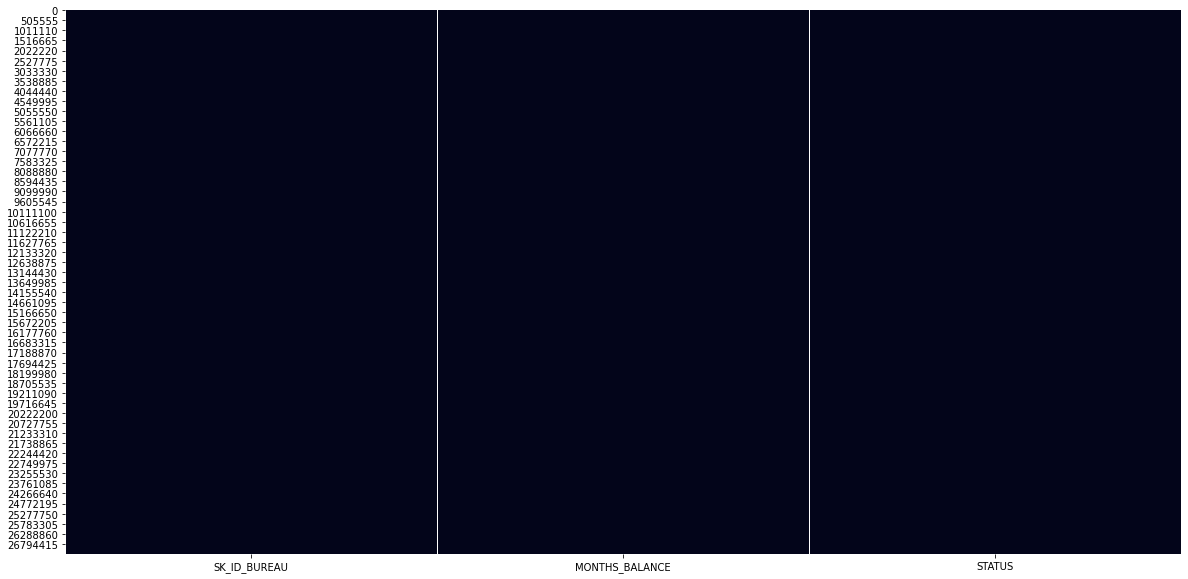

In [13]:
# Valeurs manquantes du dataframe
outils_data.get_missing_values(bureau_balance, True, True)

In [15]:
# Réprésentation visuelle des valeurs manquantes
df_nan_bureau_bal = eda_kernel_fonctions.nan_df_create(bureau_balance)
eda_kernel_fonctions.plot_nan_percent(df_nan_bureau_b+
                                      çiugvcal, 'bureau_balance',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))

Le dataframe bureau_balance ne contient pas de valeurs manquantes.


**Bilan** :
***
- Aucune donnée manquante.

**Préparation du dataframe de travail**

In [7]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
print('Création dataframe de travail : merge TARGET avec dataframe bureau')
bureau_merged = application_train.iloc[:, :2].merge(bureau,
                                                    on='SK_ID_CURR',
                                                    how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe bureau
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>2.4.2. Analyse exploratoire univariée</span>

***
<span style='background:Plum'>**Distribution des variables catégorielles**</span>
***

Nous allons maintenant représenter graphiquement certaines des variables catégorielles du dataframe bureau_balance, et voir leur impact sur la variable cible.

In [19]:
# Liste des variables qualitatives
cols_cat_bureau_bal = \
    bureau_balance.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_bureau_bal

['STATUS']

<span style='background:PaleGreen'>**Variable STATUS**</span>

Statut du prêt du Bureau du crédit durant le mois (actif ou fermé ou DPD0-30... :
- C signifie fermé,
- X signifie état inconnu,
- 0 signifie pas de DPD,
- 1 signifie DPD maximal durant le mois entre 1-30,
- 2 signifie DPD 31-60...,
- 5 signifie DPD 120+ ou vendu ou amorti.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'STATUS' sont :
['C' '0' 'X' '1' '2' '3' '5' '4']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour STATUS = 8


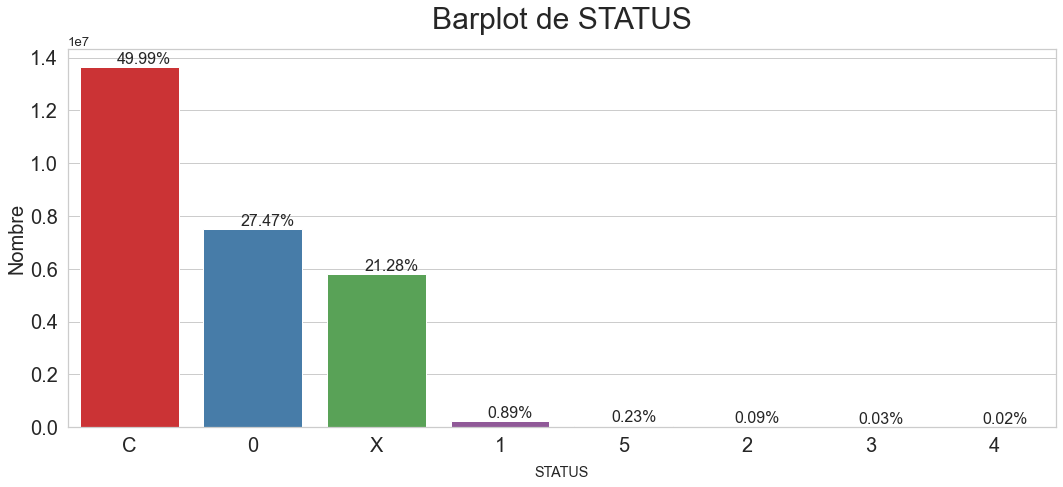

In [21]:
# Let us first see the unique categories of 'STATUS'
eda_kernel_fonctions.print_unique_categories(bureau_balance,
                                             'STATUS',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variable_bar(bureau_balance, column_name='STATUS',
                                  horizontal_adjust=0.3,
                                  figsize=(15, 7), fontsize_percent=16)

**Bilan** :
***
- Les états des prêts les plus rencontrés sont :
    - C pour prêt fermé (50%),
    - 0 pour 'pas de DPD' (27,5%),
    - X signifie état inconnu (21%).
    - le reste se partage entre les états 1 à 5.
- Plus de 21% des prêts sont dans l'état inconnu.

***
<span style='background:Plum'>**Distribution des variables quantitatives**</span>
***

In [22]:
# Liste des variables quantitatives
cols_num = \
    bureau_balance.select_dtypes(include=[np.number]).columns.to_list()
cols_num

['SK_ID_BUREAU', 'MONTHS_BALANCE']

<span style='background:PaleGreen'>**Variable MONTHS_BALANCE**</span>

- Mois du solde par rapport à la date de la demande :
    - -1 signifie que l'information correspond à l'instantané mensuel le plus récent 
    - 0 signifie que l'information correspond à la date de la demande 
- Il s'agit souvent de la même valeur que -1 car de nombreuses banques ne mettent pas régulièrement à jour les informations fournies au Bureau de crédit.

-------------------------------------------------------------------------------
Pecentiles de la variable MONTHS_BALANCE
Pecentile 0 = -96.0
Pecentile 2 = -87.0
Pecentile 4 = -81.0
Pecentile 6 = -76.0
Pecentile 8 = -72.0
Pecentile 10 = -68.0
Pecentile 25 = -46.0
Pecentile 50 = -25.0
Pecentile 75 = -11.0
Pecentile 100 = 0.0
-------------------------------------------------------------------------------


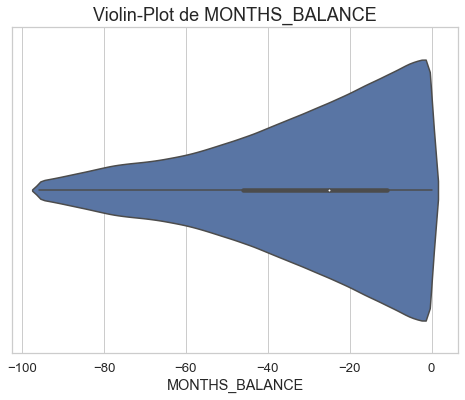

In [28]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(bureau_balance, 'MONTHS_BALANCE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variable(bureau_balance,
                                              'MONTHS_BALANCE',
                                              plots=['violin'],
                                              figsize=(8, 6))

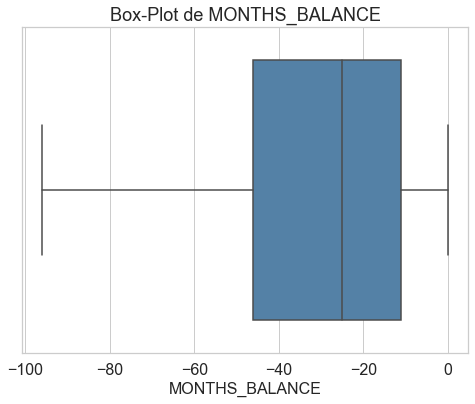

In [29]:
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variable(bureau_balance,
                                              'MONTHS_BALANCE',
                                              plots=['box'],
                                              figsize=(8, 6))

**Bilan**:
***
- La médiane est à -25 mois.

### <span style='background:PowderBlue'>2.5. Fichier credit_card_balance.csv</span>

#### <span style='background:Moccasin'>2.5.1. Description/statistiques</span>

<span style='background:PaleGreen'>**Description**</span>

- Ce fichier **credit_card_balance.csv** comprend les données mensuelles relatives à une ou plusieurs cartes de crédit que le demandeur avait auprès de Home Credit Group.
- Le fichier contient des champs tels que le solde, la limite de crédit, le montant des prélèvements, etc. pour chaque mois de la carte de crédit.

<span style='background:PaleGreen'>**Compréhension des variables**</span>

In [42]:
df_var_ccbal = \
    HomeCredit_columns_description[HomeCredit_columns_description['Table']
                                   == 'credit_card_balance.csv']
df_var_ccbal.style.hide_index()

<span style='background:PaleGreen'>**Statistiques**</span>

In [16]:
application_train.name = 'application_train'
application_test.name = 'application_test'
cc_balance.name = 'credit_card_balance'
eda_kernel_fonctions. \
    afficher_stats_basic_all(cc_balance, application_train,
                             application_test, 'SK_ID_PREV')

-------------------------------------------------------------------------------
Le jeu de données contient 3840312 lignes et 23 variables.
-------------------------------------------------------------------------------
Nombre de valeurs uniques SK_ID_PREV dans credit_card_balance.csv : 104307
Nombre de valeurs uniques SK_ID_CURR dans credit_card_balance.csv : 103558
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et credit_card_balance.csv : 86905
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et credit_card_balance.csv : 16653
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans credit_card_balance.csv : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  \
0     2562384      378907              -6       56.970                   135000                       0.0                 877.5                         0.0                     877.5                 1700.325               1800.0                     1800.0                     0.000          0.000   
1     2582071      363914              -1    63975.555                    45000                    2250.0                2250.0                         0.0                       0.0                 2250.000               2250.0                     2250.0                 60175.080      64875.555   
2     1740877      371185              -7    31815.225                   450000                       0.0                   0.0                         0.0                       0.0                 2250.000               2250.0                     2250.0                 26926.425      31460.085   
3     1389973      337855              -4   236572.110                   225000                    2250.0                2250.0                         0.0                       0.0                11795.760              11925.0                    11925.0                224949.285     233048.970   
4     1891521      126868              -1   453919.455                   450000                       0.0               11547.0                         0.0                   11547.0                22924.890              27000.0                    27000.0                443044.395     453919.455   

   AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                 0.000                       0.0                     1                         0.0                       1.0                       35.0               Active       0           0  
1             64875.555                       1.0                     1                         0.0                       0.0                       69.0               Active       0           0  
2             31460.085                       0.0                     0                         0.0                       0.0                       30.0               Active       0           0  
3            233048.970                       1.0                     1                         0.0                       0.0                       10.0               Active       0           0  
4            453919.455                       0.0                     1                         0.0                       1.0                      101.0               Active       0           0

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

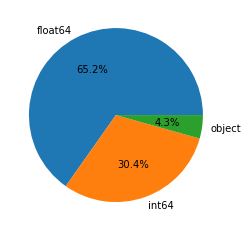

In [17]:
# Types des variables
outils_data.get_types_variables(cc_balance, True, True, True)

In [18]:
# Résumé des variables
desc_bureau = outils_data.description_variables(cc_balance)
desc_bureau

SK_ID_PREV   SK_ID_CURR MONTHS_BALANCE  AMT_BALANCE AMT_CREDIT_LIMIT_ACTUAL AMT_DRAWINGS_ATM_CURRENT AMT_DRAWINGS_CURRENT AMT_DRAWINGS_OTHER_CURRENT AMT_DRAWINGS_POS_CURRENT AMT_INST_MIN_REGULARITY AMT_PAYMENT_CURRENT AMT_PAYMENT_TOTAL_CURRENT AMT_RECEIVABLE_PRINCIPAL AMT_RECIVABLE  \
type           int64        int64          int64      float64                   int64                  float64              float64                    float64                  float64                 float64             float64                   float64                  float64       float64   
nb_nan           0.0          0.0            0.0          0.0                     0.0                 749816.0                  0.0                   749816.0                 749816.0                305236.0            767988.0                       0.0                      0.0           0.0   
%_nan            0.0          0.0            0.0          0.0                     0.0                   0.8489                  0.0                     0.8489                   0.8489                  0.3456              0.8695                       0.0                      0.0           0.0   
count      3840312.0    3840312.0      3840312.0    3840312.0               3840312.0                3090496.0            3840312.0                  3090496.0                3090496.0               3535076.0           3072324.0                 3840312.0                3840312.0     3840312.0   
unique           NaN          NaN            NaN          NaN                     NaN                      NaN                  NaN                        NaN                      NaN                     NaN                 NaN                       NaN                      NaN           NaN   
top              NaN          NaN            NaN          NaN                     NaN                      NaN                  NaN                        NaN                      NaN                     NaN                 NaN                       NaN                      NaN           NaN   
freq             NaN          NaN            NaN          NaN                     NaN                      NaN                  NaN                        NaN                      NaN                     NaN                 NaN                       NaN                      NaN           NaN   
mean    1904503.5899  278324.2073       -34.5219   58300.1553             153807.9574                5961.3248            7433.3882                   288.1696                2968.8048               3540.2041          10280.5377                 7588.8567               55965.8769    58088.8112   
std      536469.4706  102704.4751        26.6678   106307.031             165145.6995               28225.6886           33846.0773                  8201.9893                20796.887               5600.1541           36078.085                32005.9878              102533.6168   105965.3699   
min        1000018.0     100006.0          -96.0  -420250.185                     0.0                 -6827.31             -6211.62                        0.0                      0.0                     0.0                 0.0                       0.0               -423305.82   -420250.185   
25%        1434385.0     189517.0          -55.0          0.0                 45000.0                      0.0                  0.0                        0.0                      0.0                     0.0              152.37                       0.0                      0.0           0.0   
50%        1897122.0     278396.0          -28.0          0.0                112500.0                      0.0                  0.0                        0.0                      0.0                     0.0              2702.7                       0.0                      0.0           0.0   
75%       2369327.75     367580.0          -11.0   89046.6862                180000.0                      0.0                  0.0                        0.0    

**Bilan** :
***
- Il y a environ 3,84 millions de lignes dans le fichier credit_card_balance.csv, chacune d'entre elles correspondant au statut mensuel de la carte de crédit que le demandeur avait auprès de Home Credit Group.
- Cette table contient 23 variables qui contiennent les statistiques sur le statut de la carte de crédit de chaque mois, comme le montant du solde, le montant des retraits, le nombre de retraits, le statut, etc.
- Il y a 104300 cartes de crédit uniques dont les détails figurent dans ce tableau.
- Sur ces 104300, il y a 103500 SK_ID_CURR uniques.
- Cela signifie que la plupart des demandeurs n'avaient qu'une seule carte de crédit avec eux, et que seuls quelques-uns en avaient plus d'une.
- Ces SK_ID_CURR sont les ID des demandeurs qui ont actuellement demandé un prêt.
- Sur les 103000 SK_ID_CURR uniques, 86900 de ces demandeurs appartiennent à l'ensemble de formation et 16600 à l'ensemble de demandes de test.
- Sur les 307000 demandeurs du fichier application_train.csv, seuls 86900 d'entre eux avaient déjà une carte de crédit avec Home Credit Group.

<span style='background:PaleGreen'>**Valeurs manquantes**</span>

Valeurs manquantes : 5877356 NaN pour 88327176 données (6.65 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


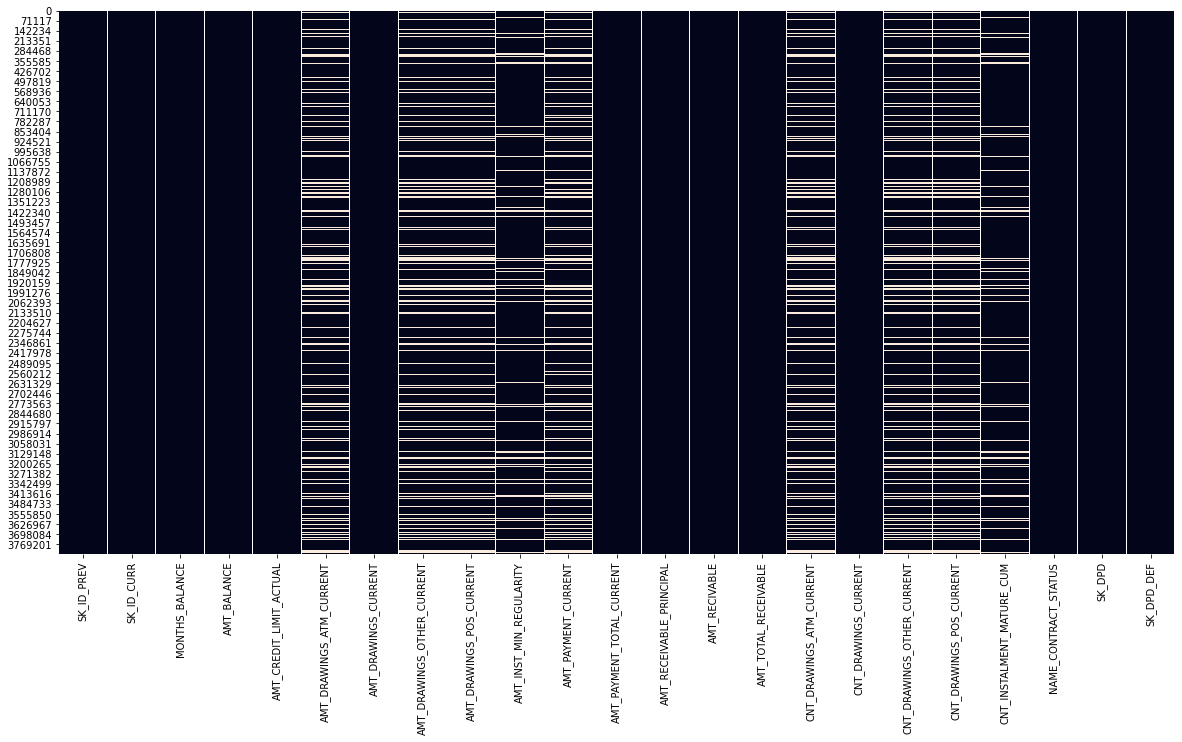

In [19]:
# Valeurs manquantes du dataframe
outils_data.get_missing_values(cc_balance, True, True)

Nombre de variables avec valeurs manquantes : 9


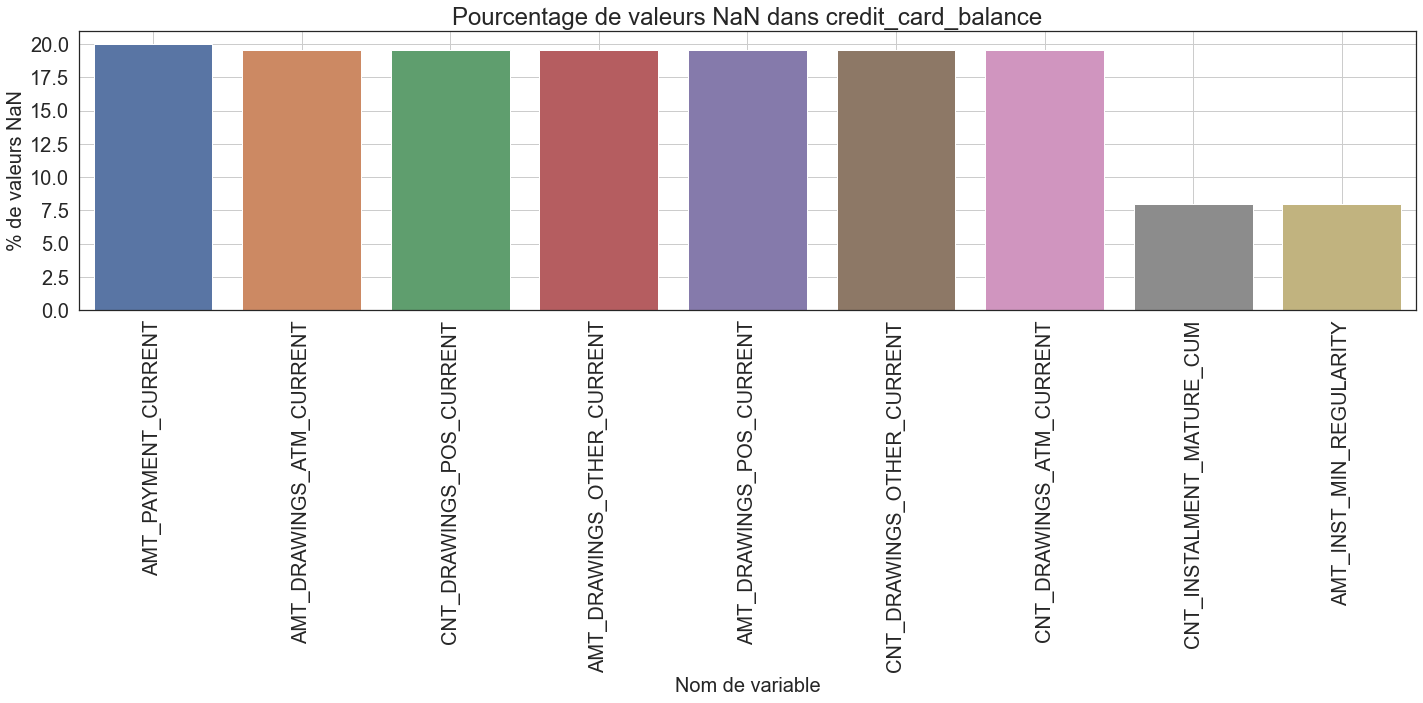

In [24]:
# Réprésentation visuelle des valeurs manquantes
df_nan_ccbal = eda_kernel_fonctions.nan_df_create(cc_balance)
eda_kernel_fonctions.plot_nan_percent(df_nan_ccbal, 'credit_card_balance',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))

**Bilan** :
***
- Sur les 23 variables, 9 d'entre elles contiennent des valeurs NaN.
- Si nous regardons les pourcentages de valeurs NaN, ils sont considérablement inférieurs au reste des tableaux que nous avons vus jusqu'à présent.
- 7 de ces variables ont près de 20% de valeurs NaN.
- Ces variables sont principalement liées aux montants des tirages et aux nombres de tirages.
- Les deux autres caractéristiques sont liées aux statistiques sur les versements.

**Préparation du dataframe de travail**

In [8]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
print('Création dataframe de travail : merge TARGET avec dataframe cc_balance')
cc_balance_merged = application_train.iloc[:, :2].merge(cc_balance,
                                                        on='SK_ID_CURR',
                                                        how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe cc_balance
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>2.5.2. Analyse exploratoire univariée</span>

***
<span style='background:Plum'>**Distribution des variables catégorielles**</span>
***

Nous allons maintenant représenter graphiquement certaines des variables catégorielles du dataframe credit_card_balance.csv, et voir leur impact sur la variable cible.

In [32]:
# Liste des variables qualitatives
cols_cat_ccbal = \
    cc_balance_merged.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_ccbal

['NAME_CONTRACT_STATUS']

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_STATUS**</span>

État du contrat au cours du mois.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
[nan 'Active' 'Completed' 'Signed' 'Sent proposal' 'Refused' 'Demand'
 'Approved']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Active           3116673
Completed         100031
Signed              9939
Demand               843
Sent proposal        460
Refused               14
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 8


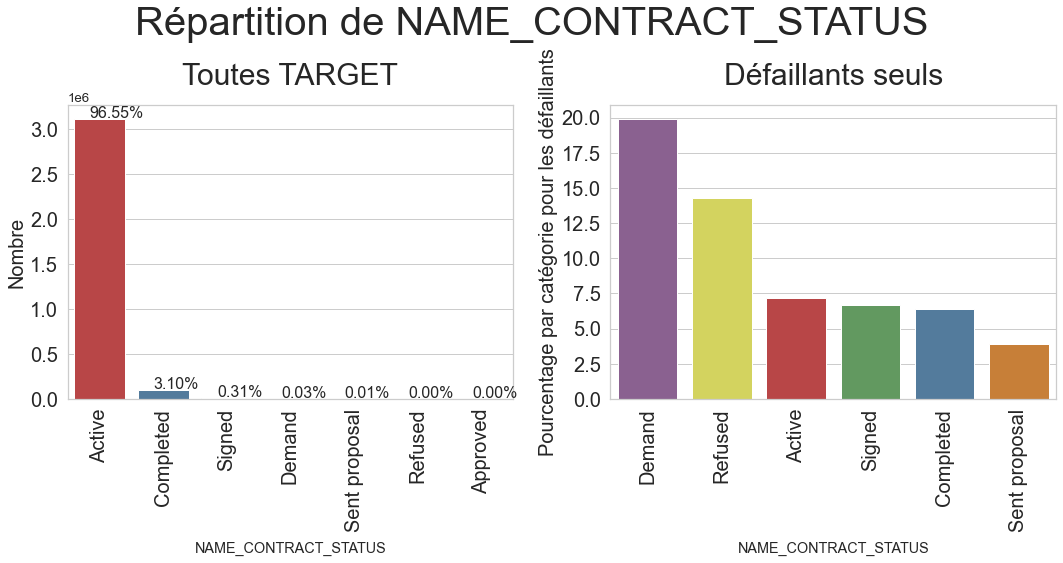

In [48]:
# Let us first see the unique categories of 'NAME_CONTRACT_STATUS'
eda_kernel_fonctions.print_unique_categories(cc_balance_merged,
                                             'NAME_CONTRACT_STATUS',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(cc_balance_merged,
                                   column_name='NAME_CONTRACT_STATUS',
                                   figsize=(15, 8), rotation=90,
                                   horizontal_adjust=0.25,
                                   fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38'],
                                   palette2=['#905998', '#e6e64c',
                                             '#cb3335', '#59a257',
                                             '#477ca8', '#df7f20'])

**Bilan** :
***
- La majorité des états des contrats des prêts sont Actif ou Terminé.
- Pour les défaillants, l'état des contrat sont demandé, réfusé puis actif ou signé.
- Les non-défaillants ont plus de prêts actifs que les défaillants.

***
<span style='background:Plum'>**Distribution des variables quantitatives**</span>
***

In [39]:
# Liste des variables quantitatives
cols_num = \
    cc_balance_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

Tout d'abord, nous allons regrouper par le champ 'SK_ID_PREV' et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du demandeur.

In [40]:
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()

<span style='background:PaleGreen'>**Variable AMT_BALANCE**</span>

Cette variable indique le montant moyen du solde qu'une personne avait habituellement sur son compte de carte de crédit pour le prêt précédent.

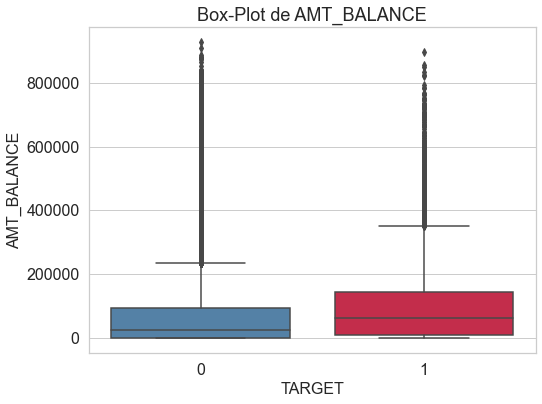

In [42]:
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_BALANCE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Le graphique ci-dessus montre que les défaillants ont une valeur d'AMT_BALANCE plus élevée que les non-défaillants. Ils présentent des valeurs plus élevées pour tous les quantiles et même pour les moustaches. Cela pourrait signifier que le montant du crédit pour les défaillants pourrait aussi être relativement plus élevé que pour les non-défaillants.
- Nous constatons que les défaillants semblent ici aussi avoir un versement minimum plus élevé chaque mois par rapport aux non défaillants. Cela renseigne généralement sur les habitudes de dépense et d'emprunt des personnes. Les défaillants ont des habitudes de dépenses et d'emprunt plus élevées que les non défaillants.

<span style='background:PaleGreen'>**Variable AMT_TOTAL_RECEIVABLE**</span>

Cette variable décrit la moyenne du montant total à recevoir sur le crédit précédent.

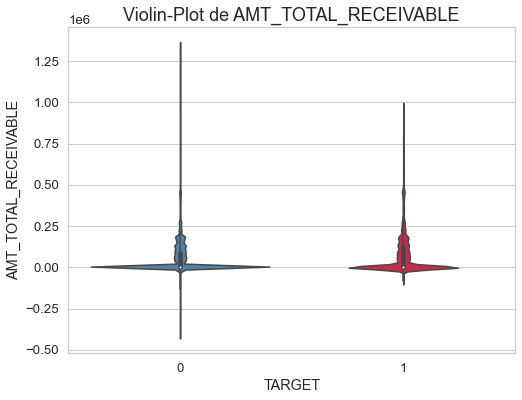

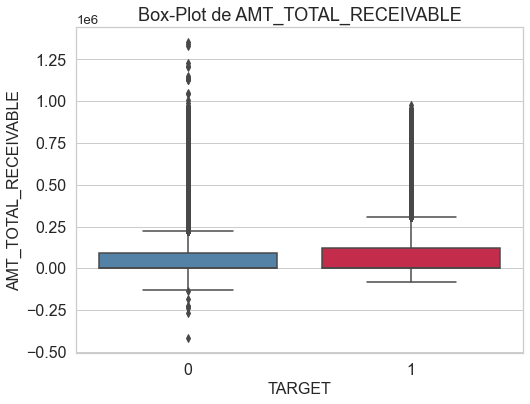

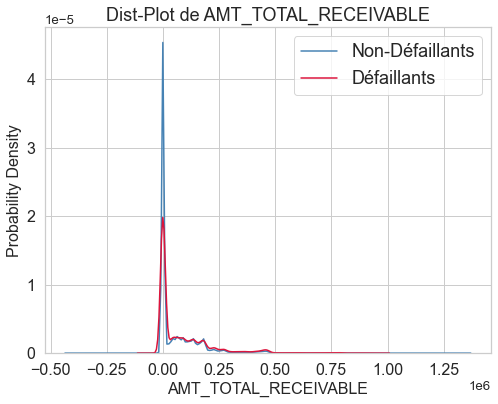

In [49]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_TOTAL_RECEIVABLE',
                                               plots=['violin'],
                                               figsize=(8, 6))
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_TOTAL_RECEIVABLE',
                                               plots=['box'],
                                               figsize=(8, 6))
# Affiche PDF
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_BALANCE',
                                               plots=['distplot'],
                                               figsize=(8, 6))

**Bilan** :
***
- En regardant le boxplot d'AMT_TOTAL_RECEIVABLE, nous constatons un comportement similaire à celui observé pour les autres montants, à savoir que les défaillants ont généralement un montant à recevoir plus élevé pour leur crédit précédent, ce qui peut impliquer des montants plus élevés de crédits qu'ils ont pu prendre.
- Le PDF montre également un pic très élevé à des montants inférieurs pour les non-défaillants par rapport aux défaillants.

<span style='background:PaleGreen'>**Variable CNT_INSTALMENT_MATURE_CUM**</span>

La variable décrit le nombre moyen de versements effectués sur les crédits précédents.

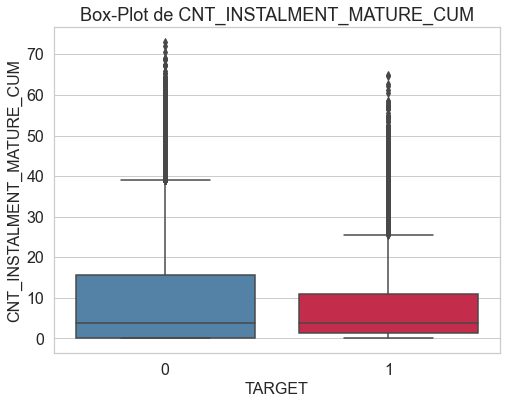

In [46]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'CNT_INSTALMENT_MATURE_CUM',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
Le graphique ci-dessus montre un comportement très intéressant. Ce graphique montre que les non-défaillants ont généralement une fourchette de valeurs plus élevée pour le nombre de versements payés que les défaillants. Cela pourrait montrer le comportement des défaillants, qui paient généralement moins d'acomptes sur leur crédit précédent.

<span style='background:PaleGreen'>**Variable MONTHS_BALANCE**</span>

Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente).

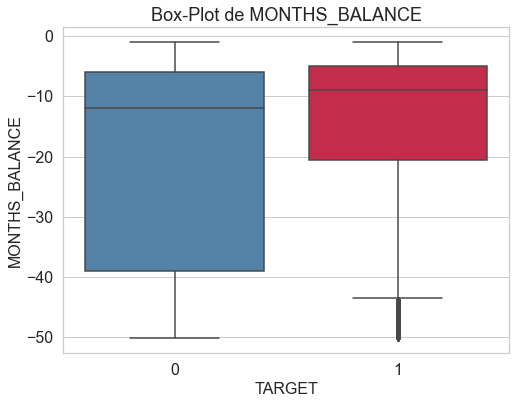

In [47]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'MONTHS_BALANCE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Le mois du solde des défaillants sont plus récent que celui des non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_LIMIT_ACTUAL**</span>

Limite de la carte de crédit au cours du mois du crédit précédent.

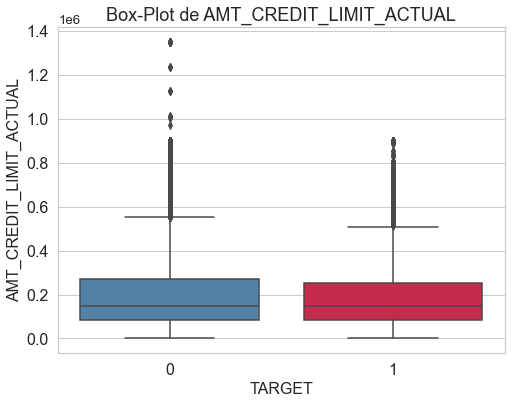

In [48]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_CREDIT_LIMIT_ACTUAL',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- La limite de la carte de crédit est légèrement inférieure pour les non-défailants.

<span style='background:PaleGreen'>**Variable AMT_DRAWINGS_ATM_CURRENT**</span>

Montant retiré au guichet automatique pendant le mois du crédit précédent.

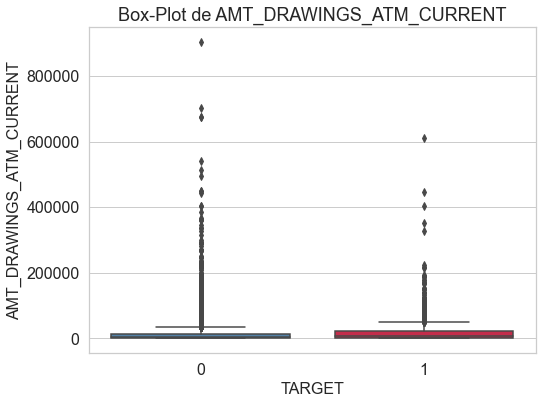

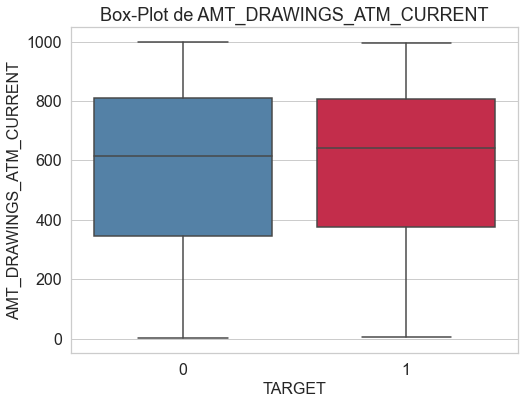

In [50]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_ATM_CURRENT',
                                               plots=['box'],
                                               figsize=(8, 6))
# Zoom
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_ATM_CURRENT',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[0, 1000])

**Bilan** :
***
- Le montant retiré au guichet automatique pendant le mois du crédit précédent est légèrement supérieur pour les défaillants que les non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_DRAWINGS_CURRENT**</span>

Montant prélevé au cours du mois du crédit précédent.

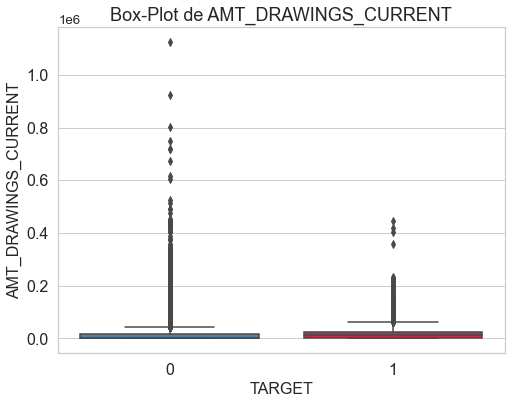

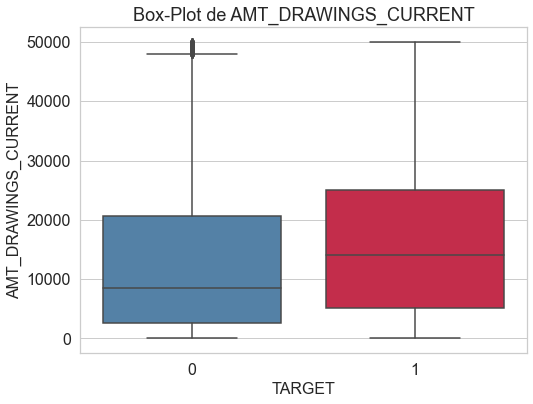

In [54]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_CURRENT',
                                               plots=['box'],
                                               figsize=(8, 6))
# Zoom
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_CURRENT',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[0, 0.05e6])

**Bilan** :
***
- Le montant prélevé au cours du mois du crédit précédent est supérieur pour les défaillants que pour les non-défaillants. Les défaillants font plus de dépenses que les non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_DRAWINGS_OTHER_CURRENT**</span>

Montant des autres prélèvements au cours du mois du crédit précédent

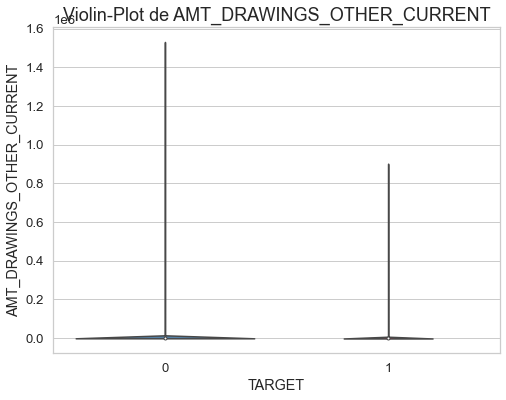

In [51]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_OTHER_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
 - Plus de petits montants prélevés pour défaillants que les non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_DRAWINGS_POS_CURRENT**</span>

Montant des prélèvements ou des achats de marchandises au cours du mois du crédit précédent.

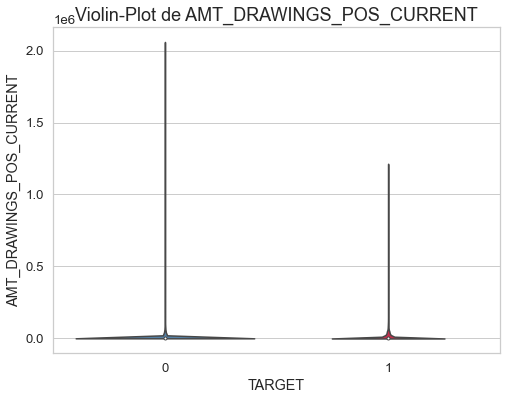

In [52]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_POS_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Les petits montants des prélèvements ou des achats de marchandises au cours du mois de la crédibilité précédente sont plus nombreux pour les défaillants et inversement.

<span style='background:PaleGreen'>**Variable AMT_INST_MIN_REGULARITY**</span>

Versement minimal pour ce mois du crédit précédent.

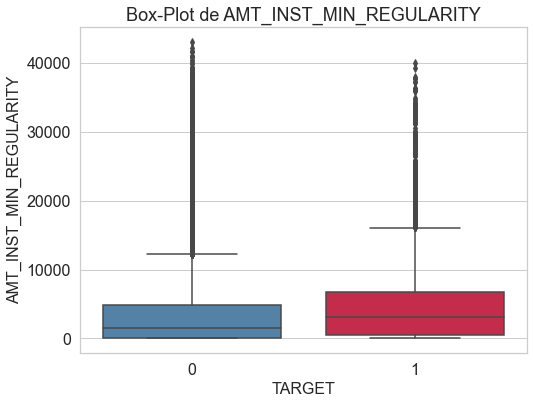

In [63]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_INST_MIN_REGULARITY',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
Le versement minimal est plus important pour les non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_PAYMENT_CURRENT**</span>

Combien le demandeur a-t-il payé pendant le mois sur le crédit précédent ?

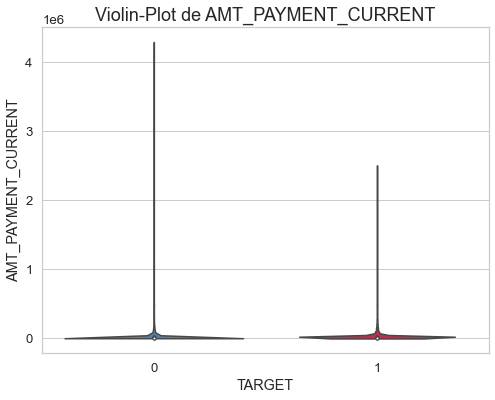

In [53]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_PAYMENT_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu des différences entre les défaillants ou non.
- Un outlier avec paiement > 4000000 à supprimer.

<span style='background:PaleGreen'>**Variable AMT_PAYMENT_TOTAL_CURRENT**</span>

Combien le demandeur a-t-il payé au total pendant le mois sur le crédit précédent ?

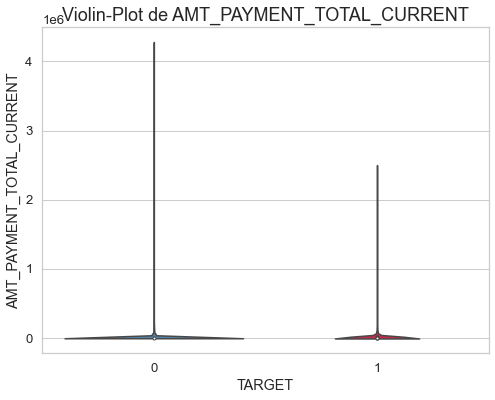

In [54]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_PAYMENT_TOTAL_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Les demandeurs non-défaillants ont payé plsu au total pendant le mois sur le crédit précédent que les défaillants.

<span style='background:PaleGreen'>**Variable AMT_RECEIVABLE_PRINCIPAL**</span>

Montant à recevoir pour le principal du crédit précédent.

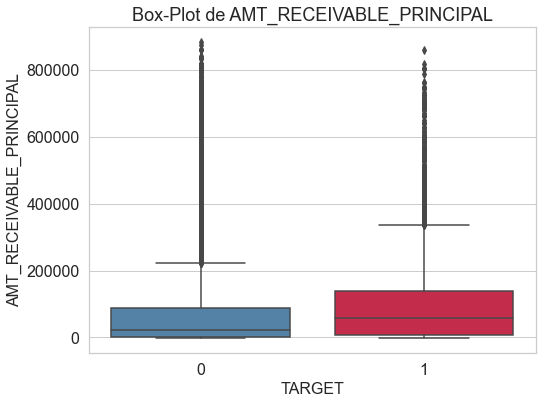

In [72]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_RECEIVABLE_PRINCIPAL',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
Le montant à recevoir pour le principal du crédit précédent est bien supérieur pour les non-défaillants que les défaillants.

<span style='background:PaleGreen'>**Variable AMT_RECIVABLE**</span>

Montant à recevoir sur le crédit précédent.

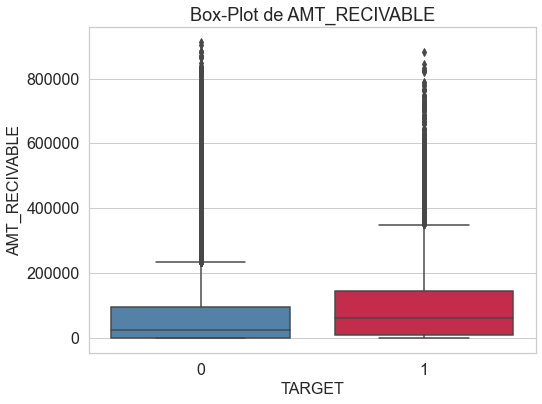

In [73]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'AMT_RECIVABLE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
Le montant à recevoir sur le crédit précédent est bien supérieur pour les non-défaillants que les défaillants.

<span style='background:PaleGreen'>**Variable CNT_DRAWINGS_ATM_CURRENT**</span>

Nombre de retraits au guichet automatique durant ce mois sur le crédit précédent.

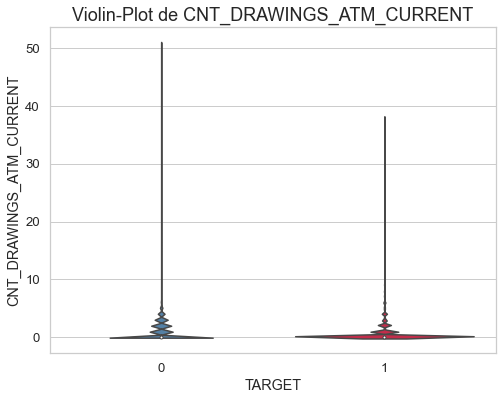

In [55]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'CNT_DRAWINGS_ATM_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Un peu moins de retraits automatiques pour les défaillants.

<span style='background:PaleGreen'>**Variable CNT_DRAWINGS_CURRENT**</span>

Nombre de retraits pendant ce mois sur le crédit précédent.

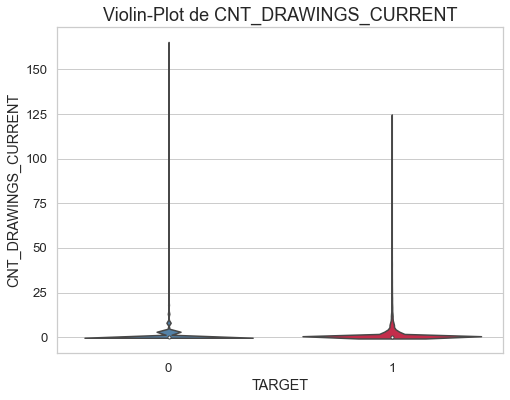

In [56]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'CNT_DRAWINGS_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
Le nombre de retraits pendant ce mois sur le crédit précédent est plus important pour les non-défaillants.

<span style='background:PaleGreen'>**Variable CNT_DRAWINGS_OTHER_CURRENT**</span>

Nombre d'autres retraits au cours de ce mois sur le crédit précédent.

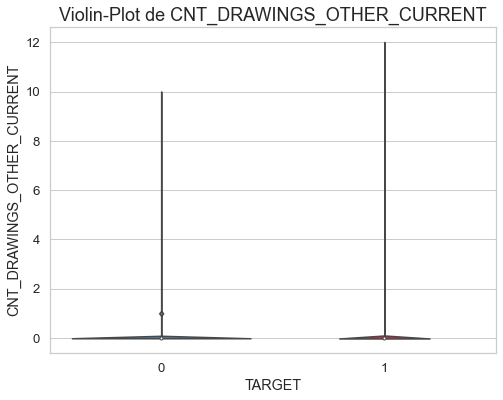

In [57]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'CNT_DRAWINGS_OTHER_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
Le nombre d'autres retraits au cours de ce mois sur le crédit précédent est plus nombreux pour les défaillants.


<span style='background:PaleGreen'>**Variable CNT_DRAWINGS_POS_CURRENT**</span>

Nombre de retraits de marchandises durant ce mois sur le crédit précédent.

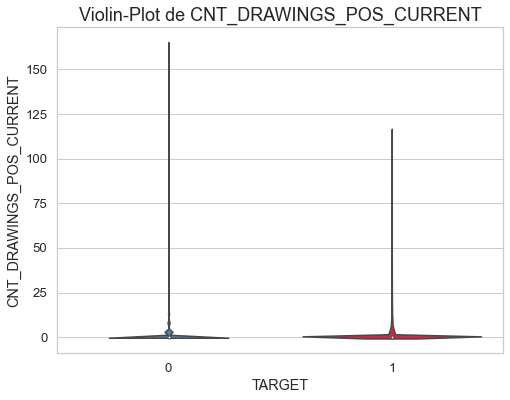

In [58]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'CNT_DRAWINGS_POS_CURRENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
Le nombre de retraits de marchandises durant ce mois sur le crédit précédent est plus nombreux pour les non-défaillants.

<span style='background:PaleGreen'>**Variable SK_DPD**</span>

DPD (jours de retard) au cours du mois sur le crédit précédent.

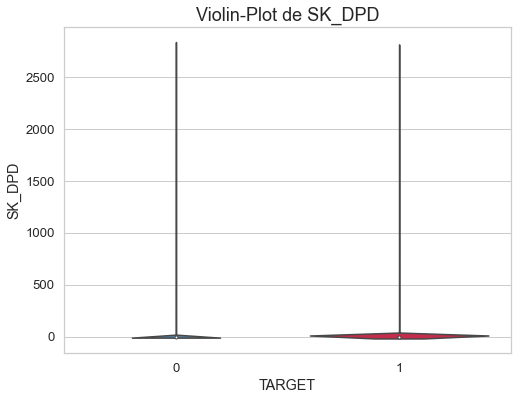

In [59]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'SK_DPD',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence entre les défaillants et les non-défaillants.

<span style='background:PaleGreen'>**Variable SK_DPD_DEF**</span>

DPD (jours de retard) au cours du mois sur le crédit précédent.

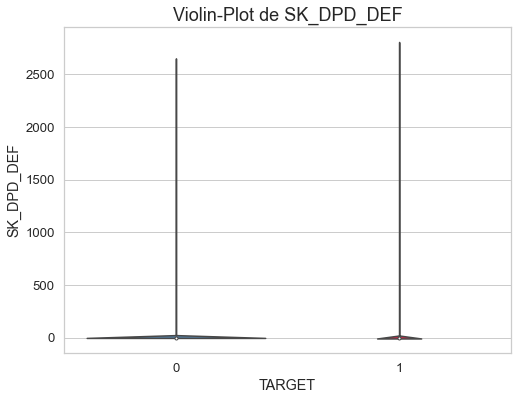

In [60]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(cc_balance_merged,
                                               'SK_DPD_DEF',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
Les DPDs (jours de retard) au cours du mois sur le crédit précédent sont plus nombreux pour les non-défaillants.

#### <span style='background:Moccasin'>2.6.3. Analyse exploratoire multivariée</span>

<span style='background:PaleGreen'>**Corrélation entre les variables numériques**</span>

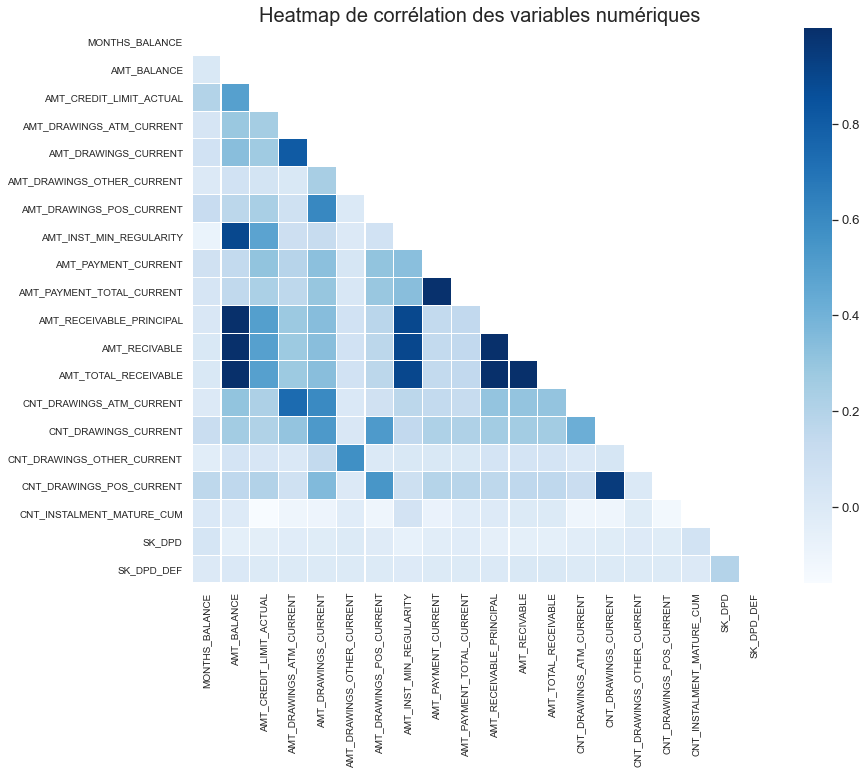

In [30]:
corr_mat = \
    eda_kernel_fonctions.correlation_matrix(cc_balance_merged,
                                            ['SK_ID_CURR', 'SK_ID_PREV'],
                                            cmap='Blues',
                                            figsize=(13, 11))
corr_mat.plot_correlation_matrix()

In [31]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

-------------------------------------------------------------------------------


**Bilan** :
***
- La carte thermique ci-dessus montre visuellement la corrélation entre les variables du fichier credit_card_balance.csv.
- À partir de la carte thermique de la matrice de corrélation, nous voyons quelques couples de variables fortement corrélées. 
- Il s'agit de :
    - AMT_RECEIVABLE_PRINCIPLE,
    - AMT_RECIVABLE,
    - AMT_TOTAL_RECEIVABLE
    - et AMT_BALANCE.
- Nous observons également une forte corrélation entre ces 2 variables :
    - AMT_PAYMENT_TOTAL_CURRENT,
    - et AMT_PAYMENT_CURRENT.
- Les ensembles des 2ème et 3ème variables en corrélation sont compréhensibles car ils ont plus ou moins la même histoire.
- La corrélation des variables avec la variable cible n'est pas perceptible, ce qui montre l'absence d'une relation linéaire entre la caractéristique et la variable cible.

### <span style='background:PowderBlue'>2.6. Fichier installments_payments.csv</span>

#### <span style='background:Moccasin'>2.6.1. Description/statistiques</span>

<span style='background:PaleGreen'>**Description**</span>

- Ce fichier **installments_payments.csv** présente l'historique de remboursement de chacun des prêts que le demandeur a contractés auprès de Home Credit Group.
- Le tableau contient des variables telles que le montant des versements, combien le demandeur a payé pour chaque versement, etc.

<span style='background:PaleGreen'>**Compréhension des variables**</span>

In [83]:
df_var_instpaie = \
    HomeCredit_columns_description[HomeCredit_columns_description['Table']
                                   == 'installments_payments.csv']
df_var_instpaie.style.hide_index()

<span style='background:PaleGreen'>**Statistiques**</span>

In [85]:
installments_payments.name = 'installments_payments'
eda_kernel_fonctions. \
    afficher_stats_basic_all(installments_payments, application_train,
                             application_test, 'SK_ID_PREV')

-------------------------------------------------------------------------------
Le jeu de données contient 13605401 lignes et 8 variables.
-------------------------------------------------------------------------------
Nombre de valeurs uniques SK_ID_PREV dans installments_payments.csv : 997752
Nombre de valeurs uniques SK_ID_CURR dans installments_payments.csv : 339587
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et installments_payments.csv : 291643
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et installments_payments.csv : 47944
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans installments_payments.csv : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT
0     1054186      161674                     1.0                      6          -1180.0             -1187.0        6948.360     6948.360
1     1330831      151639                     0.0                     34          -2156.0             -2156.0        1716.525     1716.525
2     2085231      193053                     2.0                      1            -63.0               -63.0       25425.000    25425.000
3     2452527      199697                     1.0                      3          -2418.0             -2426.0       24350.130    24350.130
4     2714724      167756                     1.0                      2          -1383.0             -1366.0        2165.040     2160.585

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

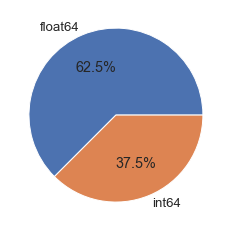

In [86]:
# Types des variables
outils_data.get_types_variables(installments_payments, True, True, True)

In [87]:
# Résumé des variables
desc_bureau = outils_data.description_variables(installments_payments)
desc_bureau

SK_ID_PREV   SK_ID_CURR NUM_INSTALMENT_VERSION NUM_INSTALMENT_NUMBER DAYS_INSTALMENT DAYS_ENTRY_PAYMENT AMT_INSTALMENT  AMT_PAYMENT
type           int64        int64                float64                 int64         float64            float64        float64      float64
nb_nan           0.0          0.0                    0.0                   0.0             0.0             2905.0            0.0       2905.0
%_nan            0.0          0.0                    0.0                   0.0             0.0             0.0027            0.0       0.0027
count     13605401.0   13605401.0             13605401.0            13605401.0      13605401.0         13602496.0     13605401.0   13602496.0
mean    1903364.9695  278444.8817                 0.8566               18.8709        -1042.27         -1051.1137      17050.907   17238.2232
std      536202.9055  102718.3104                 1.0352               26.6641        800.9463           800.5859     50570.2544    54735.784
min        1000001.0     100001.0                    0.0                   1.0         -2922.0            -4921.0            0.0          0.0
25%        1434191.0     189639.0                    0.0                   4.0         -1654.0            -1662.0       4226.085     3398.265
50%        1896520.0     278685.0                    1.0                   8.0          -818.0             -827.0        8884.08     8125.515
75%        2369094.0     367530.0                    1.0                  19.0          -361.0             -370.0       16710.21    16108.425
max        2843499.0     456255.0                  178.0                 277.0            -1.0               -1.0    3771487.845  3771487.845

**Bilan** :
***
- Il y a environ 13,6 millions de points de données dans le fichier installments_payments.csv.
- Chaque ligne représente l'historique des versements liés à un prêt particulier que le demandeur a eu précédemment avec Home Credit Group.
- Il y a 997000 prêts antérieurs uniques dans le fichier installments_payments. Ils appartiennent à 339000 SK_ID_CURR uniques, qui sont les ID des demandeurs du prêt actuel.
- Sur ces 339000 SK_ID_CURR, 291000 appartiennent à l'ensemble de données d'apprentissage et 47900 à l'ensemble de données de test.
- Cela implique que sur les 307000 SK_ID_CURR uniques de l'application_train, 291000 ont déjà eu une forme de prêt avec Home Credit. - De même, pour 48700 de ceux qui sont dans l'ensemble de données de test, 47900 ont eu un prêt auparavant avec Home Credit.
- Le fichier a 8 variables uniques, dont 6 décrivent les statistiques de chaque versement pour le prêt précédent.

<span style='background:PaleGreen'>**Valeurs manquantes**</span>

Valeurs manquantes : 5810 NaN pour 108843208 données (0.01 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


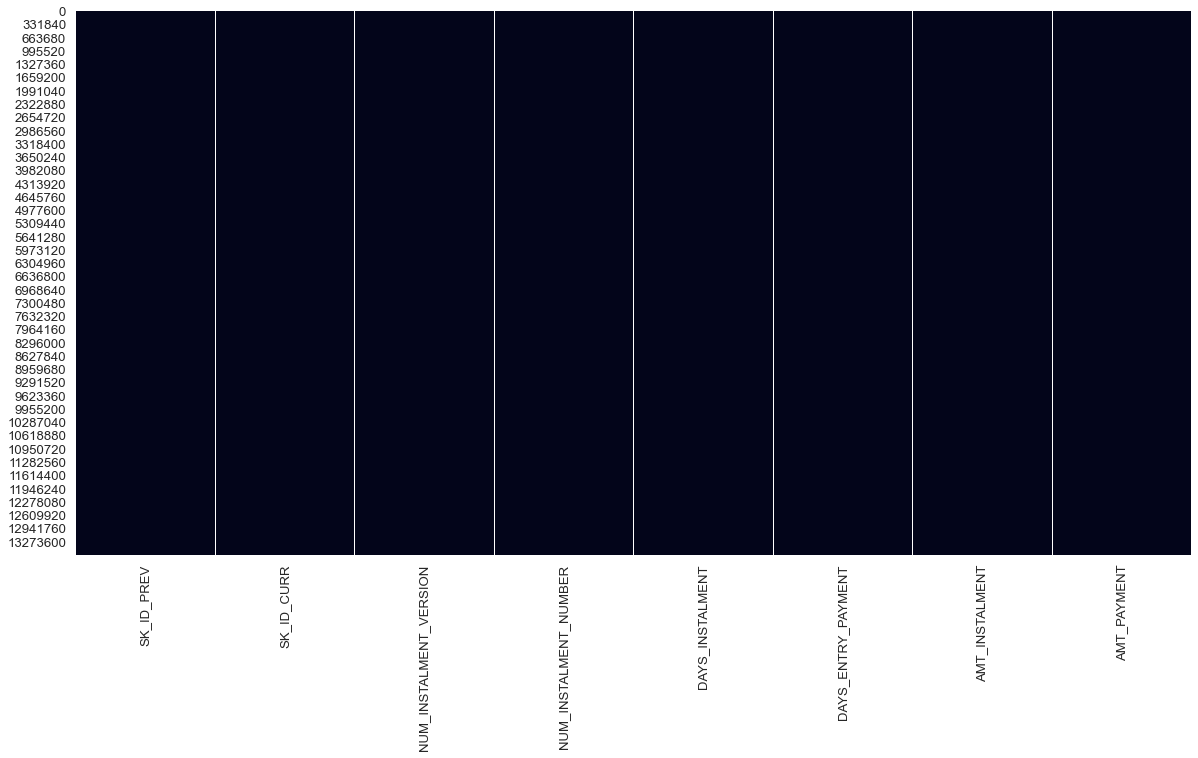

In [88]:
# Valeurs manquantes du dataframe
outils_data.get_missing_values(installments_payments, True, True)

Nombre de variables avec valeurs manquantes : 2


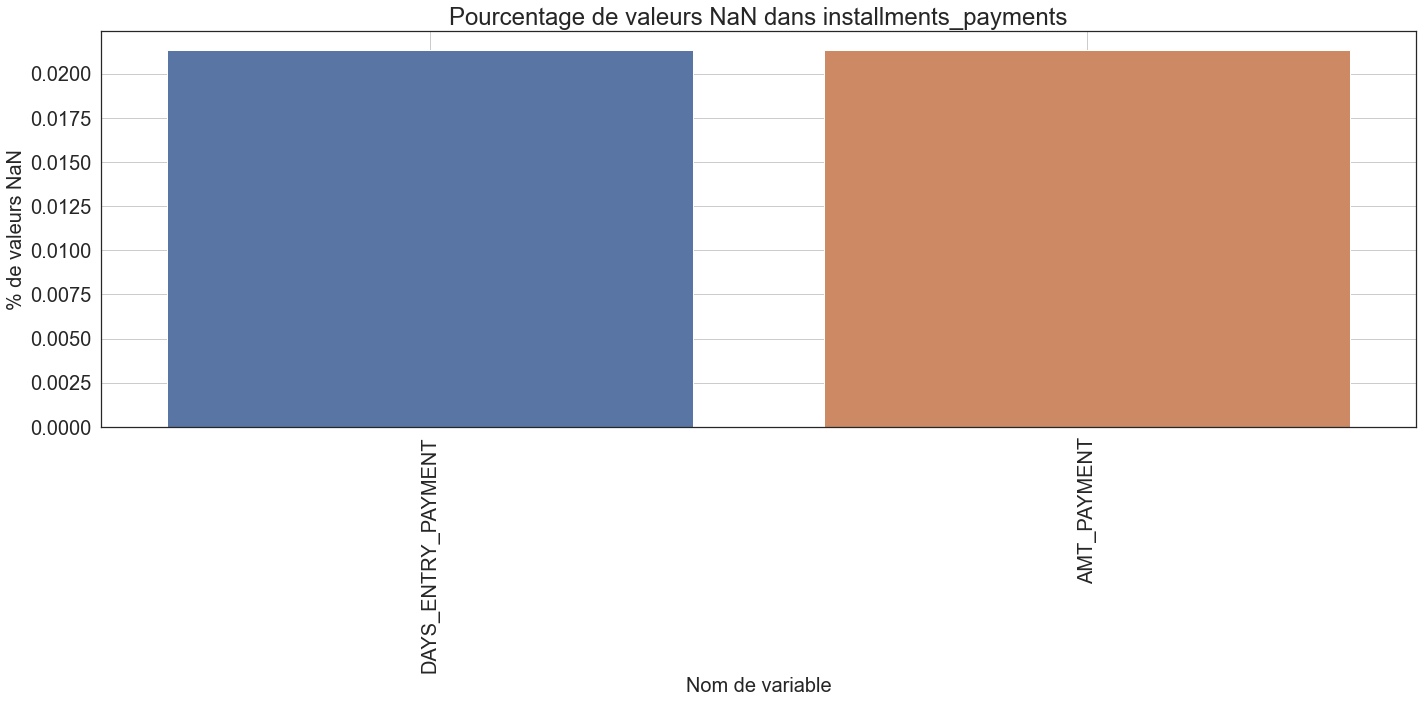

In [89]:
# Réprésentation visuelle des valeurs manquantes
df_nan_instpaie = eda_kernel_fonctions.nan_df_create(installments_payments)
eda_kernel_fonctions.plot_nan_percent(df_nan_instpaie, 'installments_payments',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))

**Bilan** :
***
- Il n'y a que 2 variables qui contiennent des valeurs NaN sur les 8 variables de installments_payments.
- Ces variables contiennent également une proportion très minime de valeurs NaN, c'est-à-dire seulement 0,02%, ce qui n'est pas très inquiétant.

**Préparation du dataframe de travail**

In [9]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
part1 = 'Création dataframe de travail : merge TARGET '
print(part1 + 'avec dataframe installments_payments')
installments_merged = \
    application_train.iloc[:, :2].merge(installments_payments,
                                        on='SK_ID_CURR',
                                        how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe installments_payments
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>2.6.2. Analyse exploratoire univariée</span>

***
<span style='background:Plum'>**Distribution des variables quantitatives**</span>
***

In [14]:
# Liste des variables quantitatives
cols_num_instpaie = \
    installments_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num_instpaie

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT']

Tout d'abord, nous allons regrouper par le champ 'SK_ID_PREV' et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du demandeur.

In [18]:
installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

<span style='background:PaleGreen'>**Variable DAYS_INSTALMENT**</span>

Cette variable indique les jours où le versement du crédit précédent devait être payé.

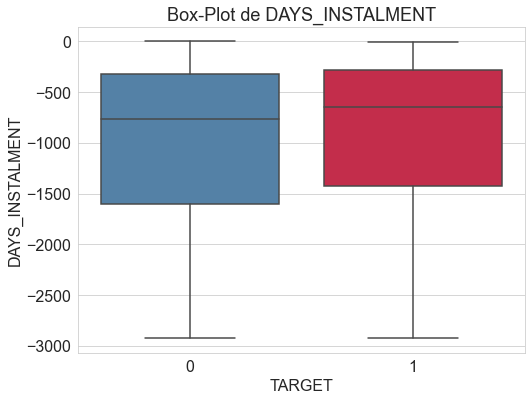

In [20]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(installments_merged,
                                               'DAYS_INSTALMENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Les jours où le versement du précédent devait être payé est inférieur pour les défaillants.

<span style='background:PaleGreen'>**Variable DAYS_ENTRY_PAYMENT**</span>

Cette variable indique les jours où le versement du crédit précédent a été effectivement payé.

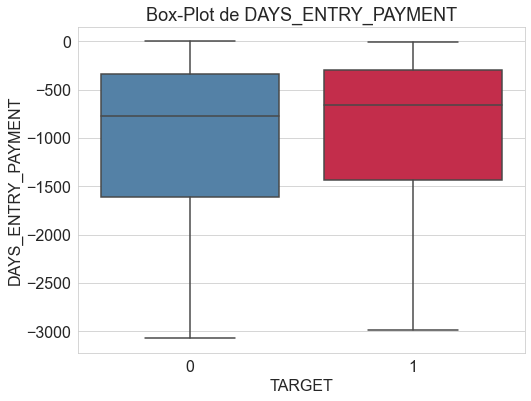

In [21]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(installments_merged,
                                               'DAYS_ENTRY_PAYMENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Les deux graphiques ci-dessus montrent une tendance similaire : les mauvais payeurs ont tendance à avoir moins de jours depuis leur dernier paiement, tandis que les mauvais payeurs ont plus de jours depuis leur dernier paiement.
- Tous les quantiles des défaillants ont plus de jours récents que ceux des non-défaillants. Ainsi, les non-défaillants ont généralement plus d'écart dans leurs paiements depuis le jour de la demande que les défaillants.

<span style='background:PaleGreen'>**Variable NUM_INSTALMENT_VERSION**</span>

Version du calendrier des versements (0 pour la carte de crédit) du crédit précédent. Le changement de la version des versements d'un mois à l'autre signifie qu'un paramètre du calendrier de paiement a changé.

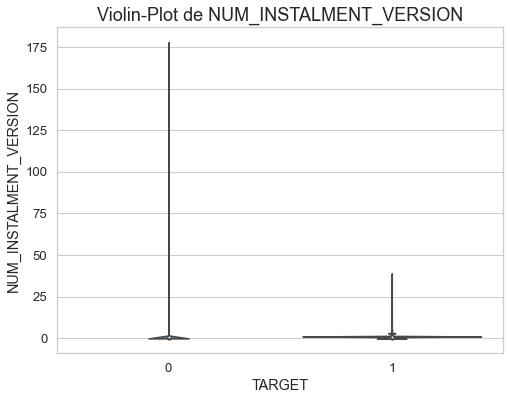

In [62]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(installments_merged,
                                               'NUM_INSTALMENT_VERSION',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Plus de modification de calendrier pour les non-défaillants.

<span style='background:PaleGreen'>**Variable NUM_INSTALMENT_NUMBER**</span>

Sur quel versement nous observons le paiement.

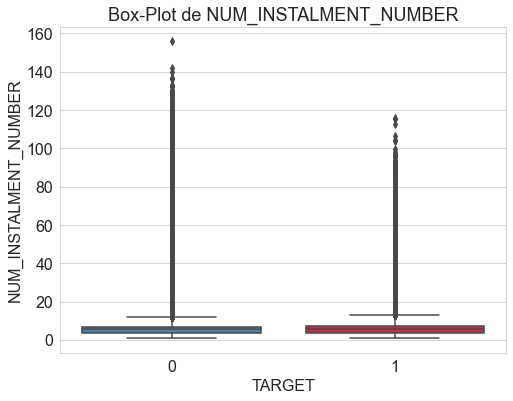

In [28]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(installments_merged,
                                               'NUM_INSTALMENT_NUMBER',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable AMT_INSTALMENT**</span>

Quel était le montant de l'acompte prescrit du crédit précédent sur cet acompte ?

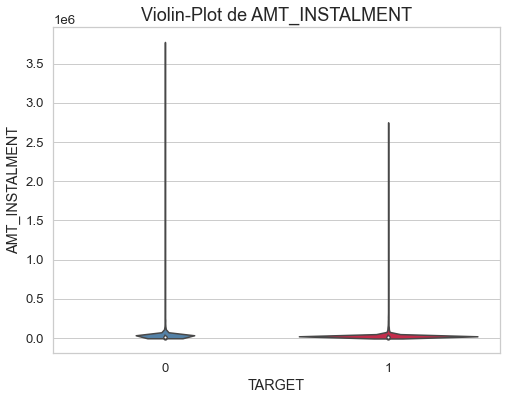

In [63]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(installments_merged,
                                               'AMT_INSTALMENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable AMT_PAYMENT**</span>

Ce que le demandeur a effectivement payé sur le crédit précédent pour ce versement.

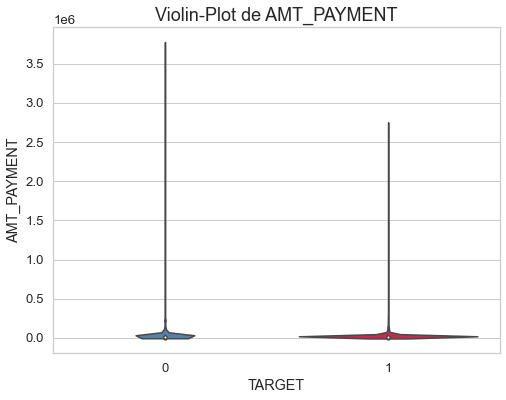

In [64]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(installments_merged,
                                               'AMT_PAYMENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

#### <span style='background:Moccasin'>2.6.3. Analyse exploratoire multivariée</span>

<span style='background:PaleGreen'>**Corrélation entre les variables numériques**</span>

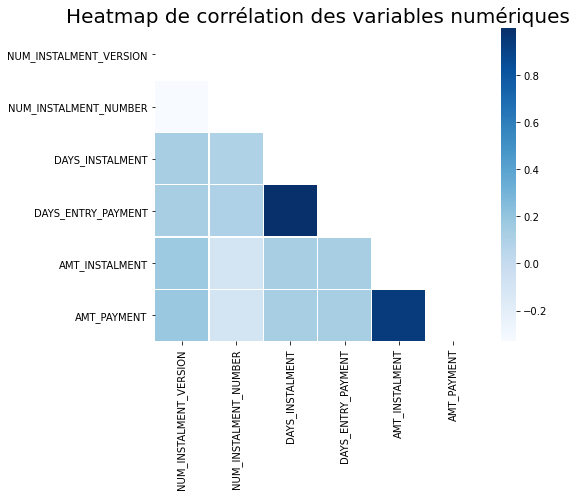

In [16]:
corr_mat = \
    eda_kernel_fonctions.correlation_matrix(installments_merged,
                                            ['SK_ID_CURR', 'SK_ID_PREV'],
                                            cmap='Blues',
                                            figsize=(8, 7))
corr_mat.plot_correlation_matrix()

In [17]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
-------------------------------------------------------------------------------
Les variables ayant les valeurs les plus élevées de Phik-corrélation avec la variable cible sont les suivantes :


-------------------------------------------------------------------------------


**Bilan** :
***
- La carte thermique ci-dessus montre la corrélation entre chaque variable du fichier installments_payments.csv et le reste des variables.
- À partir de la carte thermique de la matrice de corrélation, nous voyons un couple de variables fortement corrélées. Il s'agit de :
    - AMT_INSTALMENT et AMT_PAYMENT,
    - DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT.
- Ces deux ensembles de variables corrélées sont compréhensibles, car il s'agit en fait des variables relatives à la date à laquelle l'acompte devait être payé par rapport à la date à laquelle il a été payé, ainsi qu'au montant qui était dû par rapport au montant qui a été payé.
- Ces variables seront utiles pour créer de nouveaux ensembles de variables totalement non corrélées.
- La corrélation des variables avec la cible n'est pas perceptible, ce qui montre l'absence d'une relation linéaire entre la variable et la variable cible.

### <span style='background:PowderBlue'>2.7. Fichier POS_CASH_balance.csv</span>

#### <span style='background:Moccasin'>2.7.1. Description/statistiques</span>

<span style='background:PaleGreen'>**Description**</span>

- Ce fichier **POS_CASH_balance.csv** contient les instantanés des soldes mensuels des prêts aux points de vente et des prêts en espèces que le demandeur a obtenus auprès de Home Credit Group.
- Le fichier contient des colonnes telles que le statut du contrat, le nombre de versements restants, etc.

<span style='background:PaleGreen'>**Compréhension des variables**</span>

In [38]:
df_var_posh = \
    HomeCredit_columns_description[HomeCredit_columns_description['Table']
                                   == 'POS_CASH_balance.csv']
df_var_posh.style.hide_index()

<span style='background:PaleGreen'>**Statistiques**</span>

In [48]:
POS_CASH_balance.name = 'POS_CASH_balance'
application_train.name = 'application_train'
application_test.name = 'application_test'
eda_kernel_fonctions. \
    afficher_stats_basic_all(POS_CASH_balance, application_train,
                             application_test, 'SK_ID_PREV')

-------------------------------------------------------------------------------
Le jeu de données contient 10001358 lignes et 8 variables.
-------------------------------------------------------------------------------
Nombre de valeurs uniques SK_ID_PREV dans POS_CASH_balance.csv : 936325
Nombre de valeurs uniques SK_ID_CURR dans POS_CASH_balance.csv : 337252
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et POS_CASH_balance.csv : 289444
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et POS_CASH_balance.csv : 47808
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans POS_CASH_balance.csv : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0     1803195      182943             -31            48.0                   45.0               Active       0           0
1     1715348      367990             -33            36.0                   35.0               Active       0           0
2     1784872      397406             -32            12.0                    9.0               Active       0           0
3     1903291      269225             -35            48.0                   42.0               Active       0           0
4     2341044      334279             -35            36.0                   35.0               Active       0           0

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

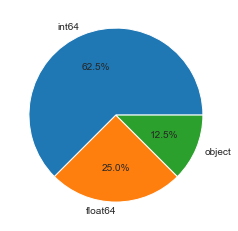

In [49]:
# Types des variables
outils_data.get_types_variables(POS_CASH_balance, True, True, True)

In [50]:
# Résumé des variables
desc_bureau = outils_data.description_variables(POS_CASH_balance)
desc_bureau

SK_ID_PREV   SK_ID_CURR MONTHS_BALANCE CNT_INSTALMENT CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS      SK_DPD  SK_DPD_DEF
type          int64        int64          int64        float64               float64               object       int64       int64
nb_nan          0.0          0.0            0.0        26071.0               26087.0                  0.0         0.0         0.0
%_nan           0.0          0.0            0.0         0.0326                0.0326                  0.0         0.0         0.0
count    10001358.0   10001358.0     10001358.0      9975287.0             9975271.0             10001358  10001358.0  10001358.0
unique          NaN          NaN            NaN            NaN                   NaN                    9         NaN         NaN
top             NaN          NaN            NaN            NaN                   NaN               Active         NaN         NaN
freq            NaN          NaN            NaN            NaN                   NaN              9151119         NaN         NaN
mean    1903216.599  278403.8633       -35.0126        17.0897               10.4838                  NaN     11.6069      0.6545
std     535846.5307  102763.7451        26.0666        11.9951               11.1091                  NaN     132.714     32.7625
min       1000001.0     100001.0          -96.0            1.0                   0.0                  NaN         0.0         0.0
25%       1434405.0     189550.0          -54.0           10.0                   3.0                  NaN         0.0         0.0
50%       1896565.0     278654.0          -28.0           12.0                   7.0                  NaN         0.0         0.0
75%       2368963.0     367429.0          -13.0           24.0                  14.0                  NaN         0.0         0.0
max       2843499.0     456255.0           -1.0           92.0                  85.0                  NaN      4231.0      3595.0

**Bilan** :
***
- Le fichier POSH_CASH_BALANCE.csv contient environ 10 millions de points de données, où chaque ligne correspond à l'instantané mensuel de l'état du POS et du prêt d'argent précédent que le demandeur a eu avec Home Credit Group.
- Elle se compose de 8 variables, dont deux sont SK_ID_CURR et SK_ID_PREV.
- Il y a 936000 identifiants uniques de prêts précédents dans le fichier, qui correspondent à 337000 demandeurs actuels uniques (SK_ID_CURR).
- Sur ces 337000 SK_ID_CURR, 289000 appartiennent à l'ensemble de formation et 47800 à l'ensemble de test.

<span style='background:PaleGreen'>**Valeurs manquantes**</span>

Valeurs manquantes : 52158 NaN pour 80010864 données (0.07 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


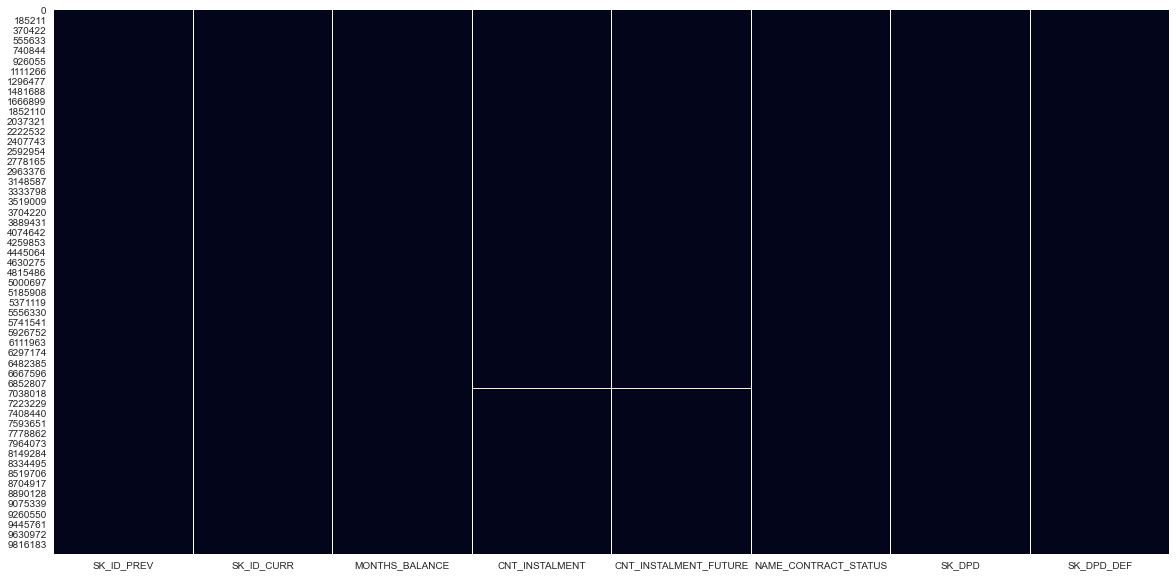

In [51]:
# Valeurs manquantes du dataframe
outils_data.get_missing_values(POS_CASH_balance, True, True)

Nombre de variables avec valeurs manquantes : 2


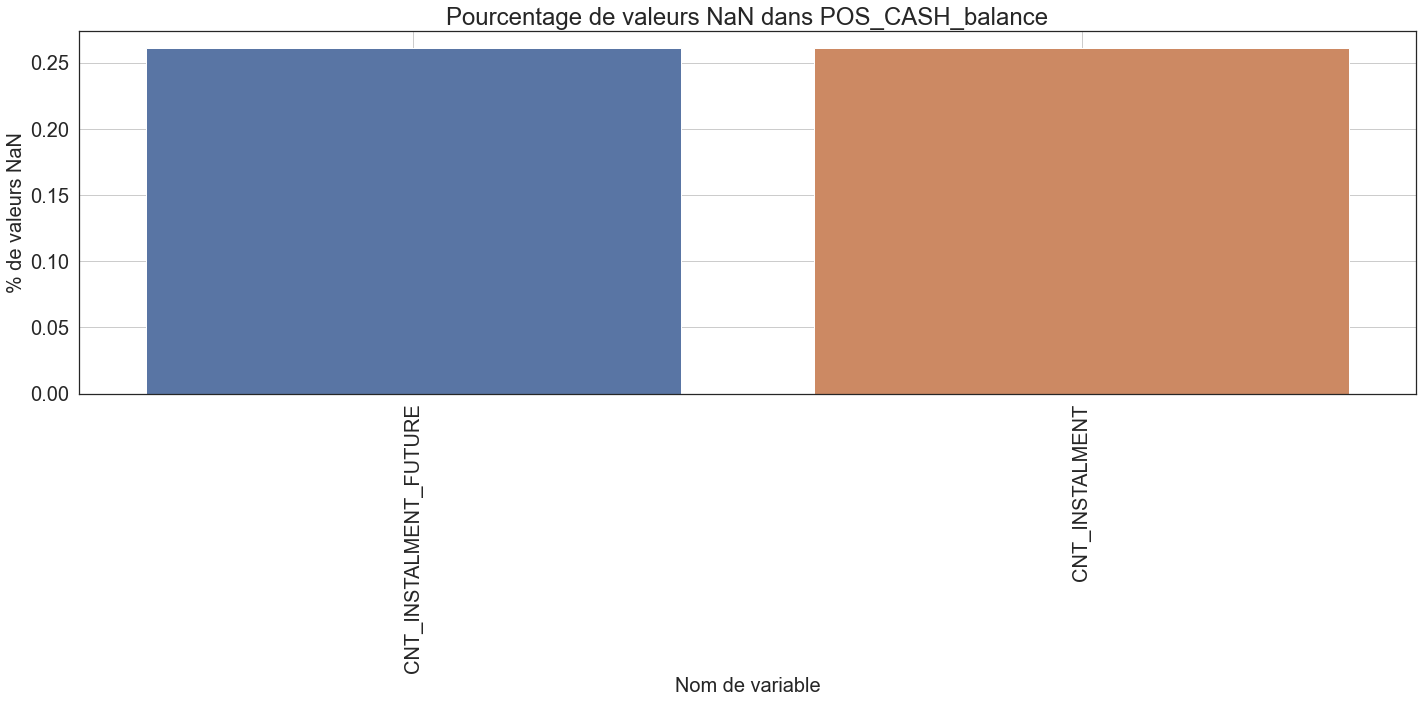

In [52]:
# Réprésentation visuelle des valeurs manquantes
df_nan_posh = eda_kernel_fonctions.nan_df_create(POS_CASH_balance)
eda_kernel_fonctions.plot_nan_percent(df_nan_posh, 'POS_CASH_balance',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))

**Bilan** :
***
- Il y a seulement 2 variables qui contiennent des valeurs NaN des 8 variables de POS_CASH_balance.
- Ces variables sont le nombre de versements restants et la durée du prêt.
- Ces variables contiennent également une proportion très minime de valeurs NaN, c'est-à-dire seulement 0,26 %, ce qui n'est pas très préoccupant.

**Préparation du dataframe de travail**

In [ ]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
var1 = 'Création dataframe de travail : merge TARGET '
print(var1 + 'avec dataframe POS_CASH_balance')
pos_cash_merged = application_train.iloc[:, :2].merge(POS_CASH_balance,
                                                      on='SK_ID_CURR',
                                                      how='left')
print("-"*79)

#### <span style='background:Moccasin'>2.7.2. Analyse exploratoire univariée</span>

***
<span style='background:Plum'>**Distribution des variables catégorielles**</span>
***

Tout d'abord, nous allons regrouper par le champ 'SK_ID_PREV' et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du demandeur.

In [57]:
# Liste des variables qualitatives
cols_cat_posh = \
    pos_cash_merged.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_posh

['NAME_CONTRACT_STATUS']

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_STATUS**</span>

État du contrat au cours du mois.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
['Active' 'Completed' 'Returned to the store' 'Signed' nan 'Approved'
 'Demand' 'Amortized debt' 'Canceled' 'XNA']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 10


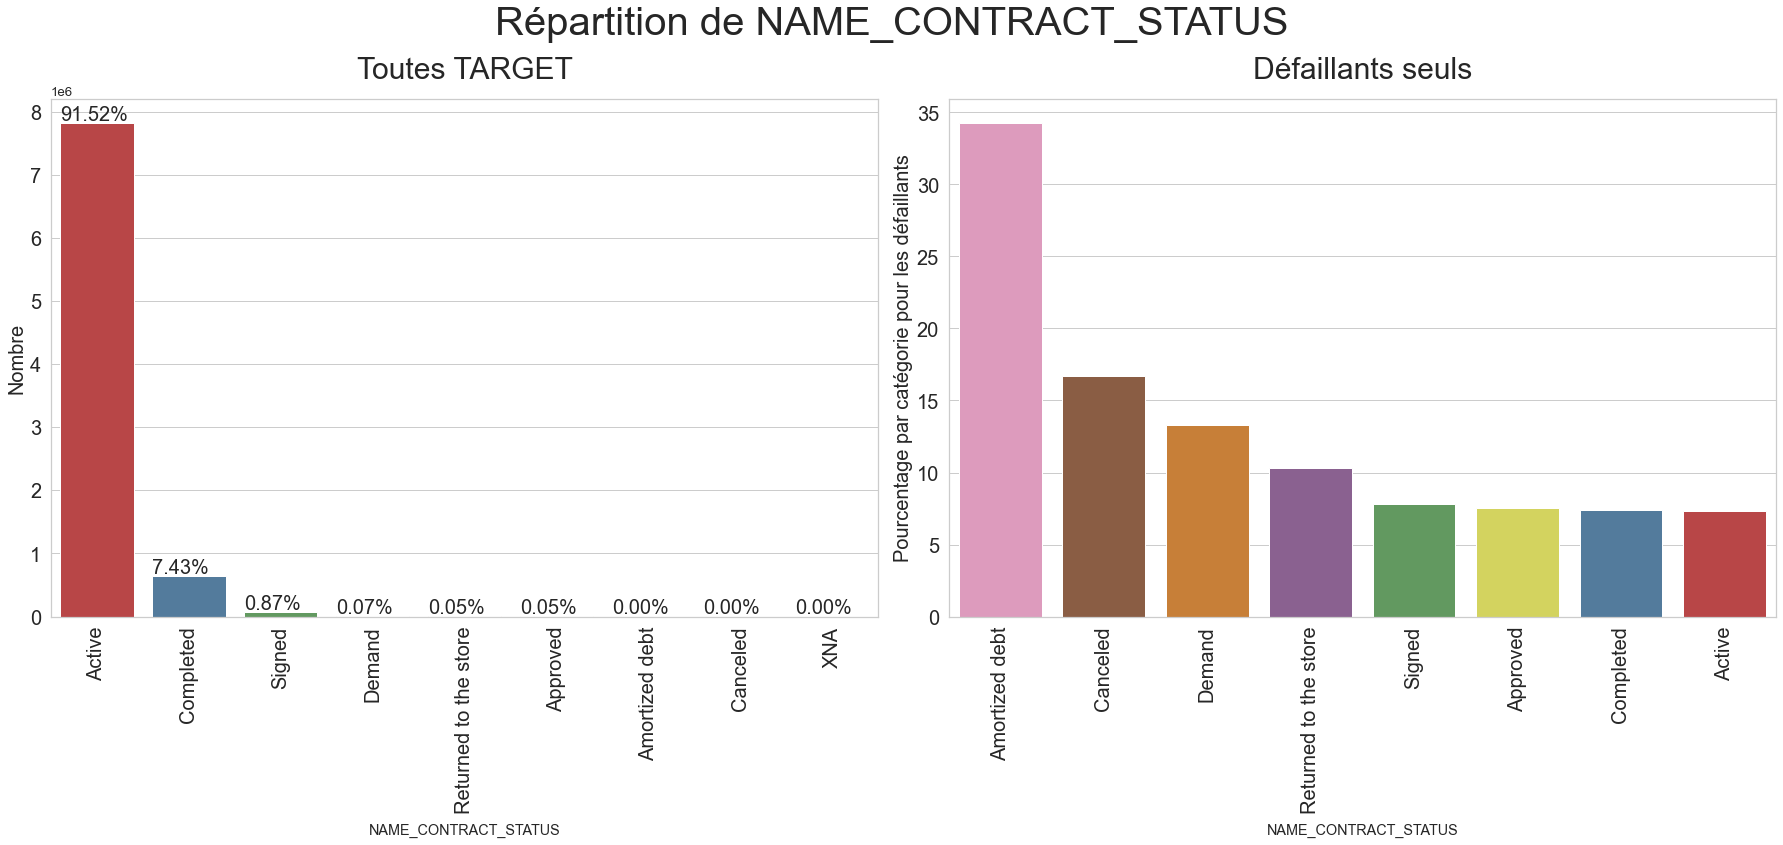

In [66]:
# Let us first see the unique categories of 'NAME_CONTRACT_STATUS'
eda_kernel_fonctions.print_unique_categories(pos_cash_merged,
                                             'NAME_CONTRACT_STATUS')

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(pos_cash_merged,
                                   column_name='NAME_CONTRACT_STATUS',
                                   figsize=(25, 12), rotation=90,
                                   fontsize_percent=20,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999'],
                                   palette2=['#e890be', '#965a38',
                                             '#df7f20', '#905998',
                                             '#59a257', '#e6e64c',
                                             '#477ca8', '#cb3335'])

**Bilan** :
***
- La majorité des états des contrats des prêts sont Actif ou Terminé.
- Pour les défaillants, l'état des contrat sont en priorité tous sauf ceux de la majorité des demandeurs Actifs ou Terminés.
- Les non-défaillants ont plus de prêts actifs que les défaillants.

***
<span style='background:Plum'>**Distribution des variables quantitatives**</span>
***

In [64]:
# Liste des variables quantitatives
cols_num_posh = \
    pos_cash_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num_posh

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF']

<span style='background:PaleGreen'>**Variable MONTHS_BALANCE**</span>

Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente).

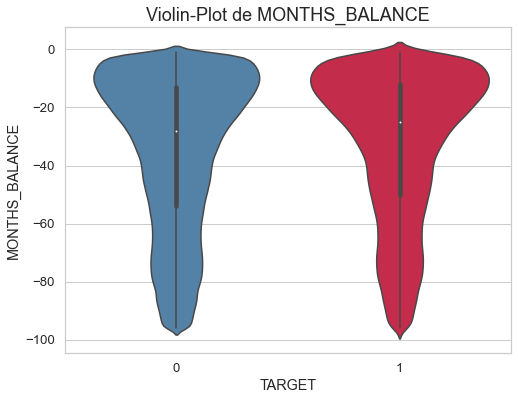

In [67]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(pos_cash_merged,
                                               'MONTHS_BALANCE',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable CNT_INSTALMENT**</span>

Durée du crédit précédent (peut changer avec le temps).

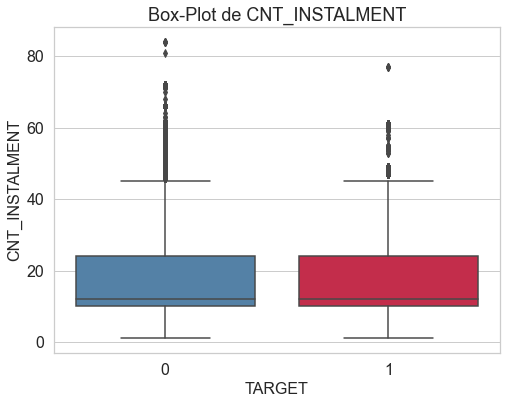

In [70]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(pos_cash_merged,
                                               'CNT_INSTALMENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable CNT_INSTALMENT_FUTURE**</span>

Versements restant à payer sur le crédit précédent.

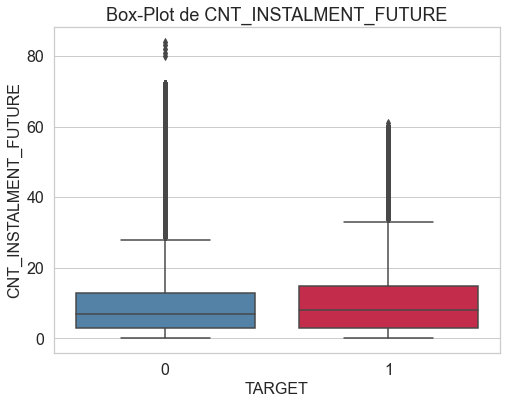

In [69]:
# Affiche Boxplot
eda_kernel_fonctions.plot_continuous_variables(pos_cash_merged,
                                               'CNT_INSTALMENT_FUTURE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Les versements sont légèrement plus élevés pour les défaillants.

<span style='background:PaleGreen'>**Variable SK_DPD**</span>

DPD (jours de retard) au cours du mois du crédit précédent.

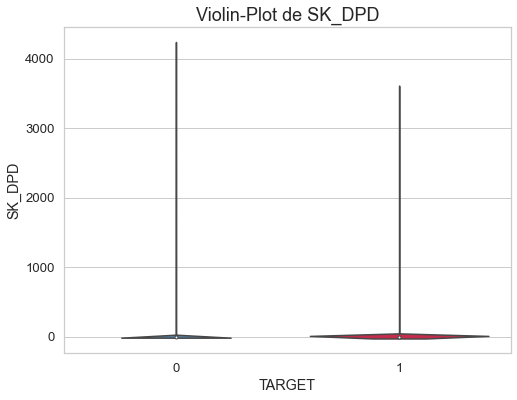

In [68]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(pos_cash_merged,
                                               'SK_DPD',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable SK_DPD_DEF**</span>

DPD au cours du mois avec tolérance (les dettes de faible montant sont ignorées) du crédit précédent.

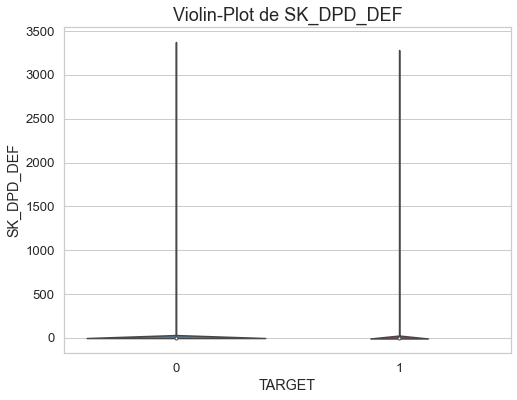

In [69]:
# Affiche Violinplot
eda_kernel_fonctions.plot_continuous_variables(pos_cash_merged,
                                               'SK_DPD_DEF',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

#### <span style='background:Moccasin'>2.7.3. Analyse exploratoire multivariée</span>

<span style='background:PaleGreen'>**Corrélation entre les variables numériques**</span>

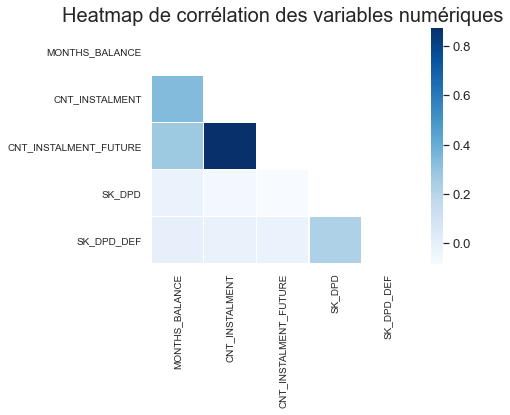

In [55]:
corr_mat = \
    eda_kernel_fonctions.correlation_matrix(pos_cash_merged,
                                            ['SK_ID_CURR', 'SK_ID_PREV'],
                                            cmap='Blues',
                                            figsize=(7, 6))
corr_mat.plot_correlation_matrix()

In [56]:
# Seeing the top columns with highest phik-correlation with the target
# variable in pos_cash_merged table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
-------------------------------------------------------------------------------
Les variables ayant les valeurs les plus élevées de Phik-corrélation avec la variable cible sont les suivantes :


-------------------------------------------------------------------------------


**Bilan** :
***
- La carte thermique ci-dessus montre la corrélation entre les variables.
- A partir de la carte de chaleur de la matrice de corrélation, nous avons un ensemble de variables modérément corrélées, qui sont : 
    - CNT_INSTALMENT et CNT_INSTALMENT_FUTURE.
- La corrélation des variables avec la cible est très faible, ce qui montre l'absence d'une relation linéaire entre la variables et la variable cible.

### <span style='background:PowderBlue'>2.8. Fichier previous_application.csv</span>

#### <span style='background:Moccasin'>2.8.1. Description/statistiques</span>

<span style='background:PaleGreen'>**Description**</span>

- Ce fichier **previous_application.csv** contient les données statiques du précédent prêt que le demmdeur a eu avec Home Credit. 

<span style='background:PaleGreen'>**Compréhension des variables**</span>

In [11]:
df_var_prev = \
    HomeCredit_columns_description[HomeCredit_columns_description['Table']
                                   == 'previous_application.csv']
df_var_prev.style.hide_index()

<span style='background:PaleGreen'>**Statistiques**</span>

In [13]:
previous_application.name = 'credit_card_balance'
application_train.name = 'application_train'
application_test.name = 'application_test'
eda_kernel_fonctions. \
    afficher_stats_basic_all(previous_application, application_train,
                             application_test, 'SK_ID_PREV')

-------------------------------------------------------------------------------
Le jeu de données contient 1670214 lignes et 37 variables.
-------------------------------------------------------------------------------
Nombre de valeurs uniques SK_ID_PREV dans credit_card_balance.csv : 1670214
Nombre de valeurs uniques SK_ID_CURR dans credit_card_balance.csv : 338857
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et credit_card_balance.csv : 291057
Nombre de valeurs communes SK_ID_CURR dans application_train.csv et credit_card_balance.csv : 47800
-------------------------------------------------------------------------------
Numbre de valeurs dupliquées dans credit_card_balance.csv : 0
-------------------------------------------------------------------------------
Contenu des 3 premières lignes :


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0     2030495      271877     Consumer loans     1730.430          17145.0     17145.0               0.0          17145.0                   SATURDAY                       15                           Y                       1                0.0                 0.1828                    0.8673   
1     2802425      108129         Cash loans    25188.615         607500.0    679671.0               NaN         607500.0                   THURSDAY                       11                           Y                       1                NaN                    NaN                       NaN   
2     2523466      122040         Cash loans    15060.735         112500.0    136444.5               NaN         112500.0                    TUESDAY                       11                           Y                       1                NaN                    NaN                       NaN   
3     2819243      176158         Cash loans    47041.335         450000.0    470790.0               NaN         450000.0                     MONDAY                        7                           Y                       1                NaN                    NaN                       NaN   
4     1784265      202054         Cash loans    31924.395         337500.0    404055.0               NaN         337500.0                   THURSDAY                        9                           Y                       1                NaN                    NaN                       NaN   

  NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE             CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT NAME_YIELD_GROUP  \
0                    XAP             Approved            -73  Cash through the bank                XAP              NaN         Repeater              Mobile            POS               XNA             Country-wide                35         Connectivity         12.0           middle   
1                    XNA             Approved           -164                    XNA                XAP    Unaccompanied         Repeater                 XNA           Cash            x-sell           Contact center                -1                  XNA         36.0       low_action   
2                    XNA             Approved           -301  Cash through the bank                XAP  Spouse, partner         Repeater                 XNA           Cash            x-sell  Credit and cash offices                -1                  XNA         12.0             high   
3                    XNA             Approved           -512  Cash through the bank                XAP              NaN         Repeater                 XNA           Cash            x-sell  Credit and cash offices                -1                  XNA         12.0           middle   
4                Repairs              Refused           -781  Cash through the bank                 HC              NaN         Repeater                 XNA           Cash           walk-in  Credit and cash offices                -1                  XNA         24.0             high   

        PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
0  POS mobile with interest            365243.0           -42.0                      300.0          -42.0             -37.0                        0.0  
1          Cash X-Sell: low            365243.0          -134.0                      916.0       365243.0          365243.0                        1.0  
2         Cash X-Sell: high           

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

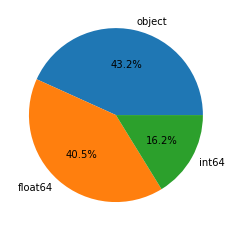

In [14]:
# Types des variables
outils_data.get_types_variables(previous_application, True, True, True)

In [15]:
# Résumé des variables
desc_bureau = outils_data.description_variables(previous_application)
desc_bureau

SK_ID_PREV   SK_ID_CURR NAME_CONTRACT_TYPE AMT_ANNUITY AMT_APPLICATION   AMT_CREDIT AMT_DOWN_PAYMENT AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT NFLAG_LAST_APPL_IN_DAY RATE_DOWN_PAYMENT RATE_INTEREST_PRIMARY RATE_INTEREST_PRIVILEGED  \
type           int64        int64             object     float64         float64      float64          float64         float64                     object                   int64                      object                  int64           float64               float64                  float64   
nb_nan           0.0          0.0                0.0    372235.0             0.0          1.0         895844.0        385515.0                        0.0                     0.0                         0.0                    0.0          895844.0             1664263.0                1664263.0   
%_nan            0.0          0.0                0.0      0.6023             0.0          0.0           1.4496          0.6238                        0.0                     0.0                         0.0                    0.0            1.4496                2.6931                   2.6931   
count      1670214.0    1670214.0            1670214   1297979.0       1670214.0    1670213.0         774370.0       1284699.0                    1670214               1670214.0                     1670214              1670214.0          774370.0                5951.0                   5951.0   
unique           NaN          NaN                  4         NaN             NaN          NaN              NaN             NaN                          7                     NaN                           2                    NaN               NaN                   NaN                      NaN   
top              NaN          NaN         Cash loans         NaN             NaN          NaN              NaN             NaN                    TUESDAY                     NaN                           Y                    NaN               NaN                   NaN                      NaN   
freq             NaN          NaN             747553         NaN             NaN          NaN              NaN             NaN                     255118                     NaN                     1661739                    NaN               NaN                   NaN                      NaN   
mean    1923089.1353  278357.1741                NaN  15955.1207     175233.8604  196114.0212        6697.4021     227847.2793                        NaN                 12.4842                         NaN                 0.9965            0.0796                0.1884                   0.7735   
std      532597.9587  102814.8238                NaN  14782.1373     292779.7624  318574.6165       20921.4954     315396.5579                        NaN                   3.334                         NaN                 0.0593            0.1078                0.0877                   0.1009   
min        1000001.0     100001.0                NaN         0.0             0.0          0.0             -0.9             0.0                        NaN                     0.0                         NaN                    0.0              -0.0                0.0348                   0.3732   
25%       1461857.25     189329.0                NaN     6321.78         18720.0      24160.5              0.0         50841.0                        NaN                    10.0                         NaN                    1.0               0.0                0.1607                   0.7156   
50%        1923110.5     278714.5                NaN     11250.0         71046.0      80541.0           1638.0        112320.0                        NaN                    12.0                         NaN                    1.0            0.0516                0.1891                   0.8351   
75%       2384279.75     367514.0                NaN    20658.42        180360.0     216418.5           7740.0        234000.0                       

**Bilan** :
***
- Le fichier previous_application.csv est composée de 1.67 millions de lignes au total.
- Chaque ligne correspond à chacun des prêts précédents que le demandeur a eu avec Home Credit Group. 
- Il est possible pour un même demandeur de la demande actuelle d'avoir plusieurs prêts précédents avec Home Credit Group.
- Il y a 37 variables dans previous_application.csv, qui contiennent les détails sur le prêt précédent.
- Il y a 338000 SK_ID_CURR uniques dans previous_application, dont 291000 correspondent aux SK_ID_CURR de l'application_train et 47800 correspondent aux SK_ID_CURR de l'application_test.

<span style='background:PaleGreen'>**Valeurs manquantes**</span>

Valeurs manquantes : 11109336 NaN pour 61797918 données (17.98 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


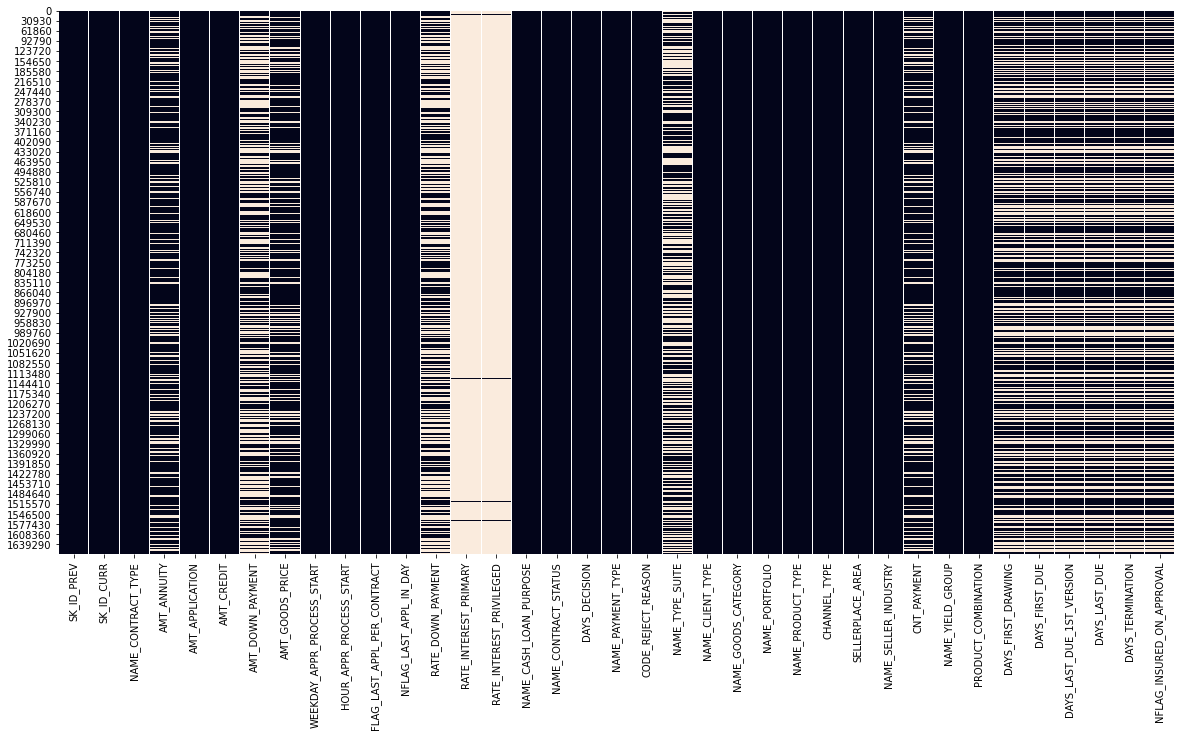

In [16]:
# Valeurs manquantes du dataframe
outils_data.get_missing_values(previous_application, True, True)

Nombre de variables avec valeurs manquantes : 16


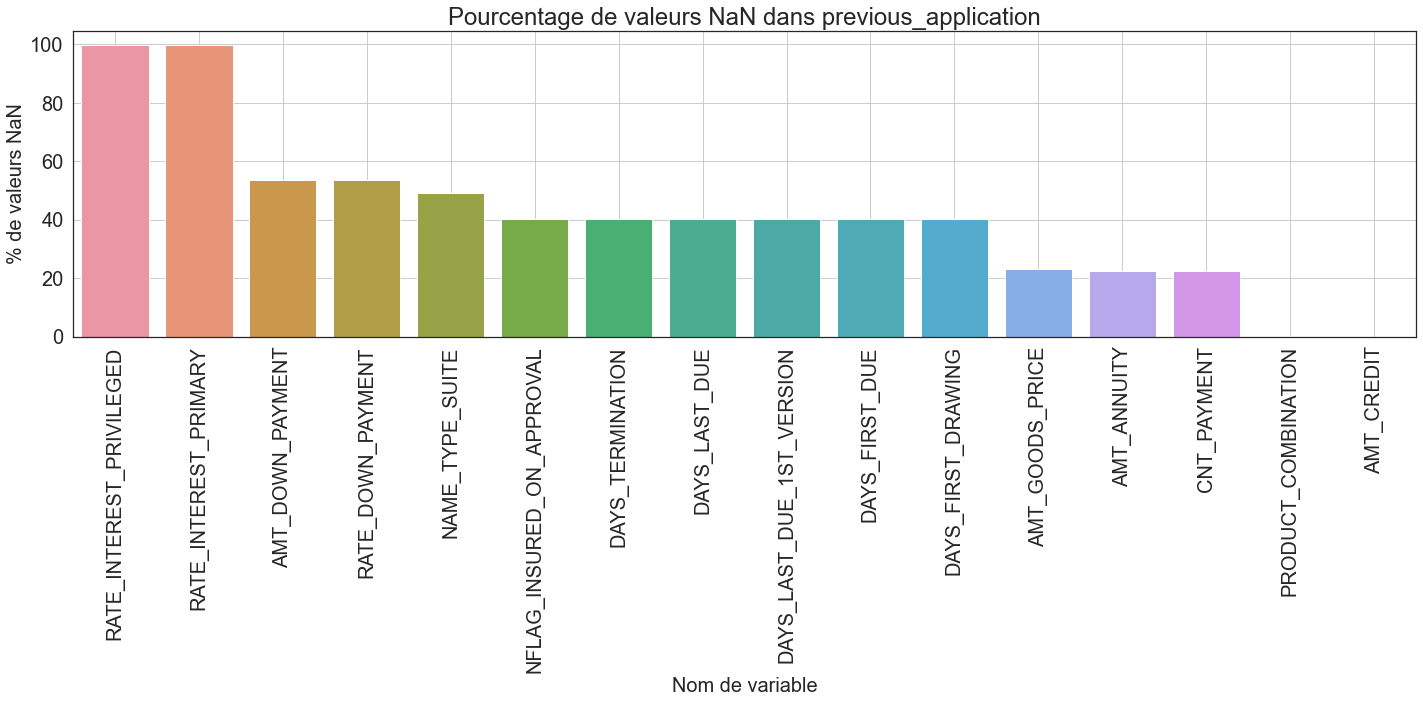

In [17]:
# Réprésentation visuelle des valeurs manquantes
df_nan_prev = eda_kernel_fonctions.nan_df_create(previous_application)
eda_kernel_fonctions.plot_nan_percent(df_nan_prev, 'previous_application',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))

**Bilan** :
***
- Il y a 16 variables sur les 37 variables qui contiennent des valeurs NaN.
- Deux de ces variables ont 99,64% de valeurs manquantes, ce qui est très élevé, et nous devrons trouver un moyen intelligent de gérer des valeurs NaN aussi élevées. 
- Nous ne pouvons pas directement écarter une variable à ce stade.
- En dehors de ces deux variables, le reste des variables contient également > 40% de valeurs NaN, à l'exception de 5 variables.

**Préparation du dataframe de travail**

In [11]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
var = 'Création dataframe de travail : merge TARGET '
print(var + 'avec dataframe previous_application')
prev_merged = application_train.iloc[:, :2].merge(previous_application,
                                                  on='SK_ID_CURR',
                                                  how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe previous_application
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>2.8.2. Analyse exploratoire univariée</span>

***
<span style='background:Plum'>**Distribution des variables catégorielles**</span>
***

Nous allons maintenant représenter graphiquement certaines des variables catégorielles du dataframe previous_application, et voir leur impact sur la variable cible.

In [26]:
# Liste des variables qualitatives
cols_cat_prev = \
    prev_merged.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_prev

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_TYPE**</span>

Type de produit contractuel (prêt d'argent ou prêt à la consommation [POS]...) de la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_TYPE' sont :
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_TYPE = 5


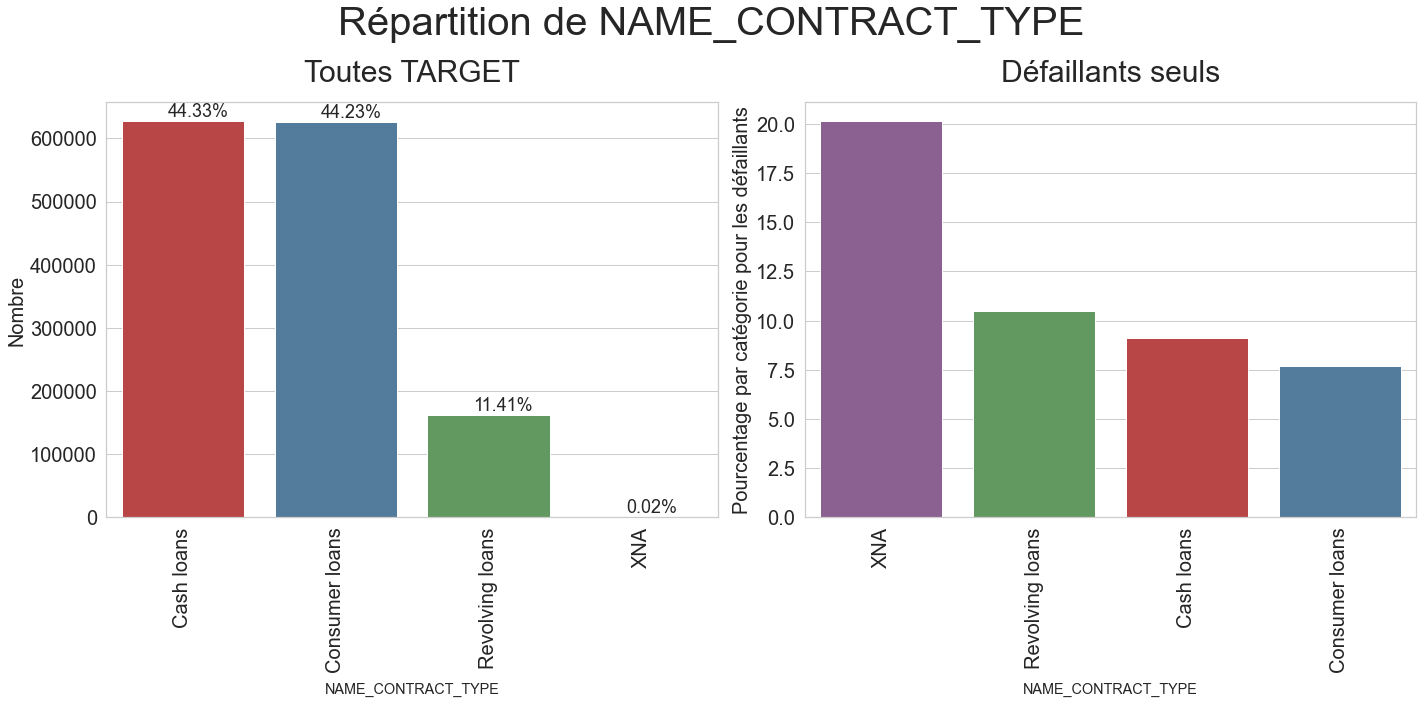

In [12]:
# Let us first see the unique categories of 'NAME_CONTRACT_TYPE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_CONTRACT_TYPE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_CONTRACT_TYPE',
                                   horizontal_adjust=0.3,
                                   figsize=(20, 10), fontsize_percent=18,
                                   rotation=90,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#905998', '#59a257',
                                             '#cb3335', '#477ca8'])

**Bilan** :
***
À partir des graphiques ci-dessus, nous pouvons observer ce qui suit :

- D'après le premier sous-graphe, nous voyons que la plupart des prêts précédents ont été des prêts d'argent ou des prêts à la consommation, qui correspondent à environ 44% des prêts chacun. 
- Les 11,41% restants correspondent à des prêts revolving, et il y a quelques prêts nommés XNA dont les types ne sont en fait pas connus, mais ils sont très peu nombreux.
- En regardant le deuxième sous-graphe, nous voyons que le pourcentage de défaillants pour le type de prêt XNA est le plus élevé, avec un taux de défaillance de 20%.
- Le deuxième taux de défaut le plus élevé est celui des prêts revolving, qui est proche de 10,5 %.
- Les prêts d'argent ont des taux de défaillance moins élevés, environ 9%, tandis que les prêts à la consommation ont tendance à avoir le plus faible pourcentage de défaillants, qui est proche de 7,5%.

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_STATUS**</span>

État du contrat (approuvé ou annulé ...) de la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Approved        886099
Canceled        259441
Refused         245390
Unused offer     22771
Name: NAME_CONTRACT_STATUS, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 5


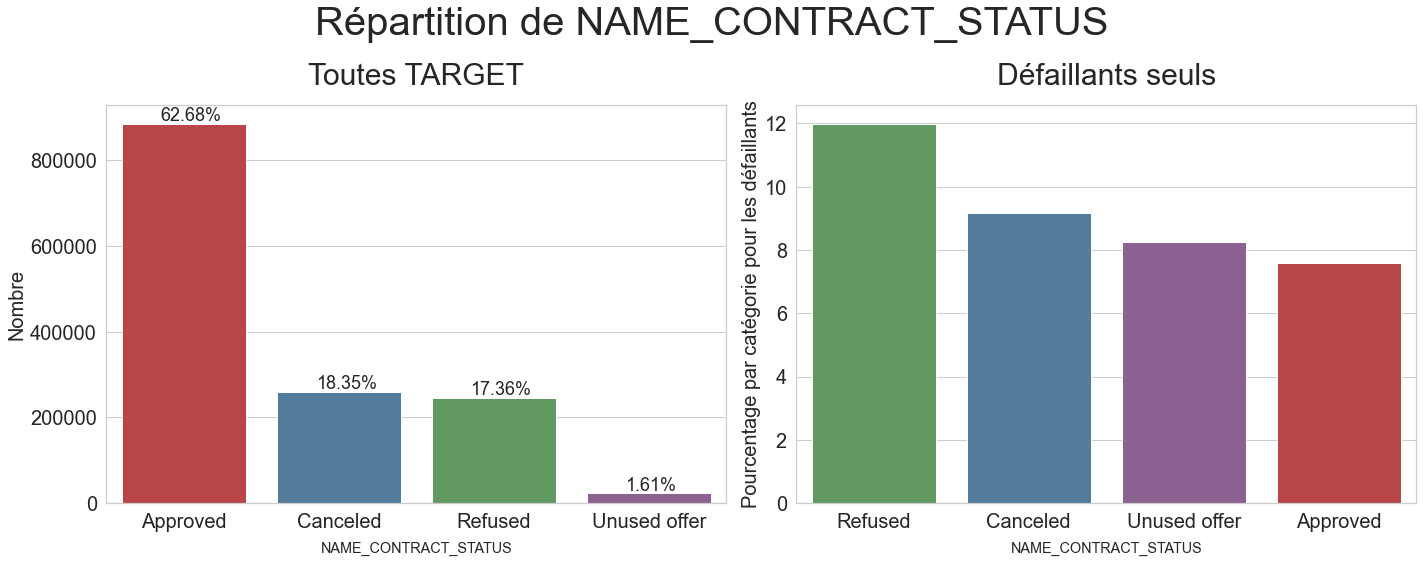

In [13]:
# Let us first see the unique categories of 'NAME_CONTRACT_STATUS'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_CONTRACT_STATUS',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_CONTRACT_STATUS',
                                   horizontal_adjust=0.25,
                                   figsize=(20, 8), fontsize_percent=18,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#59a257', '#477ca8',
                                             '#905998', '#cb3335'])

**Bilan** :
***
D'après les graphiques ci-dessus, nous constatons que :

- Le type le plus courant de statut de contrat est le statut approuvé. Environ 63% des crédits précédents ont un statut approuvé. Les deux statuts les plus courants suivants sont Annulé et Refusé, qui correspondent tous deux à environ 18% des prêts. Cela implique que la plupart des prêts sont approuvés et que seule une partie d'entre eux ne le sont pas. Le type d'état contractuel le moins fréquent est Offre non utilisée, qui correspond à seulement 1,61% de tous les prêts.
- Si l'on regarde le deuxième graphique secondaire pour le pourcentage de défaillants, on constate que les prêts qui avaient auparavant le statut Refusé ont tendance à être les plus défaillants dans les prêts actuels. Ils correspondent à environ 12% des défaillants de cette catégorie. Ils sont suivis par les prêts annulés qui correspondent à près de 9% du taux de défaillance. Ce comportement est assez attendu logiquement, puisque ces personnes ont dû être refusées parce qu'elles n'avaient pas le profil adéquat. Le taux de défaillance le plus faible est observé pour le statut de contrat Approuvé.

<span style='background:PaleGreen'>**Variable CODE_REJECT_REASON**</span>

Pourquoi la demande précédente a-t-elle été rejetée ?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CODE_REJECT_REASON' sont :
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CODE_REJECT_REASON = 10


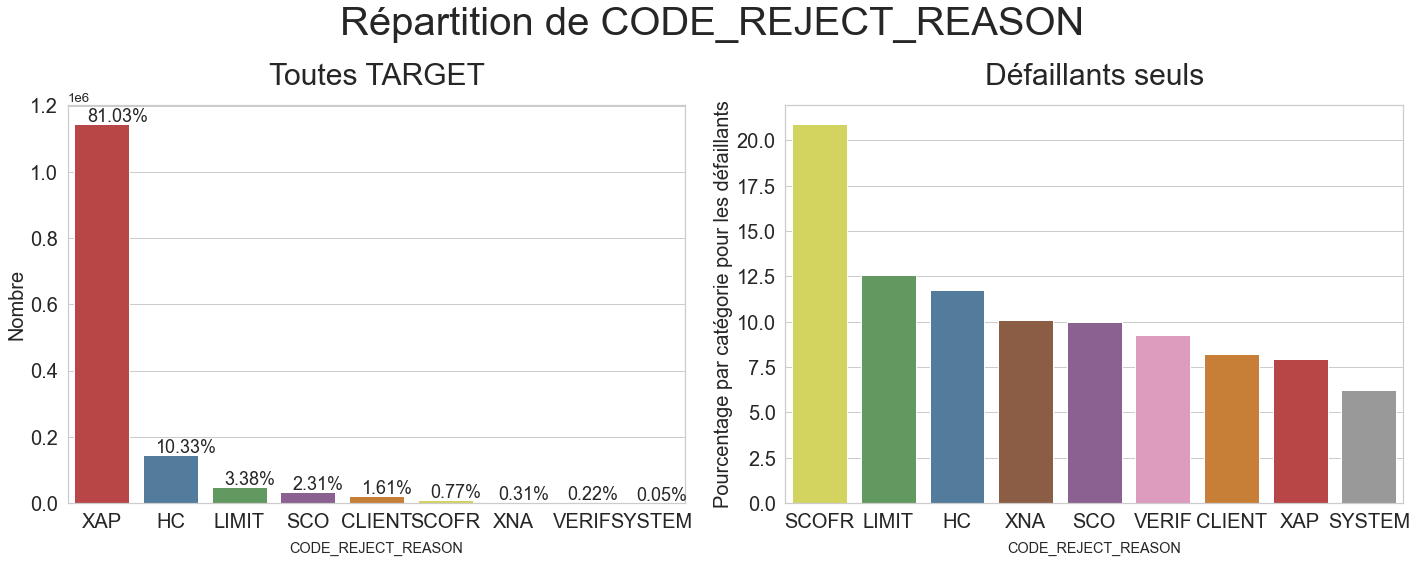

In [14]:
# Let us first see the unique categories of 'CODE_REJECT_REASON'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'CODE_REJECT_REASON',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='CODE_REJECT_REASON',
                                   horizontal_adjust=0.18,
                                   figsize=(20, 8), fontsize_percent=18,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999'],
                                   palette2=['#e6e64c', '#59a257',
                                             '#477ca8', '#965a38',
                                             '#905998', '#e890be',
                                             '#df7f20', '#cb3335',
                                             '#999999'])

**Bilan** :
***
Le graphique ci-dessus montre la distribution de la variable catégorielle CODE_REJECT_REASON. 

Les idées suivantes peuvent être générées à partir du graphique ci-dessus :
- Le type de raison de rejet le plus courant est XAP, qui représente environ ~81%. Les autres raisons ne représentent qu'une petite partie des raisons de rejet. HC est le deuxième motif de rejet le plus fréquent avec seulement 10,33% d'occurrences.
- La distribution du pourcentage de défaillants pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les demandeurs dont les demandes précédentes ont été rejetées par le code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~21%). Ils sont suivis par LIMIT et HC, qui comptent respectivement 12,5 % et 12 % de défaillants.
- Le motif de rejet le plus courant, XAP, ne correspond qu'à 7,5 % des défaillants, et représente le deuxième plus faible pourcentage de défaillants après le code SYSTEM.

<span style='background:PaleGreen'>**Variable CHANNEL_TYPE**</span>

Cette variable décrit le canal par lequel le demander a été acquis pour le prêt précédent dans Home Credit.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CHANNEL_TYPE' sont :
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Credit and cash offices       600342
Country-wide                  423062
Stone                         183508
Regional / Local               92472
Contact center                 58891
AP+ (Cash loan)                49624
Channel of corporate sales      5396
Car dealer                       406
Name: CHANNEL_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CHANNEL_TYPE = 9


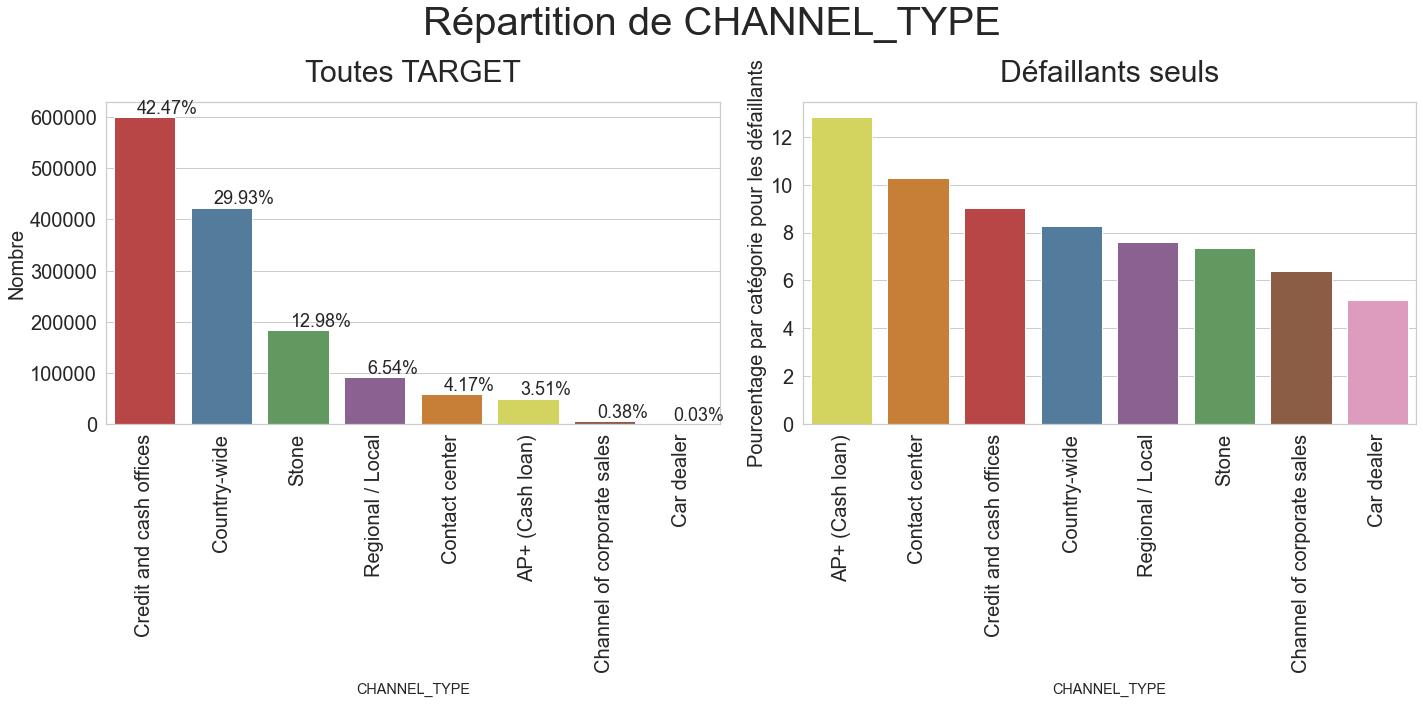

In [15]:
# Let us first see the unique categories of 'CHANNEL_TYPE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'CHANNEL_TYPE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='CHANNEL_TYPE',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(20, 10), fontsize_percent=18,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be'],
                                   palette2=['#e6e64c', '#df7f20',
                                             '#cb3335', '#477ca8',
                                             '#905998', '#59a257',
                                             '#965a38', '#e890be'])

**Bilan** :
***
Les deux graphiques ci-dessus montrent la distribution de CHANNEL_TYPE pour les prêts antérieurs dans Home Credit.

- Le premier graphique montre que la plupart des demandes ont été acquises par le biais des bureaux de crédit et de caisse, soit environ 42,47% des demandes, suivies par le canal national qui correspond à 29,93% des demandes. Le reste des types de canaux ne correspondait qu'à un nombre restreint de demandes.
- Le pourcentage de défaillance le plus élevé a été observé parmi les demandes pour lesquelles le type de canal était AP+ (prêt en espèces), ce qui correspondait à environ 13% de défaillants dans cette catégorie. Les autres canaux présentaient des pourcentages de défaillance plus faibles que celui-ci. Le canal Car Dealer a montré le plus faible pourcentage de défaillants dans cette catégorie (seulement 5%).

<span style='background:PaleGreen'>**Variable PRODUCT_COMBINATION**</span>

Combinaison détaillée des produits de la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'PRODUCT_COMBINATION' sont :
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Cash                              235101
POS household with interest       226464
POS mobile with interest          190850
Cash X-Sell: middle               120036
Cash X-Sell: low                  110599
Card Street                        94594
POS industry with interest         83508
POS household without interest     71519
Car

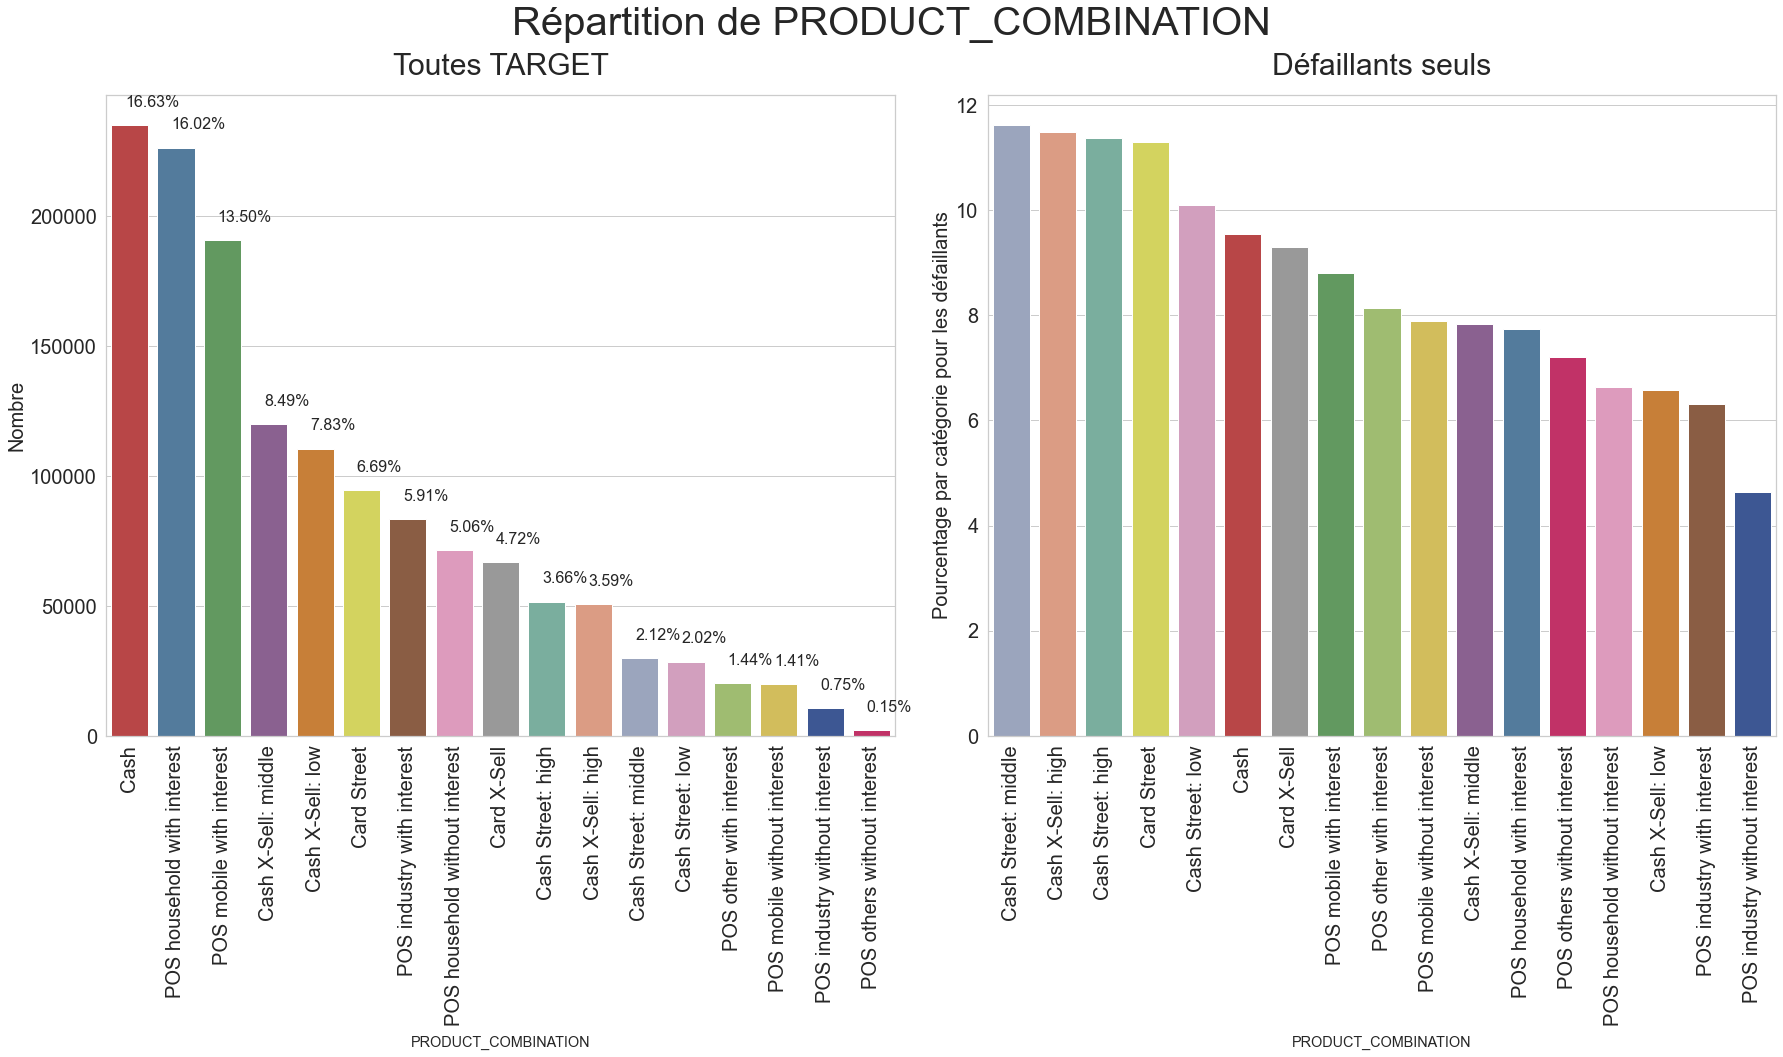

In [16]:
# Let us first see the unique categories of 'CREDIT_ACTIVE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'PRODUCT_COMBINATION',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='PRODUCT_COMBINATION',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(25, 15), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999', '#72b6a1',
                                             '#e99675', '#95a3c3',
                                             '#db96c0', '#a2c865',
                                             '#e5c949', '#2f51a1',
                                             '#d91a61'],
                                   palette2=['#95a3c3', '#e99675',
                                             '#72b6a1', '#e6e64c',
                                             '#db96c0', '#cb3335',
                                             '#999999', '#59a257',
                                             '#a2c865', '#e5c949',
                                             '#905998', '#477ca8',
                                             '#d91a61', '#e890be',
                                             '#df7f20', '#965a38',
                                             '#2f51a1'])

**Bilan** :
***
A partir de la distribution de PRODUCT_COMBINATION, nous pouvons générer les informations suivantes :
- Les trois types de combinaison de produits les plus courants sont l'argent liquide, les points de vente domestiques avec intérêt et les points de vente mobiles avec intérêt. Ils correspondent à environ 50% de toutes les demandes.
- En regardant le graphique du pourcentage de défaillants par catégorie, nous constatons que la tendance à la défaillance est la plus élevée chez Cash Street : catégorie mobile, Cash X-sell : élevé, Cash Street : élevé et Card Street qui sont tous proches de 11-11,5% de défaillants par catégorie. Le pourcentage le plus faible de défaillants se trouve dans la catégorie POS Industry without interest, qui correspond à environ 4,5% de défaillants.

<span style='background:PaleGreen'>**Variable WEEKDAY_APPR_PROCESS_START**</span>

Quel jour de la semaine le demandeur a-t-il demandé le prêt ?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'WEEKDAY_APPR_PROCESS_START' sont :
['SATURDAY' 'FRIDAY' 'SUNDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'WEDNESDAY'
 nan]
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
WEDNESDAY    215519
TUESDAY      215058
MONDAY       214509
FRIDAY       213373
THURSDAY     211005
SATURDAY     204159
SUNDAY       140078
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour WEEKDAY_APPR_PROCESS_START = 8


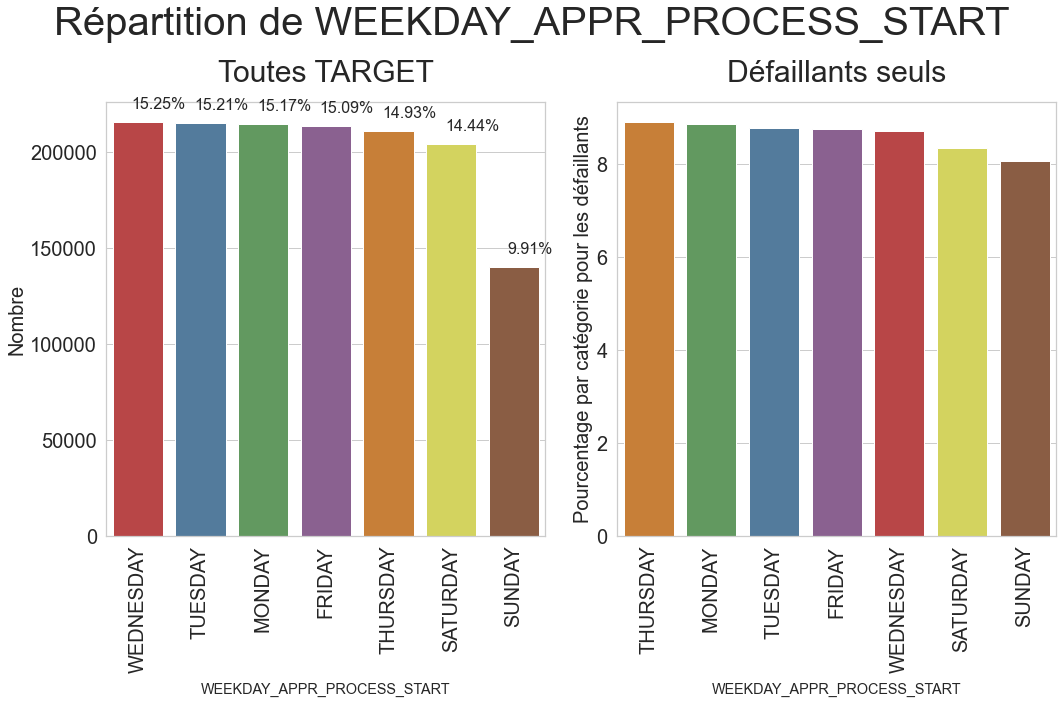

In [17]:
# Let us first see the unique categories of 'WEEKDAY_APPR_PROCESS_START'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'WEEKDAY_APPR_PROCESS_START',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='WEEKDAY_APPR_PROCESS_START',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(15, 10), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38'],
                                   palette2=['#df7f20', '#59a257',
                                             '#477ca8', '#905998',
                                             '#cb3335', '#e6e64c',
                                             '#965a38'])

**Bilan** :
***
- Plutôt en semaine qu'en week-end, indifféremment des jours que ce soit pour les défaillants ou les non-défaillants.

<span style='background:PaleGreen'>**Variable FLAG_LAST_APPL_PER_CONTRACT**</span>

- Indicateur si c'était la dernière demande pour le contrat précédent :
    - **Y** : OUI,
    - **N** : NON.
- Parfois par erreur du demandeur ou de notre greffier il peut y avoir plusieurs demandes pour un seul contrat.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'FLAG_LAST_APPL_PER_CONTRACT' sont :
['Y' nan 'N']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Y    1406387
N       7314
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour FLAG_LAST_APPL_PER_CONTRACT = 3


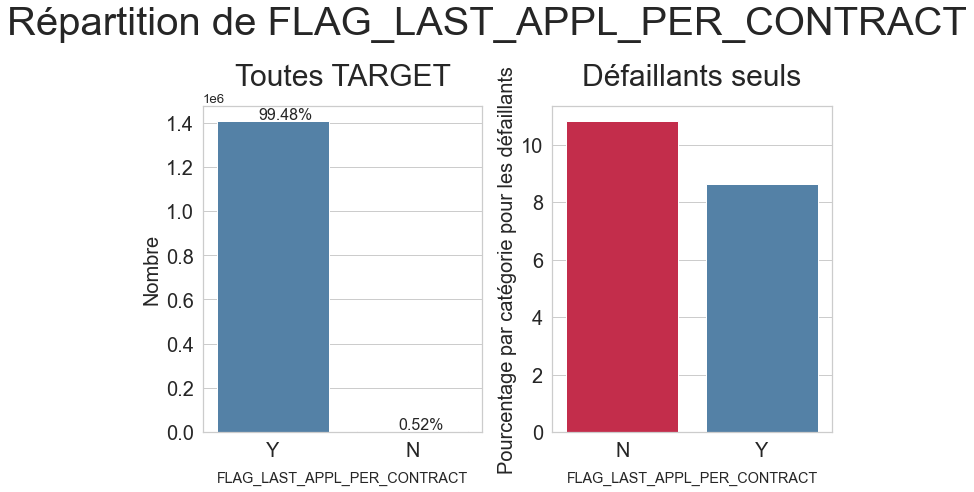

In [62]:
# Let us first see the unique categories of 'FLAG_LAST_APPL_PER_CONTRACT'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'FLAG_LAST_APPL_PER_CONTRACT',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='FLAG_LAST_APPL_PER_CONTRACT',
                                   horizontal_adjust=0.3,
                                   figsize=(10, 7), fontsize_percent=16,
                                   palette1=['SteelBlue', 'crimson'],
                                   palette2=['crimson', 'SteelBlue'])

**Bilan** :
***
- La dernière demande pour le dernier contrat est de 99,5%, mais pour plus de 10% des défaillants, ce n'était pas la dernière demande.

<span style='background:PaleGreen'>**Variable NAME_CASH_LOAN_PURPOSE**</span>

Objectif du prêt d'argent.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CASH_LOAN_PURPOSE' sont :
['XAP' 'XNA' nan 'Other' 'Payments on other loans' 'Buying a used car'
 'Repairs' 'Education' 'Buying a new car' 'Everyday expenses' 'Medicine'
 'Car repairs' 'Urgent needs' 'Buying a holiday home / land'
 'Building a house or an annex' 'Furniture' 'Journey'
 'Purchase of electronic equipment' 'Wedding / gift / holiday'
 'Buying a home' 'Business development' 'Gasification / water supply'
 'Buying a garage' 'Hobby' 'Money for a third person'
 'Refusal to name the goal']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XAP                                 786937
XNA                                 567351
Repairs                              20117
Other                                13432
Urgent needs                          7236
Buying a used car                     2469
B

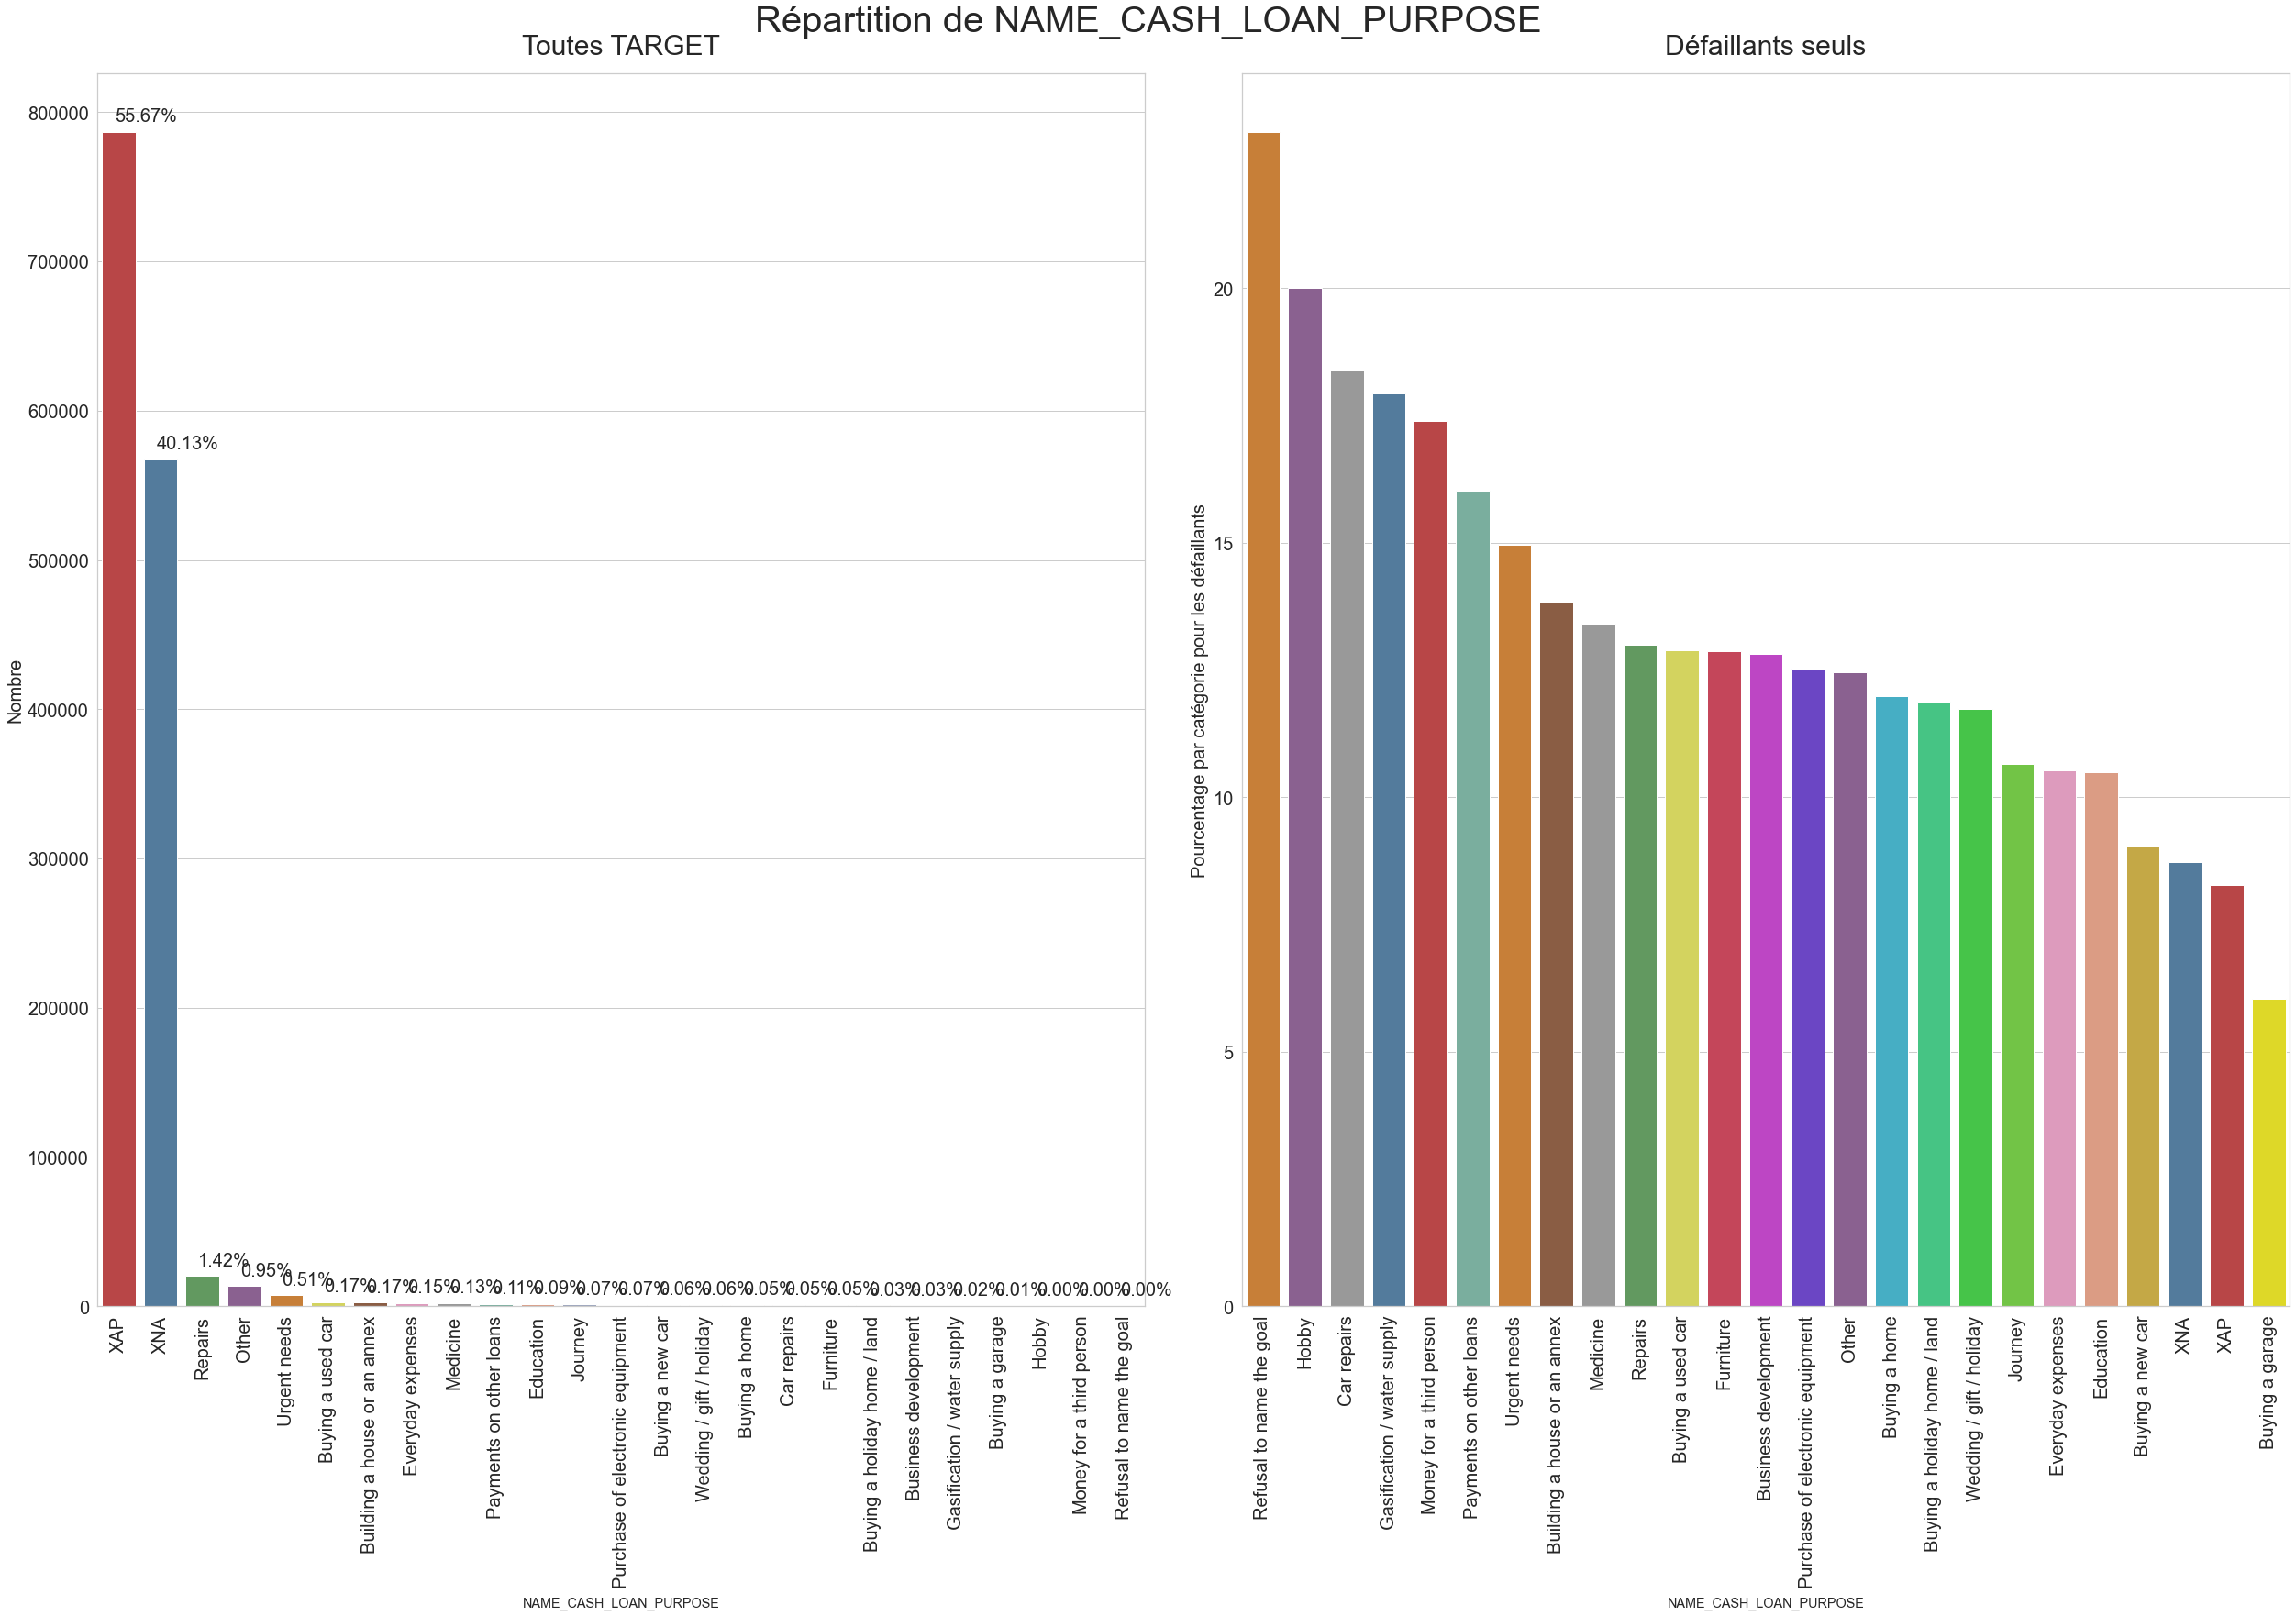

In [18]:
# Let us first see the unique categories of 'NAME_CASH_LOAN_PURPOSE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_CASH_LOAN_PURPOSE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_CASH_LOAN_PURPOSE',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(35, 25), fontsize_percent=20,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999', '#72b6a1',
                                             '#e99675', '#95a3c3',
                                             '#db96c0', '#a2c865',
                                             '#e5c949', '#df7f20',
                                             '#905998', '#52d26c',
                                             '#c48f1e', '#cc5bdb',
                                             '#7b358b', '#ebf633',
                                             '#cb245d', '#51e787',
                                             '#33f3f6'],
                                   palette2=['#df7f20', '#905998',
                                             '#999999', '#477ca8',
                                             '#cb3335', '#72b6a1',
                                             '#df7f20', '#965a38',
                                             '#999999', '#59a257',
                                             '#e6e64c', '#d9314b',
                                             '#cf31d9', '#6231d9',
                                             '#905998', '#31bcd9',
                                             '#31d983', '#31d935',
                                             '#6cd931', '#e890be',
                                             '#e99675', '#d9b331',
                                             '#477ca8', '#cb3335',
                                             '#fcf40a'])

**Bilan** :
***
- Les catégories des défaillants ne sont pas celles de l'ensemble catégories : XAP et XNA.

<span style='background:PaleGreen'>**Variable NAME_PAYMENT_TYPE**</span>

Mode de paiement que le demandeur a choisi pour payer la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_PAYMENT_TYPE' sont :
['XNA' 'Cash through the bank' nan 'Non-cash from your account'
 'Cashless from the account of the employer']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Cash through the bank                        882700
XNA                                          522960
Non-cash from your account                     7100
Cashless from the account of the employer       941
Name: NAME_PAYMENT_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_PAYMENT_TYPE = 5


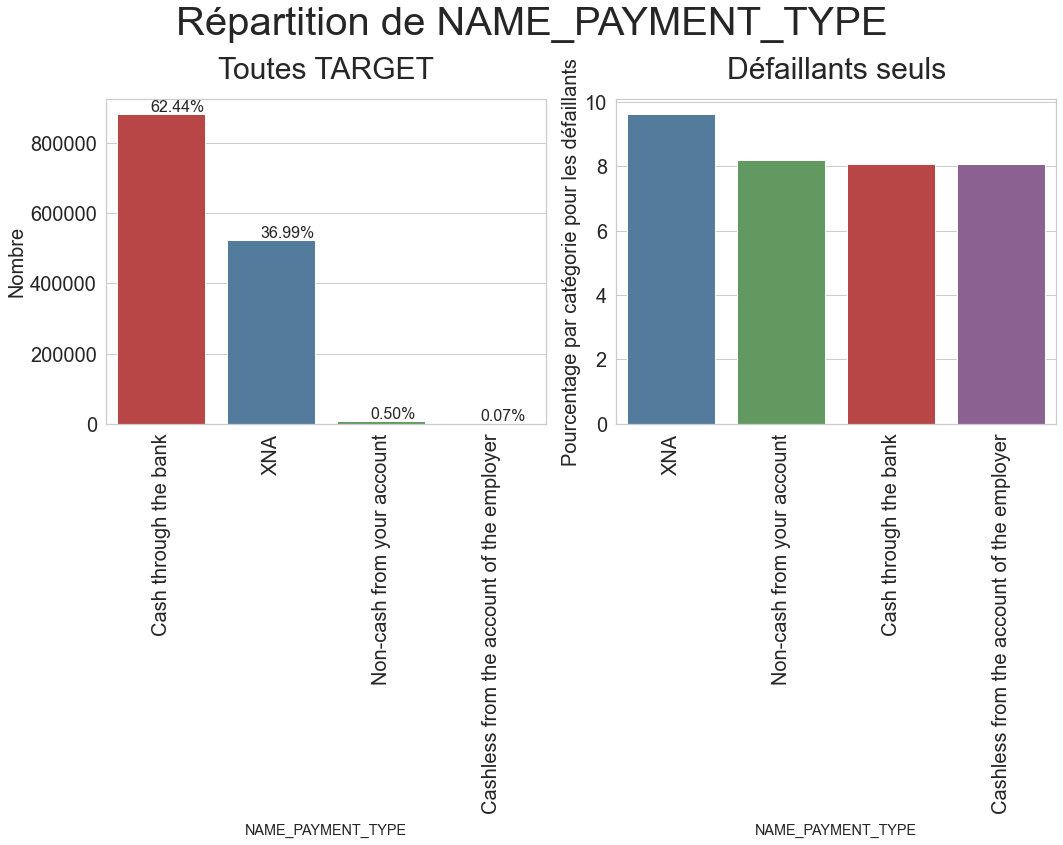

In [19]:
# Let us first see the unique categories of 'NAME_PAYMENT_TYPE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_PAYMENT_TYPE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_PAYMENT_TYPE',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(15, 12), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#477ca8', '#59a257',
                                             '#cb3335', '#905998'])

**Bilan** :
***
- Les défaillants ont des catégories différentes de celles de toutes les catégories 'Cash through the bank'.

<span style='background:PaleGreen'>**Variable NAME_TYPE_SUITE**</span>

Qui a accompagné le demandeur lors de la demande précédente?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_TYPE_SUITE' sont :
[nan 'Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A'
 'Other_B' 'Group of people']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Unaccompanied      427635
Family             181880
Spouse, partner     57586
Children            27106
Other_B             15073
Other_A              7820
Group of people      1929
Name: NAME_TYPE_SUITE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_TYPE_SUITE = 8


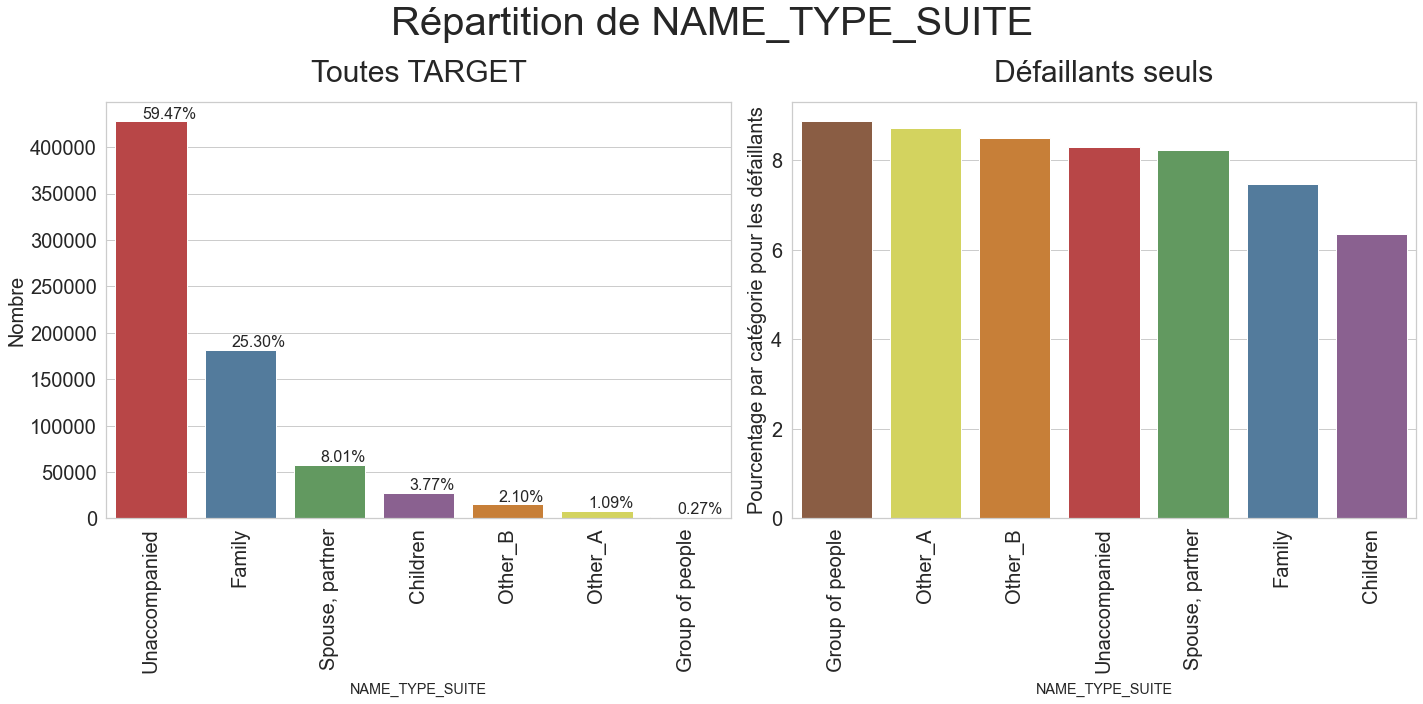

In [20]:
# Let us first see the unique categories of 'NAME_TYPE_SUITE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_TYPE_SUITE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_TYPE_SUITE',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(20, 10), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38'],
                                   palette2=['#965a38', '#e6e64c',
                                             '#df7f20', '#cb3335',
                                             '#59a257', '#477ca8',
                                             '#905998'])

**Bilan** :
***
- Les défaillants sont accompagnés (groupe de personne, Other_A et Other_B...) lors de leur demande de prêt alors que les non-défaillants ne sont pas accompagnés.

<span style='background:PaleGreen'>**Variable NAME_CLIENT_TYPE**</span>

Le demandeur était-il un ancien ou un nouveau demandeur lors de la demande précédente ?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CLIENT_TYPE' sont :
['New' 'Repeater' 'Refreshed' 'XNA' nan]
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Repeater     1037682
New           259540
Refreshed     114936
XNA             1543
Name: NAME_CLIENT_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CLIENT_TYPE = 5


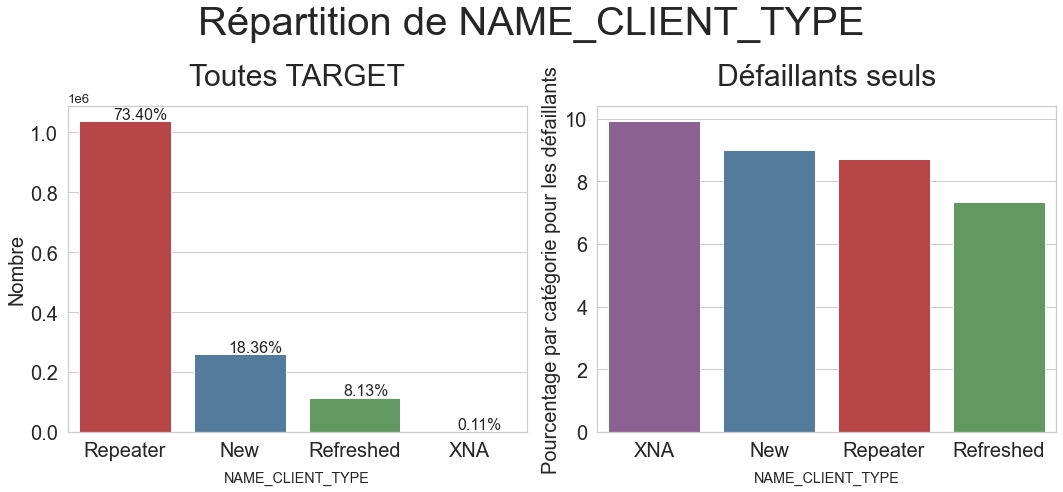

In [21]:
# Let us first see the unique categories of 'NAME_CLIENT_TYPE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_CLIENT_TYPE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_CLIENT_TYPE',
                                   horizontal_adjust=0.3,
                                   figsize=(15, 7), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#905998', '#477ca8',
                                             '#cb3335', '#59a257'])

**Bilan** :
***
- La majorité des demandeurs non-défaillants ont déjà effectué un prêt mais pour les non-défaillants, la plupart sont nouveaux nouveaux ou n'ont pas voulu donner cette information.

<span style='background:PaleGreen'>**Variable NAME_GOODS_CATEGORY**</span>

Quel type de marchandises le demandeur a-t-il demandé dans la demande précédente ?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_GOODS_CATEGORY' sont :
['Vehicles' 'XNA' 'Furniture' 'Consumer Electronics' 'Mobile'
 'Audio/Video' 'Construction Materials' 'Gardening'
 'Photo / Cinema Equipment' 'Computers' 'Clothing and Accessories' nan
 'Homewares' 'Medical Supplies' 'Other' 'Jewelry' 'Office Appliances'
 'Tourism' 'Auto Accessories' 'Sport and Leisure' 'Medicine' 'Weapon'
 'Direct Sales' 'Fitness' 'Insurance' 'Additional Service' 'Education'
 'Animals']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XNA                         797209
Mobile                      193743
Consumer Electronics        104785
Computers                    89923
Audio/Video                  85502
Furniture                    45439
Photo / Cinema Equipment     21707
Construction Materials       21356
Clothing and Accessories     19590
Auto Accessori

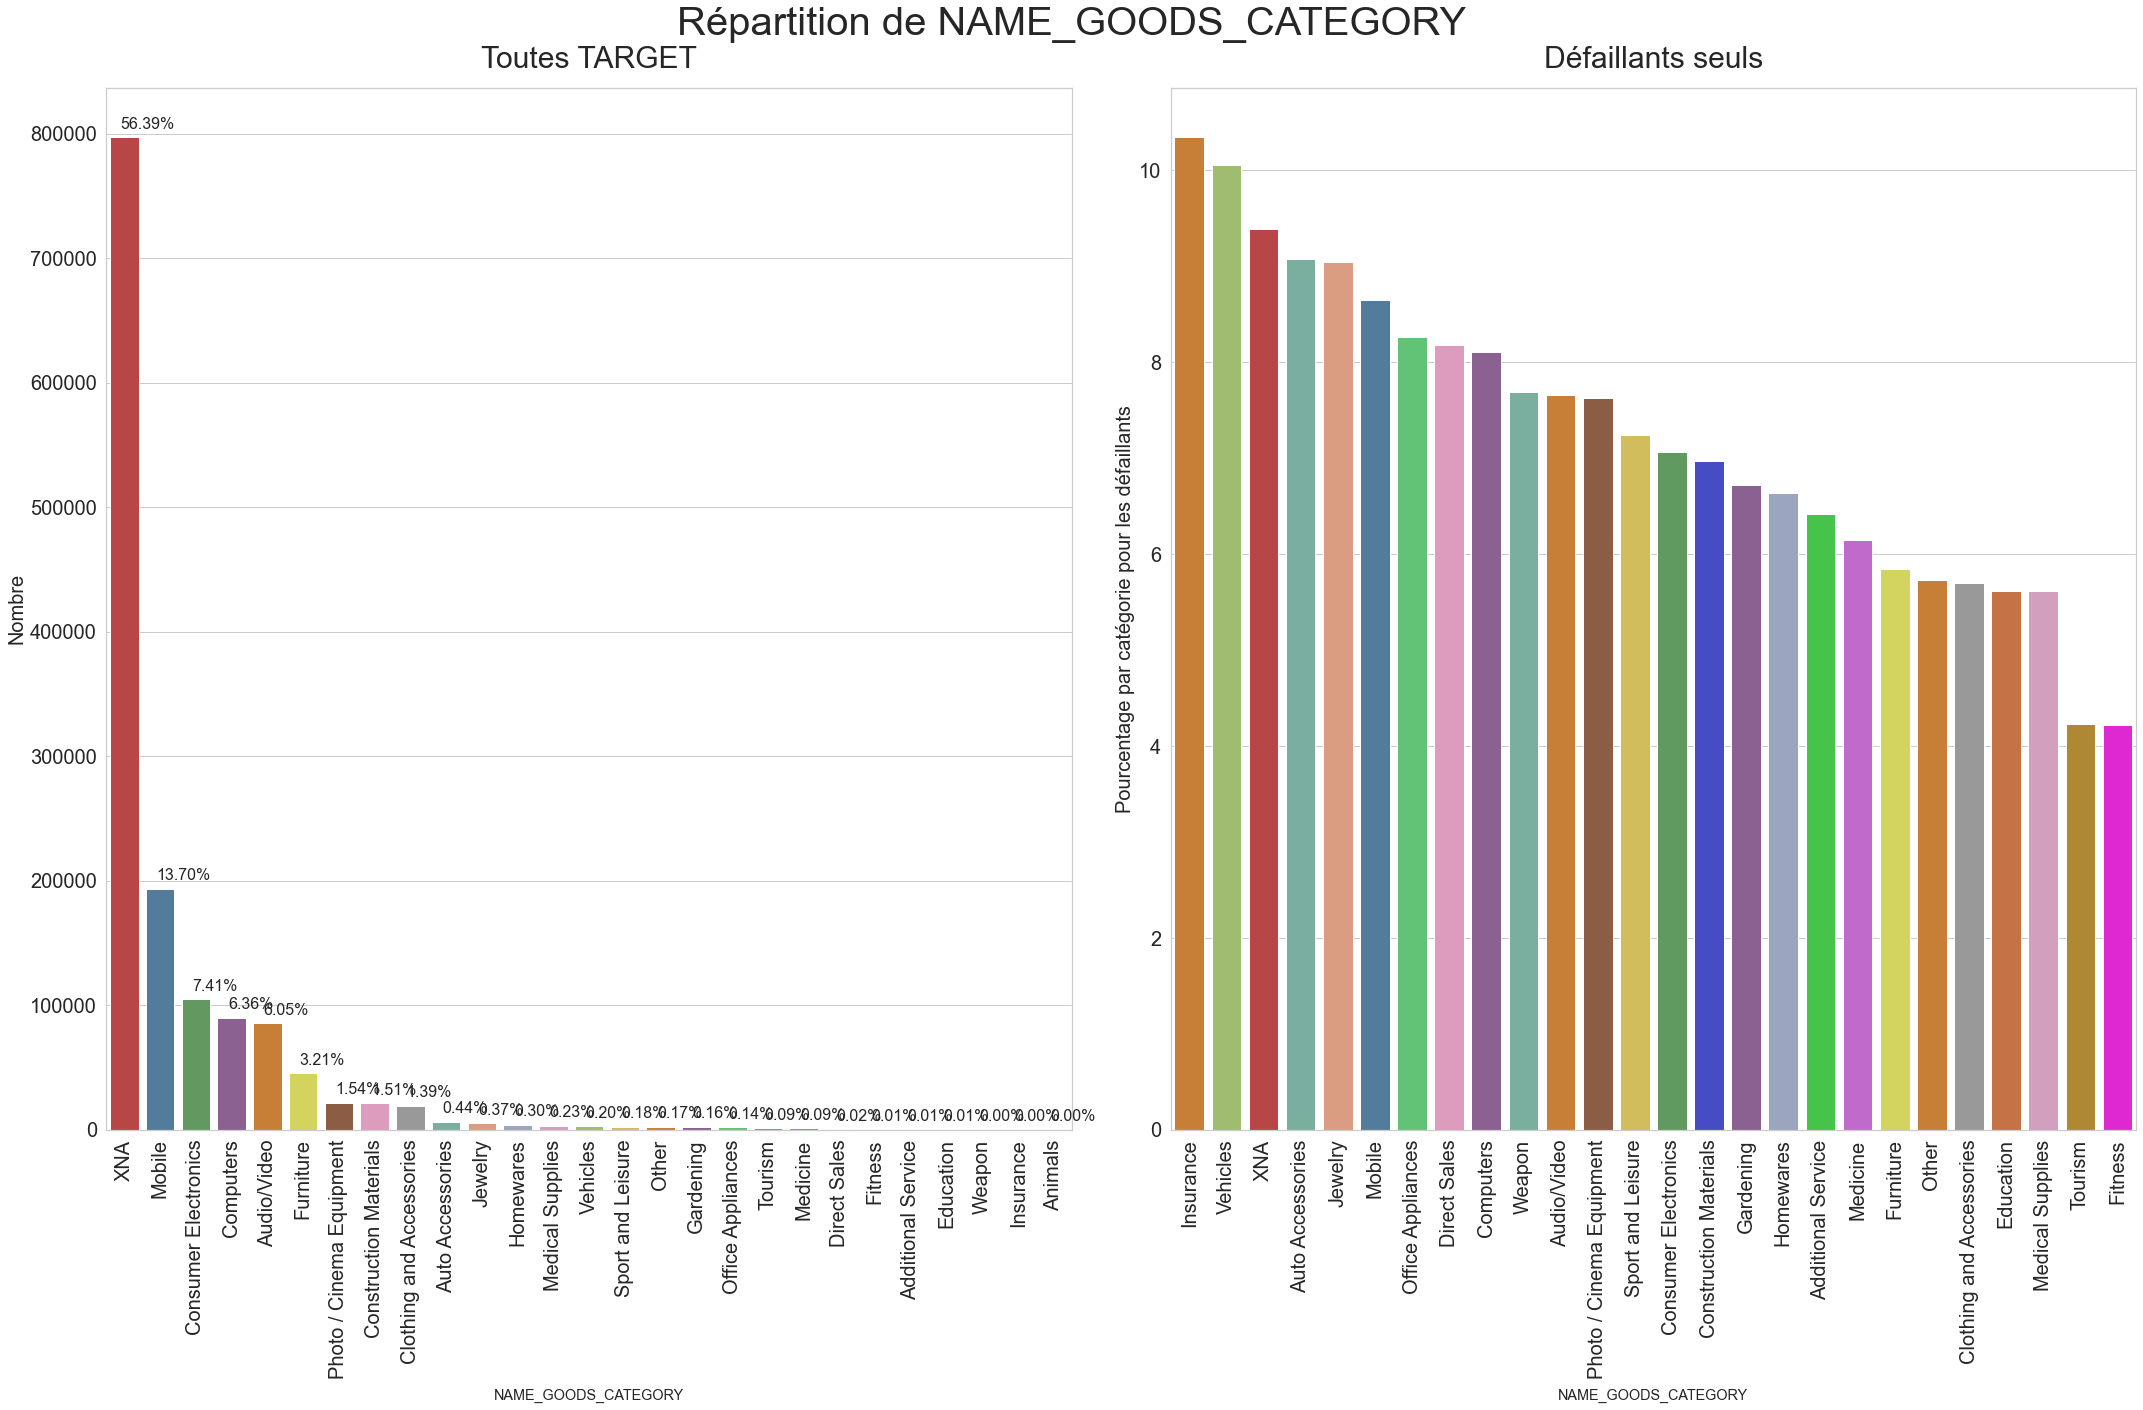

In [22]:
# Let us first see the unique categories of 'NAME_GOODS_CATEGORY'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_GOODS_CATEGORY',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_GOODS_CATEGORY',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(30, 20), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999', '#72b6a1',
                                             '#e99675', '#95a3c3',
                                             '#db96c0', '#a2c865',
                                             '#e5c949', '#df7f20',
                                             '#905998', '#52d26c',
                                             '#c48f1e', '#cc5bdb',
                                             '#7b358b', '#ebf633',
                                             '#cb245d', '#51e787',
                                             '#33f3f6', '#9c75aa',
                                             '#423d78'],
                                   palette2=['#df7f20', '#a2c865',
                                             '#cb3335', '#72b6a1',
                                             '#e99675', '#477ca8',
                                             '#52d26c', '#e890be',
                                             '#905998', '#72b6a1',
                                             '#df7f20', '#965a38',
                                             '#e5c949', '#59a257',
                                             '#313ad9', '#905998',
                                             '#95a3c3', '#31d935',
                                             '#cc5bdb', '#e6e64c',
                                             '#df7f20', '#999999',
                                             '#d96b31', '#db96c0',
                                             '#c48f1e', '#fc0aec'])

**Bilan** :
***
- La majorité ne précisent pas l'objet de leur future dépense mais les équipements achetés sont plutôt de haute technologie alors que les défaillants ont des préoccupations plus terre à terre que loisirs... les assurance et les véhicules.

<span style='background:PaleGreen'>**Variable NAME_PORTFOLIO**</span>

Est-ce que l'application précédente était pour CASH ou POS ou CAR ... ?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_PORTFOLIO' sont :
['POS' 'Cash' 'XNA' 'Cards' nan 'Cars']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
POS      592460
Cash     391663
XNA      307213
Cards    121985
Cars        380
Name: NAME_PORTFOLIO, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_PORTFOLIO = 6


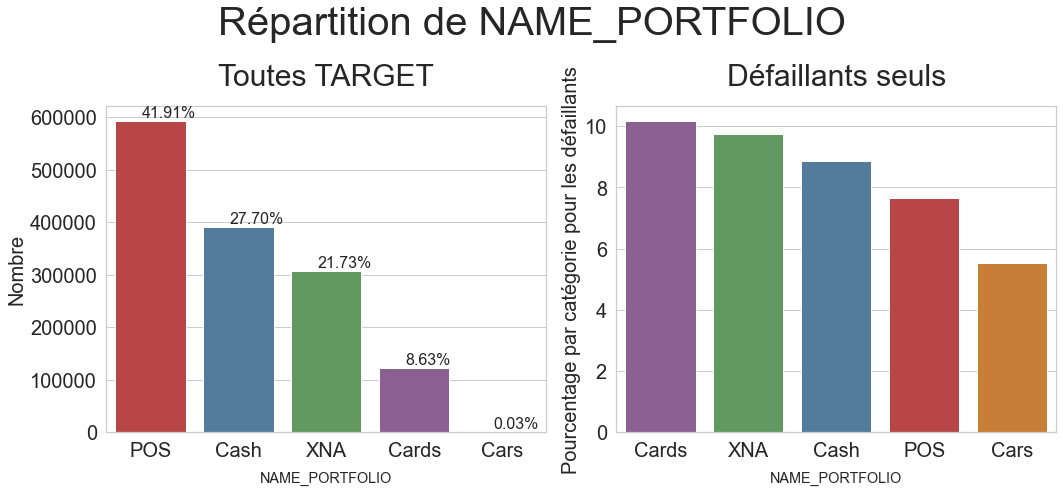

In [23]:
# Let us first see the unique categories of 'NAME_PORTFOLIO'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_PORTFOLIO',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_PORTFOLIO',
                                   horizontal_adjust=0.3,
                                   figsize=(15, 7), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20'],
                                   palette2=['#905998', '#59a257',
                                             '#477ca8', '#cb3335',
                                             '#df7f20'])

**Bilan** :
***
- L'application précédente de la majorité était POSH (42%) mais pour les défaillants l'application est Cards.

<span style='background:PaleGreen'>**Variable NAME_PRODUCT_TYPE**</span>

L'application précédente était-elle x-sell o walk-in ?

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_PRODUCT_TYPE' sont :
['XNA' 'x-sell' 'walk-in' nan]
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XNA        900053
x-sell     385394
walk-in    128254
Name: NAME_PRODUCT_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_PRODUCT_TYPE = 4


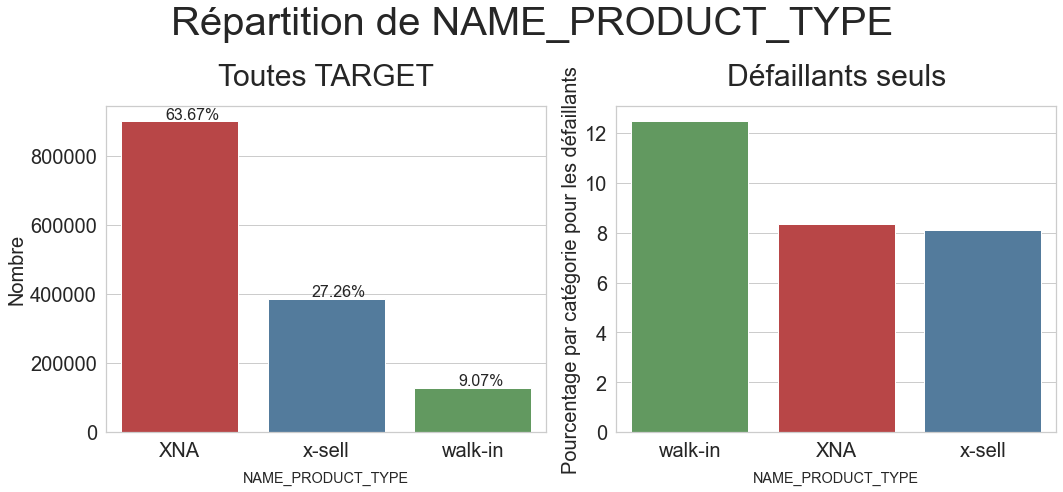

In [24]:
# Let us first see the unique categories of 'NAME_PRODUCT_TYPE'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_PRODUCT_TYPE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_PRODUCT_TYPE',
                                   horizontal_adjust=0.3,
                                   figsize=(15, 7), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257'],
                                   palette2=['#59a257', '#cb3335',
                                             '#477ca8'])

**Bilan** :
***
- Parmi les personnes qui ont répondu, l'ordre du type d'application précédente est inversée entre les défaillants (walk-in puis x-sell) et les non-défaillants (x-sell puis walk-in).
- L'information est également plus renseignée pour les non-défaillants.

<span style='background:PaleGreen'>**Variable NAME_SELLER_INDUSTRY**</span>

Secteur d'activité du vendeur.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_SELLER_INDUSTRY' sont :
['Auto technology' 'XNA' 'Furniture' 'Consumer electronics' 'Connectivity'
 'Construction' 'Clothing' nan 'Industry' 'Tourism' 'Jewelry'
 'MLM partners']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XNA                     715322
Consumer electronics    341701
Connectivity            238350
Furniture                48966
Construction             25417
Clothing                 19896
Industry                 16567
Auto technology           4080
Jewelry                   2107
MLM partners               921
Tourism                    374
Name: NAME_SELLER_INDUSTRY, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_SELLER_INDUSTRY = 12


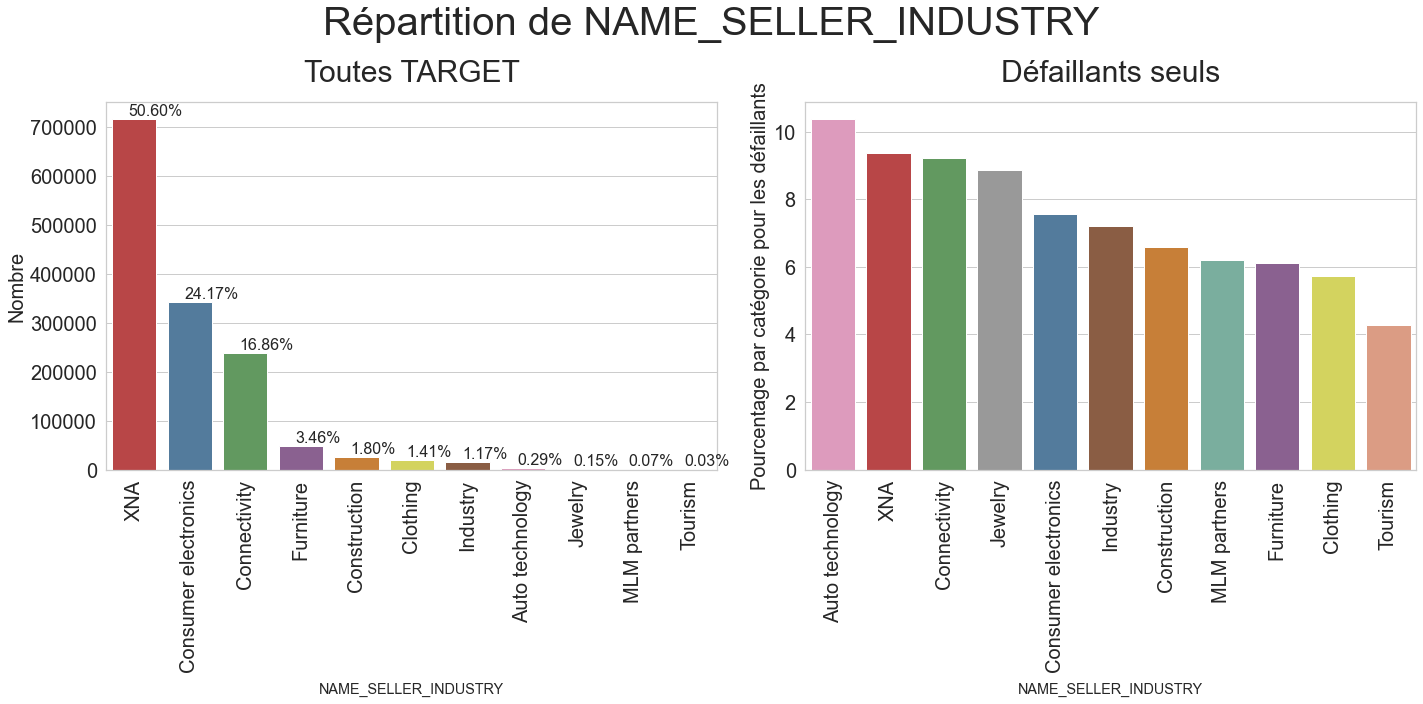

In [26]:
# Let us first see the unique categories of 'NAME_SELLER_INDUSTRY'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_SELLER_INDUSTRY',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_SELLER_INDUSTRY',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(20, 10), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999', '#72b6a1',
                                             '#e99675'],
                                   palette2=['#e890be', '#cb3335',
                                             '#59a257', '#999999',
                                             '#477ca8', '#965a38',
                                             '#df7f20', '#72b6a1',
                                             '#905998', '#e6e64c',
                                             '#e99675'])

**Bilan** :
***


<span style='background:PaleGreen'>**Variable NAME_YIELD_GROUP**</span>

Taux d'intérêt groupé en petit moyen et élevé de la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_YIELD_GROUP' sont :
['low_normal' 'middle' 'XNA' 'high' 'low_action' nan]
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XNA           429198
middle        324971
high          306061
low_normal    274884
low_action     78587
Name: NAME_YIELD_GROUP, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_YIELD_GROUP = 6


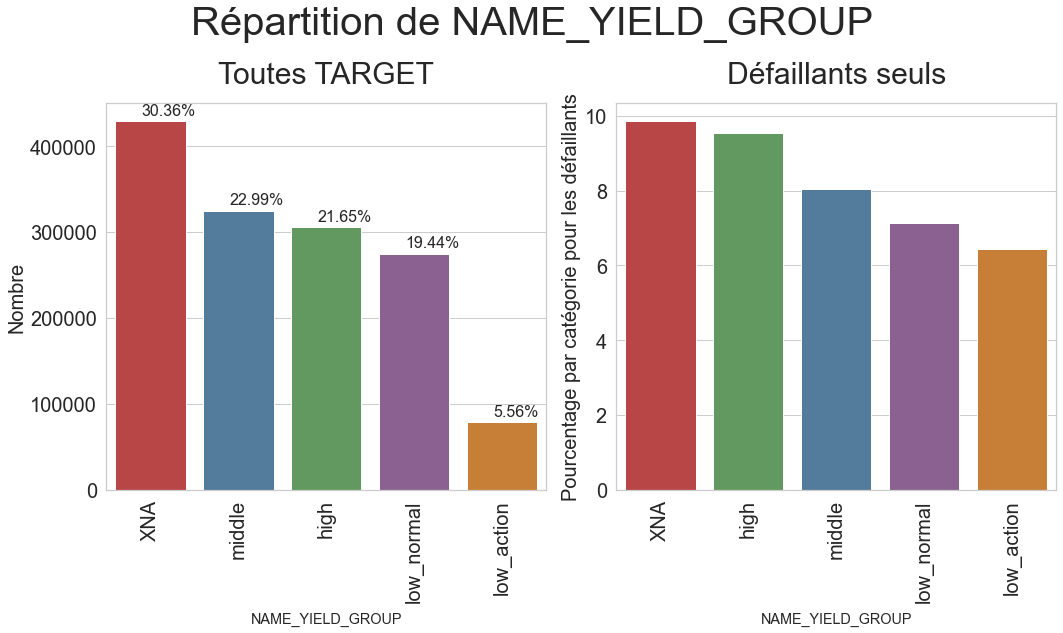

In [27]:
# Let us first see the unique categories of 'NAME_YIELD_GROUP'
eda_kernel_fonctions.print_unique_categories(prev_merged,
                                             'NAME_YIELD_GROUP',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
eda_kernel_fonctions. \
    plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_YIELD_GROUP',
                                   horizontal_adjust=0.3, rotation=90,
                                   figsize=(15, 9), fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20'],
                                   palette2=['#cb3335', '#59a257',
                                             '#477ca8', '#905998',
                                             '#df7f20'])

**Bilan** :
***
- Les taux d'intérêt groupé de la demande précédente sont moyens pour les non-défaillants et élevés pour les défaillants.

***
<span style='background:Plum'>**Distribution des variables quantitatives**</span>
***

In [99]:
# Liste des variables quantitatives
cols_num_prev = \
    prev_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num_prev

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

<span style='background:PaleGreen'>**Variable DAYS_DECISION**</span>

Cette variable indique le nombre de jours, par rapport à la demande actuelle, où la décision a été prise concernant la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_DECISION
Pecentile 0 = -2922.0
Pecentile 2 = -2748.0
Pecentile 4 = -2612.0
Pecentile 6 = -2499.0
Pecentile 8 = -2383.0
Pecentile 10 = -2257.0
Pecentile 25 = -1313.0
Pecentile 50 = -582.0
Pecentile 75 = -271.0
Pecentile 100 = -1.0
-------------------------------------------------------------------------------


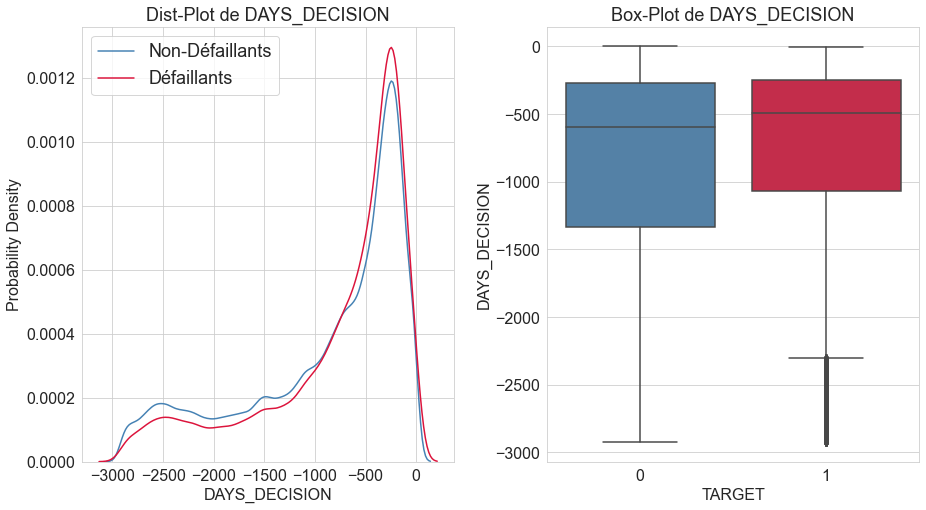

In [14]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'DAYS_DECISION',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_DECISION',
                                               plots=['distplot', 'box'],
                                               figsize=(15, 8))

**Bilan** :
***
- Dans le graphique ci-dessus, nous remarquons que pour les défaillants, le nombre de jours depuis lequel la décision a été prise est un peu moins élevé que pour les non-défaillants.
- Cela implique que la décision sur les demandes précédentes des défaillants est généralement plus récente que celle des non-défaillants.

<span style='background:PaleGreen'>**Variable DAYS_FIRST_DRAWING**</span>

Cette variable indique le nombre de jours depuis la demande actuelle où le premier déboursement de la demande précédente a été effectué.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_FIRST_DRAWING
Pecentile 0 = -2922.0
Pecentile 1 = -2451.0
Pecentile 2 = -1179.0
Pecentile 3 = -674.0
Pecentile 4 = -406.0
Pecentile 5 = -262.0
Pecentile 6 = -156.0
Pecentile 7 = 365243.0
Pecentile 8 = 365243.0
Pecentile 9 = 365243.0
Pecentile 10 = 365243.0
Pecentile 20 = 365243.0
Pecentile 40 = 365243.0
Pecentile 60 = 365243.0
Pecentile 80 = 365243.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


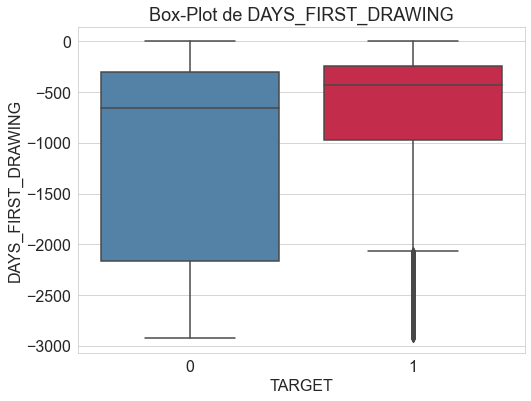

In [17]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING',
                      percentiles=list(range(0, 11)) +
                      list(range(20, 101, 20)))
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_FIRST_DRAWING',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[-3000, 0])

**Bilan** :
***
- En regardant les valeurs du quantile de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées, à commencer par les valeurs du 7ème percentile lui-même.
- Ces valeurs erronées devront être éliminées.
- Si nous essayons d'analyser la distribution de cette variable en supprimant les ponts erronés, nous constatons que la plupart des défaillants ont eu leur premier versement sur un crédit précédent plus récemment que les non-défaillants. 
- La valeur du 75e percentile pour les défaillants est également nettement inférieure à celle des non-défaillants.

**Ces variables décrivent également le nombre de jours depuis l'application actuelle où certaines activités ont eu lieu.**

<span style='background:PaleGreen'>**Variable DAYS_FIRST_DUE**</span>

Par rapport à la date d'application de l'application actuelle quand la première échéance était-elle censée être celle de l'application précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_FIRST_DUE
Pecentile 0 = -2892.0
Pecentile 2 = -2759.0
Pecentile 4 = -2648.0
Pecentile 6 = -2555.0
Pecentile 8 = -2471.0
Pecentile 10 = -2388.0
Pecentile 20 = -1882.0
Pecentile 40 = -1070.0
Pecentile 60 = -647.0
Pecentile 80 = -329.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


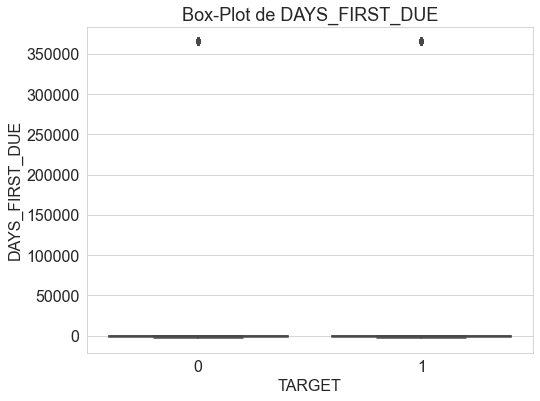

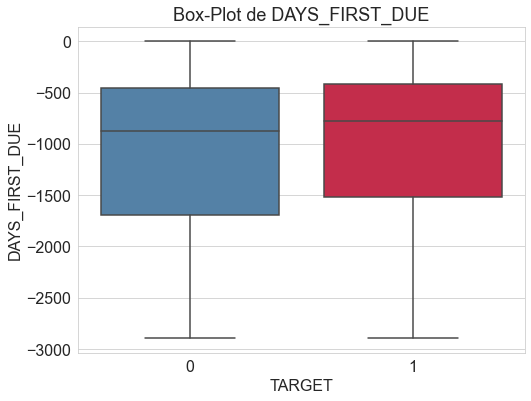

In [21]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'DAYS_FIRST_DUE',
                      percentiles=list(range(0, 11, 2)) +
                      [20, 40, 60, 80, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_FIRST_DUE',
                                               plots=['box'],
                                               figsize=(8, 6))
# Zoom
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_FIRST_DUE',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[-3000, 0])

<span style='background:PaleGreen'>**Variable DAYS_LAST_DUE**</span>

Par rapport à la date de demande de la demande actuelle quelle était la première échéance de la demande précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_LAST_DUE
Pecentile 0 = -2889.0
Pecentile 2 = -2534.0
Pecentile 4 = -2400.0
Pecentile 6 = -2290.0
Pecentile 8 = -2186.0
Pecentile 10 = -2079.0
Pecentile 20 = -1554.0
Pecentile 40 = -784.0
Pecentile 60 = -333.0
Pecentile 80 = 365243.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


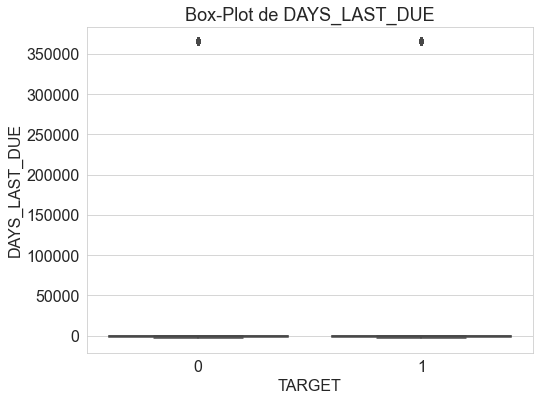

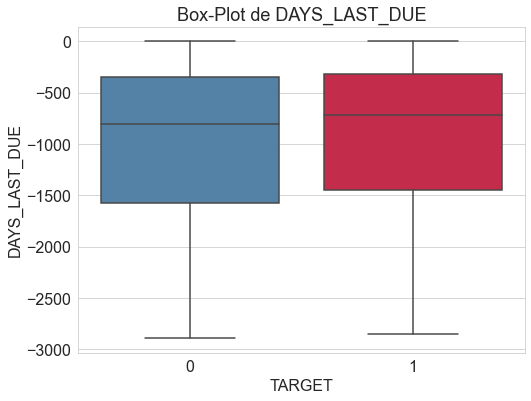

In [22]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'DAYS_LAST_DUE',
                      percentiles=list(range(0, 11, 2)) +
                      [20, 40, 60, 80, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_LAST_DUE',
                                               plots=['box'],
                                               figsize=(8, 6))
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_LAST_DUE',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[-3000, 0])

<span style='background:PaleGreen'>**Variable DAYS_LAST_DUE_1ST_VERSION**</span>

Par rapport à la date de demande de la demande actuelle quelle était la première échéance de la demande précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_LAST_DUE_1ST_VERSION
Pecentile 0 = -2801.0
Pecentile 2 = -2516.0
Pecentile 4 = -2380.0
Pecentile 6 = -2267.0
Pecentile 8 = -2159.0
Pecentile 10 = -2045.0
Pecentile 20 = -1498.0
Pecentile 40 = -644.0
Pecentile 60 = -146.0
Pecentile 80 = 273.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


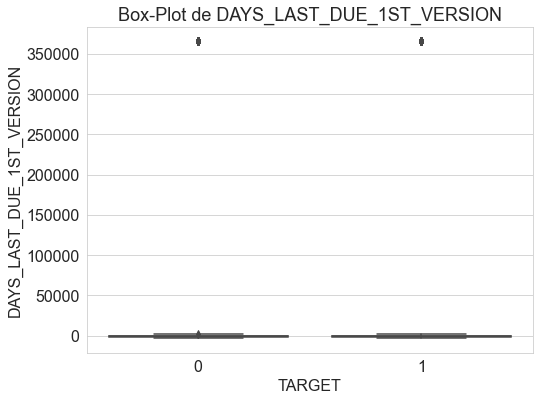

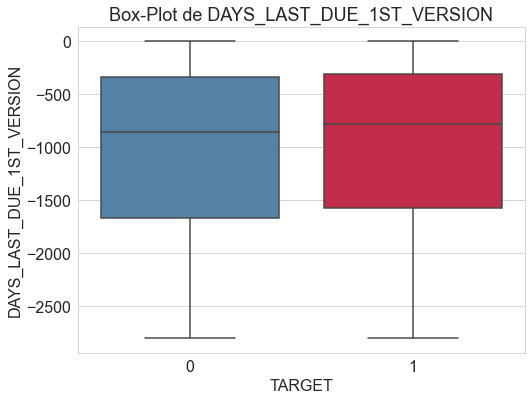

In [23]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION',
                      percentiles=list(range(0, 11, 2)) +
                      [20, 40, 60, 80, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_LAST_DUE_1ST_VERSION',
                                               plots=['box'],
                                               figsize=(8, 6))
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_LAST_DUE_1ST_VERSION',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[-3000, 0])

<span style='background:PaleGreen'>**Variable DAYS_TERMINATION**</span>

Par rapport à la date d'application de l'application actuelle quand était prévue la fin de l'application précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_TERMINATION
Pecentile 0 = -2874.0
Pecentile 2 = -2523.0
Pecentile 4 = -2383.0
Pecentile 6 = -2270.0
Pecentile 8 = -2161.0
Pecentile 10 = -2048.0
Pecentile 20 = -1508.0
Pecentile 40 = -743.0
Pecentile 60 = -297.0
Pecentile 80 = 365243.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


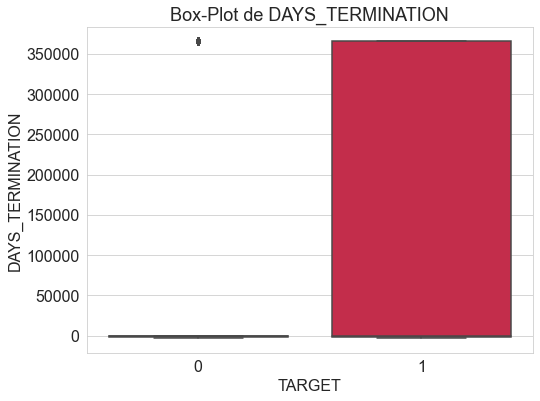

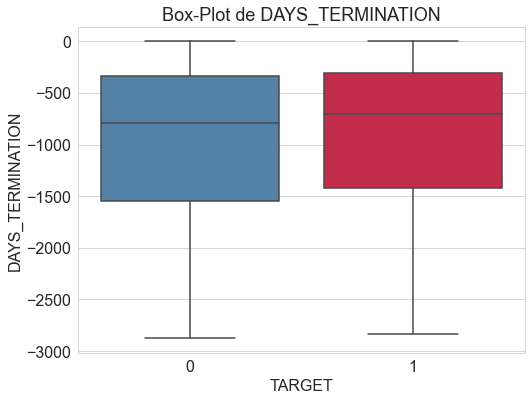

In [12]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'c',
                      percentiles=list(range(0, 11, 2)) +
                      [20, 40, 60, 80, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_TERMINATION',
                                               plots=['box'],
                                               figsize=(8, 6))
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'DAYS_TERMINATION',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[-3000, 0])

**Bilan** :
***
- A partir de toutes les valeurs de percentile ci-dessus, nous nous rendons compte que toutes les variables Days ont ces valeurs erronées quelque part. - Ces valeurs doivent donc être remplacées afin que notre modèle ne soit pas affecté par celles-ci.

<span style='background:PaleGreen'>**Variable AMT_ANNUITY**</span>

Annuité de la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_ANNUITY
Pecentile 0 = 0.0
Pecentile 2 = 2250.0
Pecentile 4 = 2396.79
Pecentile 6 = 2984.4414
Pecentile 8 = 3375.0
Pecentile 10 = 3790.9890000000005
Pecentile 25 = 6257.8575
Pecentile 50 = 11223.765
Pecentile 75 = 20420.775
Pecentile 100 = 418058.145
-------------------------------------------------------------------------------


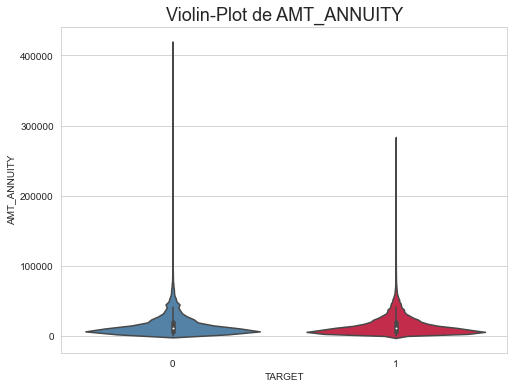

In [13]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'AMT_ANNUITY',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'AMT_ANNUITY',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable AMT_APPLICATION**</span>

Pour quel montant de crédit le demandeur a-t-il demandé lors de la demande précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_APPLICATION
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 19750.5
Pecentile 50 = 70870.5
Pecentile 75 = 180000.0
Pecentile 100 = 5850000.0
-------------------------------------------------------------------------------


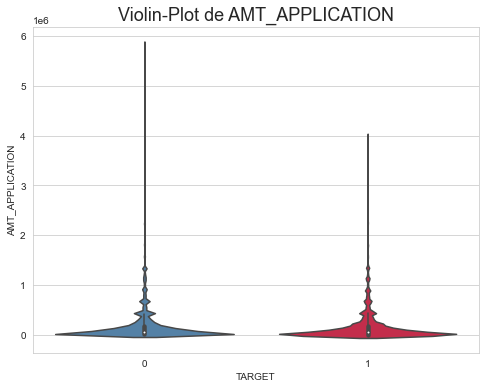

In [14]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'AMT_APPLICATION',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'AMT_APPLICATION',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable AMT_CREDIT**</span>

- Montant final du crédit sur la demande précédente.
- Il diffère de AMT_APPLICATION dans la mesure où AMT_APPLICATION est le montant pour lequel le demandeur a initialement fait une demande mais au cours de notre processus d'approbation il aurait pu recevoir un montant différent - AMT_CREDIT.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_CREDIT
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 24880.5
Pecentile 50 = 80595.0
Pecentile 75 = 215640.0
Pecentile 100 = 4509688.5
-------------------------------------------------------------------------------


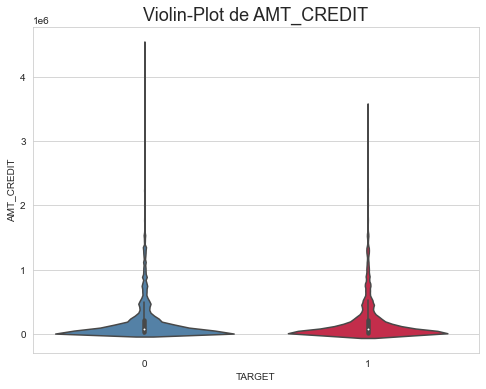

In [15]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'AMT_CREDIT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche bviolinlot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'AMT_CREDIT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable AMT_DOWN_PAYMENT**</span>

Acompte sur la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_DOWN_PAYMENT
Pecentile 0 = -0.9
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 1791.0
Pecentile 75 = 7695.0
Pecentile 100 = 3060045.0
-------------------------------------------------------------------------------


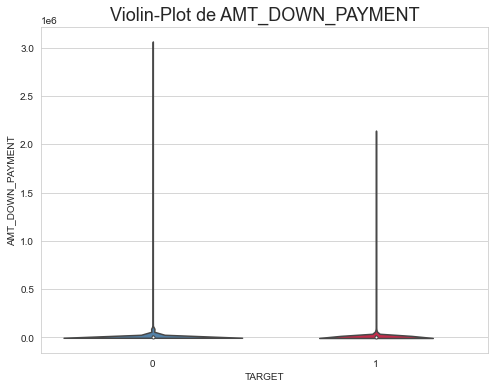

In [16]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'AMT_DOWN_PAYMENT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'AMT_DOWN_PAYMENT',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable AMT_GOODS_PRICE**</span>

Prix du bien que le demandeur a demandé (le cas échéant) sur la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_GOODS_PRICE
Pecentile 0 = 0.0
Pecentile 2 = 17730.0
Pecentile 4 = 21240.0
Pecentile 6 = 24259.23
Pecentile 8 = 26995.5
Pecentile 10 = 30140.55
Pecentile 25 = 49828.5
Pecentile 50 = 110245.5
Pecentile 75 = 229500.0
Pecentile 100 = 5850000.0
-------------------------------------------------------------------------------


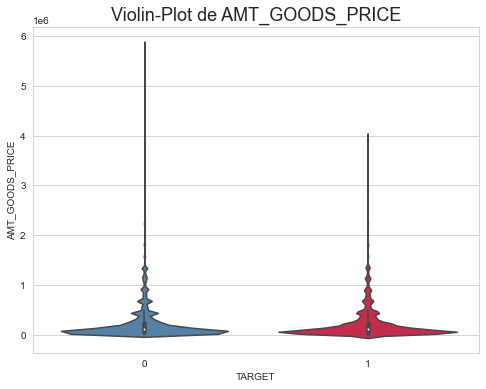

In [17]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'AMT_GOODS_PRICE',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'AMT_GOODS_PRICE',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable HOUR_APPR_PROCESS_START**</span>

À quelle heure environ le demandeur a-t-il fait sa demande pour la demande précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable HOUR_APPR_PROCESS_START
Pecentile 0 = 0.0
Pecentile 2 = 6.0
Pecentile 4 = 7.0
Pecentile 6 = 7.0
Pecentile 8 = 8.0
Pecentile 10 = 8.0
Pecentile 25 = 10.0
Pecentile 50 = 12.0
Pecentile 75 = 15.0
Pecentile 100 = 23.0
-------------------------------------------------------------------------------


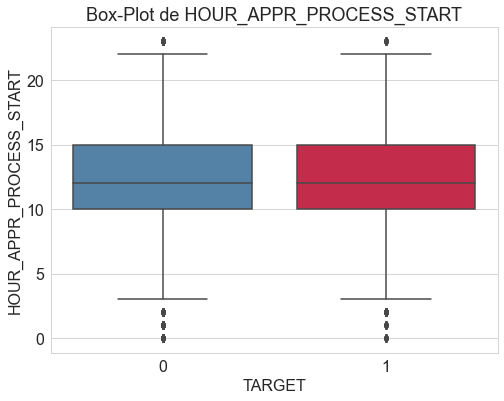

In [18]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'HOUR_APPR_PROCESS_START',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'HOUR_APPR_PROCESS_START',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable NFLAG_LAST_APPL_IN_DAY**</span>

- Indicateur indiquant si la demande était la dernière demande par jour du demandeur.
- Il arrive que les demandeurs postulent pour plusieurs demandes par jour. - Dans de rares cas il peut aussi s'agir d'une erreur de notre système qui fait qu'une demande figure deux fois dans la base de données.

-------------------------------------------------------------------------------
Pecentiles de la variable NFLAG_LAST_APPL_IN_DAY
Pecentile 0 = 0.0
Pecentile 2 = 1.0
Pecentile 4 = 1.0
Pecentile 6 = 1.0
Pecentile 8 = 1.0
Pecentile 10 = 1.0
Pecentile 25 = 1.0
Pecentile 50 = 1.0
Pecentile 75 = 1.0
Pecentile 100 = 1.0
-------------------------------------------------------------------------------


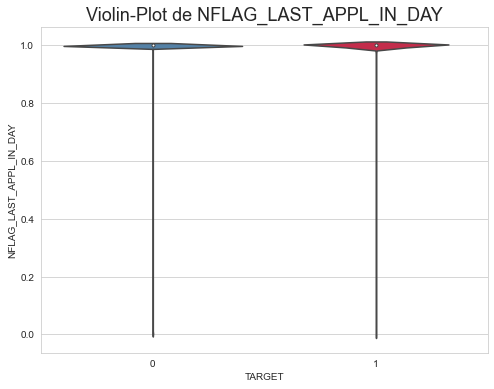

In [19]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'NFLAG_LAST_APPL_IN_DAY',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'NFLAG_LAST_APPL_IN_DAY',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable RATE_DOWN_PAYMENT**</span>

Taux d'acompte normalisé sur le crédit antérieur.

-------------------------------------------------------------------------------
Pecentiles de la variable RATE_DOWN_PAYMENT
Pecentile 0 = -1.4978763414307848e-05
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0624893282871192
Pecentile 75 = 0.108911808824418
Pecentile 100 = 1.0
-------------------------------------------------------------------------------


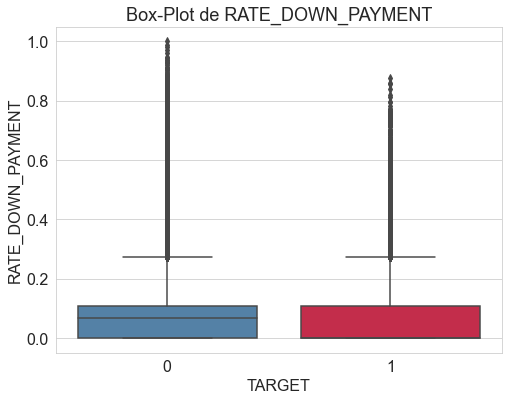

In [20]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'RATE_DOWN_PAYMENT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'RATE_DOWN_PAYMENT',
                                               plots=['box'], figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable RATE_INTEREST_PRIMARY**</span>

Taux d'intérêt normalisé sur le crédit antérieur.

-------------------------------------------------------------------------------
Pecentiles de la variable RATE_INTEREST_PRIMARY
Pecentile 0 = 0.0347812535418791
Pecentile 2 = 0.1421426952283803
Pecentile 4 = 0.1424402130794514
Pecentile 6 = 0.1424402130794514
Pecentile 8 = 0.1424402130794514
Pecentile 10 = 0.1424402130794514
Pecentile 25 = 0.1607163096452454
Pecentile 50 = 0.1891363481808909
Pecentile 75 = 0.1933299331293211
Pecentile 100 = 1.0
-------------------------------------------------------------------------------


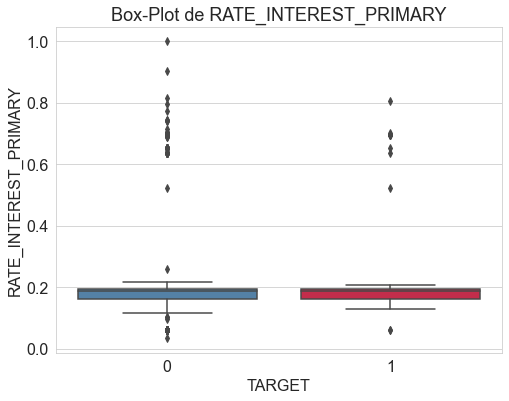

In [21]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'RATE_INTEREST_PRIMARY',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'RATE_INTEREST_PRIMARY',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable RATE_INTEREST_PRIVILEGED**</span>

Taux d'intérêt normalisé sur le crédit antérieur.

-------------------------------------------------------------------------------
Pecentiles de la variable RATE_INTEREST_PRIVILEGED
Pecentile 0 = 0.3731501057082452
Pecentile 2 = 0.5687103594080338
Pecentile 4 = 0.5687103594080338
Pecentile 6 = 0.6379492600422833
Pecentile 8 = 0.6379492600422833
Pecentile 10 = 0.6379492600422833
Pecentile 25 = 0.715644820295983
Pecentile 50 = 0.8350951374207188
Pecentile 75 = 0.852536997885835
Pecentile 100 = 1.0
-------------------------------------------------------------------------------


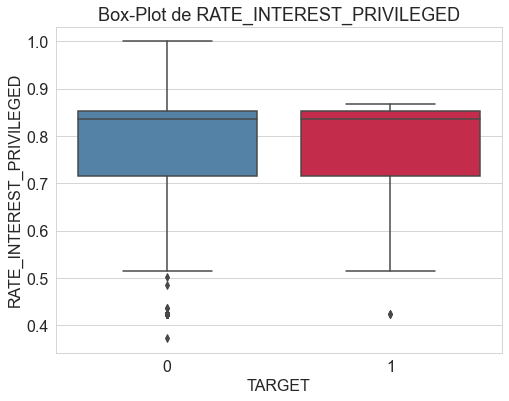

In [22]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'RATE_INTEREST_PRIVILEGED',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'RATE_INTEREST_PRIVILEGED',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable SELLERPLACE_AREA**</span>

Zone de vente du vendeur, lieu de la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable SELLERPLACE_AREA
Pecentile 0 = -1.0
Pecentile 2 = -1.0
Pecentile 4 = -1.0
Pecentile 6 = -1.0
Pecentile 8 = -1.0
Pecentile 10 = -1.0
Pecentile 25 = -1.0
Pecentile 50 = 4.0
Pecentile 75 = 85.0
Pecentile 100 = 4000000.0
-------------------------------------------------------------------------------


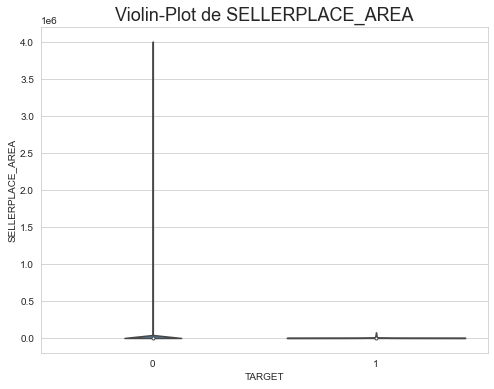

In [23]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'SELLERPLACE_AREA',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'SELLERPLACE_AREA',
                                               plots=['violin'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable CNT_PAYMENT**</span>

Durée du crédit précédent à la demande de la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable CNT_PAYMENT
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 6.0
Pecentile 50 = 12.0
Pecentile 75 = 24.0
Pecentile 100 = 84.0
-------------------------------------------------------------------------------


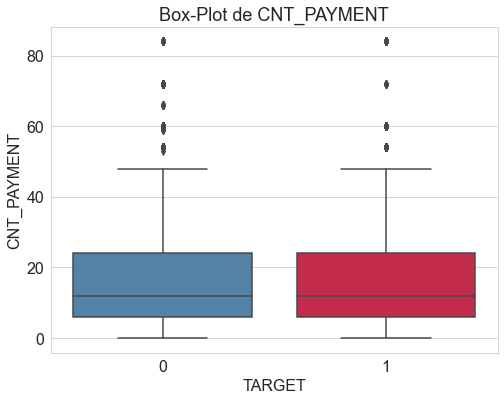

In [24]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'CNT_PAYMENT',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'CNT_PAYMENT',
                                               plots=['box'], figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

<span style='background:PaleGreen'>**Variable NFLAG_INSURED_ON_APPROVAL**</span>

Le demandeur a-t-il demandé une assurance lors de la demande précédente ?

-------------------------------------------------------------------------------
Pecentiles de la variable NFLAG_INSURED_ON_APPROVAL
Pecentile 0 = 0.0
Pecentile 2 = 0.0
Pecentile 4 = 0.0
Pecentile 6 = 0.0
Pecentile 8 = 0.0
Pecentile 10 = 0.0
Pecentile 25 = 0.0
Pecentile 50 = 0.0
Pecentile 75 = 1.0
Pecentile 100 = 1.0
-------------------------------------------------------------------------------


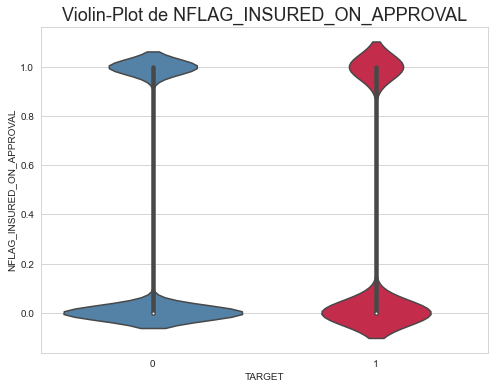

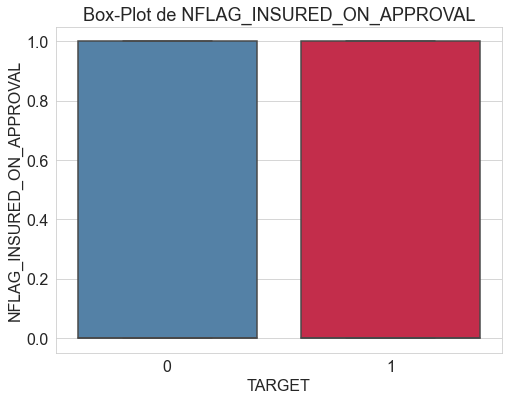

In [25]:
# Affiche les quantiles
eda_kernel_fonctions. \
    print_percentiles(prev_merged, 'NFLAG_INSURED_ON_APPROVAL',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche violinplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'NFLAG_INSURED_ON_APPROVAL',
                                               plots=['violin'],
                                               figsize=(8, 6))
# Affiche boxplot
eda_kernel_fonctions.plot_continuous_variables(prev_merged,
                                               'NFLAG_INSURED_ON_APPROVAL',
                                               plots=['box'],
                                               figsize=(8, 6))

**Bilan** :
***
- Peu de différence.

#### <span style='background:Moccasin'>2.8.3. Analyse exploratoire multivariée</span>

<span style='background:PaleGreen'>**Corrélation entre les variables catégorielles**</span>

**Phi-K Matrix**

-------------------------------------------------------------------------------


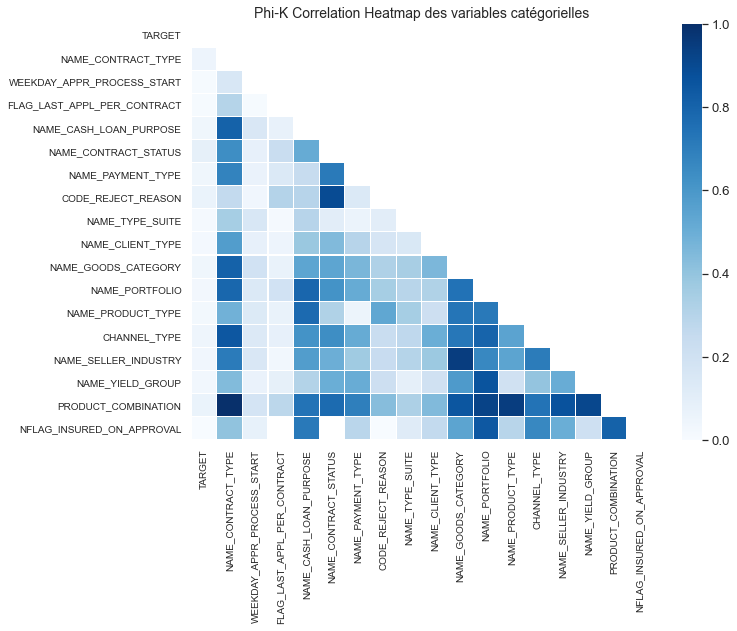

-------------------------------------------------------------------------------
Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :


-------------------------------------------------------------------------------


In [23]:
cols_for_phik = ['TARGET'] + \
    prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() \
    + ['NFLAG_INSURED_ON_APPROVAL']
eda_kernel_fonctions.plot_phik_matrix(prev_merged, cols_for_phik,
                                      figsize=(11, 9), fontsize=10)

**Bilan** :
***
À partir de la carte thermique ci-dessus des valeurs du coefficient Phi-K pour les variables catégorielles, nous observons que :
- La variables PRODUCT_COMBINATION montre une association avec beaucoup d'autres variables telles que NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
- La variable NOM_GOODS_CATEGORY est également fortement associée à NOM_SELLER_INDUSTRY.
- Si nous examinons l'association avec la variable TARGET, nous constatons que les variables NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON font partie des variables les plus fortement associées et devraient faire l'objet d'une étude plus approfondie.

<span style='background:PaleGreen'>**Corrélation entre les variables numériques**</span>

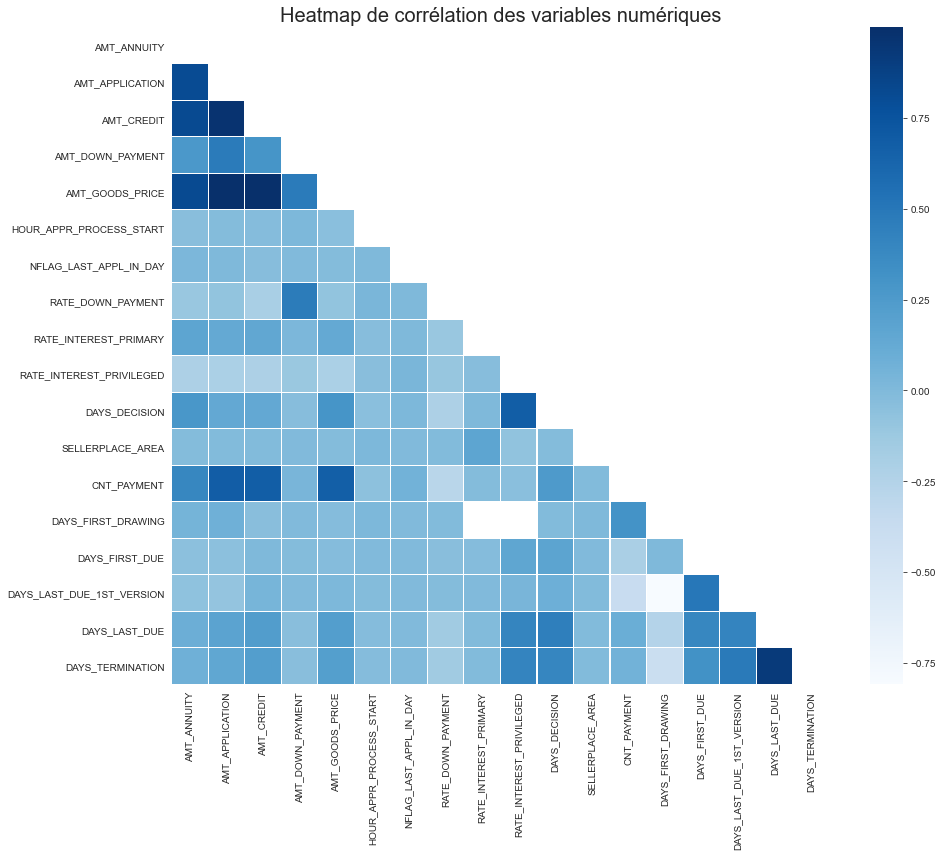

In [26]:
corr_mat = \
    eda_kernel_fonctions.correlation_matrix(prev_merged,
                                            ['SK_ID_CURR', 'SK_ID_PREV',
                                             'NFLAG_INSURED_ON_APPROVAL'],
                                            cmap='Blues',
                                            figsize=(14, 12))
corr_mat.plot_correlation_matrix()

In [25]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

-------------------------------------------------------------------------------


**Bilan** :
***
- La carte thermique ci-dessus montre la corrélation entre chaque variable du fichier previous_application et le reste des caractéristiques.
- Sur la carte thermique, nous pouvons voir certaines variables fortement corrélées qui ont une couleur plus foncée.
- La forte corrélation est particulièrement observée pour les variables :
    - DAYS_TERMINATION et DAYS_DERNIER_DUE,
    - AMT_CREDIT et AMT_APPLICATION,
    - AMT_APPLICATION et AMT_GOODS_PRICE,
    - AMT_CREDIT et AMT_ANNUITE,
    - AMT_ANNUITY et AMT_CREDIT,
    - AMT_CREDIT et AMT_GOODS_PRICE.
- Nous pouvons également constater que les variables ne présentent pas une corrélation particulièrement bonne/élevée avec Target en tant que tel. 

Cela implique qu'il n'y a pas vraiment de relation linéaire directe entre Target et les variables.

### <span style='background:PowderBlue'>2.9. Conclusions - EDA</span>

**Généralités**

À partir de l'analyse exhaustive des données que nous avons effectuée, nous pouvons tirer quelques conclusions de haut niveau sur notre ensemble de données.

- [x] Tout d'abord, l'ensemble des données devra être fusionné d'une manière ingénieuse pour que les données fusionnées aient un sens.
- [x] Certaines variables sont très discriminantes entre les défaillants et les non-défaillants, ce qui pourrait être important pour la classification.
- [x] Il y a quelques variables numériques continues qui contiennent des points erronés, nous devrions traiter ces points.
- [x] Nous avons également remarqué quelques variables corrélées, qui ne feraient qu'augmenter la dimensionnalité des données, et n'ajouteraient pas beaucoup de valeur. Nous voudrions supprimer ces variables.
- [x] Dans l'ensemble, le jeu de données est déséquilibré, et nous devrions trouver des techniques pour gérer ce déséquilibre.
- [x] Pour la prédiction du risque de défaillance, les défaillants ont généralement tendance à avoir un comportement qui n'est pas normal, et donc, nous ne pouvons pas supprimer les points aberrants ou éloignés, car ils peuvent suggérer une tendance importante de défaillance.

**Variables intéressantes/avec valeurs aberrantes**

| Fichier | Var. intéressante | Var. avec valeurs aberrantes |
| --- | --- | --- |
| <p style='text-align: justify;'>**application_train.csv** </p> | <ul style='text-align: justify;'><li>NAME_CONTRACT_TYPE</li> <li>CODE_GENDER</li> <li>FLAG_EMP_PHONE</li> <li>REGION_RATING_CLIENT_W_CITY</li> <li>NAME_EDUCATION_TYPE</li> <li>OCCUPATION_TYPE</li> <li>ORGANIZATION_TYPE</li> <li>REG_CITY_NOT_LIVE_CITY</li> <li>REG_CITY_NOT_WORK_CITY</li> <li>LIVE_CITY_NOT_WORK_CITY</li> <li>FLAG_DOCUMENT_3</li> <li>FLAG_DOCUMENT_2</li> <li>FLAG_DOCUMENT_13</li> <li>FLAG_DOCUMENT_14</li> <li>FLAG_DOCUMENT_15</li> <li>FLAG_DOCUMENT_17</li> <li>FLAG_DOCUMENT_21</li> <li>NAME_HOUSING_TYPE</li> <li>NAME_FAMILY_STATUS</li> <li>NAME_INCOME_TYPE</li> <li>NAME_TYPE_SUITE</li> <li>EMERGENCYSTATE_MODE</li> <li>FLAG_CONT_MOBILE</li> <li>DAYS_BIRTH</li> <li>DAYS_EMPLOYED</li> <li>DAYS_REGISTRATION</li> <li>DAYS_ID_PUBLISH</li> <li>EXT_SOURCE_1</li> <li>EXT_SOURCE_2</li> <li>EXT_SOURCE_3</li> <li>FLOORSMAX_AVG</li> <li>FLOORSMIN_AVG</li> <li>DAYS_LAST_PHONE_CHANGE</li> </ul> | <ul style='text-align: justify;'><li>DAYS_EMPLOYED : à partir du percentile 90, valeur de 365243 jours donc 1000 ans !</li> </ul> |
| <p style='text-align: justify;'>**bureau.csv** </p> | <ul style='text-align: justify;'><li>CREDIT_ACTIVE</li> <li>CREDIT_CURRENCY</li> <li>CREDIT_TYPE</li> <li>DAYS_CREDIT</li> <li>DAYS_ENDDATE_FACT</li> <li>DAYS_CREDIT_UPDATE</li> </ul> | <ul style='text-align: justify;'><li>DAYS_CREDIT_ENDDATE : 42060 jours ou 115 ans. Cela n'a pas beaucoup de sens car cela implique que le précédent prêt du demandeur remonte à 115 ans.</li> <li>DAYS_CREDIT_UPDATE : 41947 jours ou 114 ans. Cela n'a pas beaucoup de sens car cela implique que l'information du Bureau du Crédit remonte à 114 ans.</li> </ul> |
| <p style='text-align: justify;'>**bureau_balance.csv** </p> | <ul style='text-align: justify;'><li>STATUS</li> <li>MONTHS_BALANCE</li> </ul> |  |
| <p style='text-align: justify;'>**credit_card_balance.csv** </p> | <ul style='text-align: justify;'><li>NAME_CONTRACT_STATUS</li> <li>AMT_BALANCE</li> <li>AMT_TOTAL_RECEIVABLE</li> <li>CNT_INSTALMENT_MATURE_CUM</li> <li>MONTHS_BALANCE</li> <li>AMT_DRAWINGS_CURRENT</li> <li>AMT_INST_MIN_REGULARITY</li> <li>AMT_RECEIVABLE_PRINCIPAL</li> <li>AMT_RECIVABLE</li> </ul> |  |
| <p style='text-align: justify;'>**installments_payments.csv** </p> | <ul style='text-align: justify;'><li>DAYS_INSTALMENT</li> <li>DAYS_ENTRY_PAYMENT</li> </ul> |  |
| <p style='text-align: justify;'>**POS_CASH_balance.csv** </p> | <ul style='text-align: justify;'><li>NAME_CONTRACT_STATUS</li> </ul> |  |
| <p style='text-align: justify;'>**previous_application.csv** </p> | <ul style='text-align: justify;'><li>NAME_CONTRACT_TYPE</li> <li>NAME_CONTRACT_STATUS</li> <li>CODE_REJECT_REASON</li> <li>CHANNEL_TYPE</li> <li>PRODUCT_COMBINATION</li> <li>NAME_CASH_LOAN_PURPOSE</li> <li>NAME_PAYMENT_TYPE</li> <li>NAME_TYPE_SUITE</li> <li>NAME_CLIENT_TYPE</li> <li>NAME_GOODS_CATEGORY</li> <li>NAME_PORTFOLIO</li> <li>NAME_PRODUCT_TYPE</li> <li>DAYS_DECISION</li> <li>DAYS_FIRST_DRAWING</li> <li>DAYS_FIRST_DUE</li> </ul> | <ul style='text-align: justify;'><li>DAYS_FIRST_DRAWING : à partir du 7ième percentile, la valeur est erronée (365243 jours ~ 1000 ans).</li> <li>DAYS_FIRST_DUE : pour le percentile 100, la valeur est erronée (365243 jours ~ 1000 ans).</li> <li>DAYS_LAST_DUE : à partir du 80ième percentile, la valeur est erronée (365243 jours ~ 1000 ans).</li> <li>DAYS_LAST_DUE_1ST_VERSION : pour le percentile 100, la valeur est erronée (365243 jours ~ 1000 ans).</li> <li>DAYS_TERMINATION : à partir du percentile 80, la valeur est erronée (365243 jours ~ 1000 ans).</li> </ul>  |

Avec toutes ces informations, nous allons passer à la phase de :
   - nettoyage,
   - et de feature engineering.

***